# In this notebook, I tried to reproduce the results of the following papers

Kubo et al., 2009 (Seismological and experimental constraints on metastable phase transformations
and rheology of the Mariana slab)

Note:
- some of the equations still don't show correctly. Also they seem to mess up the title when they are presented in the "OUTLINE".

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

root_path = os.path.join(Path().resolve().parent.parent)

if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))

import hamageolib.utils.plot_helper as plot_helper
import hamageolib.research.haoyuan_2d_subduction.metastable as Meta

from hamageolib.utils.exception_handler import my_assert
from hamageolib.utils.handy_shortcuts_haoyuan import Mute

base_dir = Path().resolve()

results_dir = os.path.join(root_path, "dtemp")
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

# Utility functions

In [2]:
from vtk.util.numpy_support import vtk_to_numpy
from scipy.interpolate import interp1d
from scipy.spatial import cKDTree
    
year = 365.0 * 24.0 * 3600.0  # Seconds in one year

def idw_interpolation(points, values, query_points, k=5, power=1):
    """
    Perform inverse distance weighting (IDW) interpolation.

    Args:
        points (np.ndarray): Coordinates of known data points (N x D).
        values (np.ndarray): Values at the known data points (N,).
        query_points (np.ndarray): Coordinates of query points (M x D).
        k (int): Number of nearest neighbors to consider for interpolation.
        power (int): Power parameter for the inverse distance weighting.

    Returns:
        np.ndarray: Interpolated values at the query points (M,).
    """
    # Ensure values are a NumPy array
    values = np.asarray(values)
    
    # Build a KDTree for fast nearest-neighbor lookup
    tree = cKDTree(points)

    # Find the k nearest neighbors for each query point
    distances, indices = tree.query(query_points, k=k)

    # Handle zero distances (avoid division by zero)
    distances = np.maximum(distances, 1e-12)

    # Compute weights as the inverse distance raised to the power
    weights = 1 / distances**power

    # Normalize weights
    weights /= weights.sum(axis=1, keepdims=True)

    # Interpolate the values
    print("indices: ", indices) # debug
    interpolated_values = np.sum(weights * values[indices], axis=1)

    return interpolated_values


def extract_contour_coordinates(xv, yv, t_sub_grid, levels, spacing=None):
    """
    Extracts the x and y coordinates of contours from a meshed grid and field data.

    Args:
        xv (numpy.ndarray): 2D array of x-coordinates.
        yv (numpy.ndarray): 2D array of y-coordinates.
        t_sub_grid (numpy.ndarray): 2D array of field data on the grid.
        levels (list or array): Contour levels (values) to extract.
        spacing (float, optional): Desired spacing between contour points. Defaults to None.

    Returns:
        dict: A dictionary with levels as keys and (x, y) coordinate arrays as values.
    """
    # Create the contour object
    contours = plt.contour(xv, yv, t_sub_grid, levels=levels)

    my_assert(len(contours.collections) == len(levels), ValueError,\
              "Values of collections (%d) do not equal the provided levels(%d)"\
                  % (len(contours.collections), len(levels)))

    contour_coordinates = {}
    for i, level in enumerate(levels):
        x_coords = []
        y_coords = []

        # Extract paths for the given level
        for path in contours.collections[i].get_paths():
            vertices = path.vertices  # Extract contour points
            xs, ys = vertices[:, 0], vertices[:, 1]

            if spacing is not None and len(xs) > 1:
                # Calculate cumulative distances along the contour
                distances = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2)
                cumulative_distances = np.concatenate([[0], np.cumsum(distances)])

                # Create interpolation functions for x and y
                interp_x = interp1d(cumulative_distances, xs, kind='cubic', bounds_error=False, fill_value="extrapolate")
                interp_y = interp1d(cumulative_distances, ys, kind='cubic', bounds_error=False, fill_value="extrapolate")

                # Generate new cumulative distances with the desired spacing
                cumulative_distances_with_spacing = np.arange(0, cumulative_distances[-1], spacing)

                # Interpolate x and y for evenly spaced points
                xs = interp_x(cumulative_distances_with_spacing)
                ys = interp_y(cumulative_distances_with_spacing)

            x_coords.extend(xs)
            y_coords.extend(ys)

        contour_coordinates[level] = (np.array(x_coords), np.array(y_coords))
    
    plt.close()  # Close the plot to avoid displaying it
    return contour_coordinates

def offset_curve(X, Y, d):
    # Compute tangents as finite differences
    dX = np.gradient(X)
    dY = np.gradient(Y)
    
    # Compute normals by rotating tangents 90 degrees
    normals = np.array([dY, -dX]).T  # Rotate tangent vectors
    norm_length = np.linalg.norm(normals, axis=1, keepdims=True)
    normals = normals / norm_length  # Normalize to unit vectors
    
    # Offset points by the normal vectors scaled by the distance d
    X_offset = X + d * normals[:, 0]
    Y_offset = Y + d * normals[:, 1]
    
    return X_offset, Y_offset

def process_segments(slab_segments, n_spacing=10):
    """
    Processes segments to generate a continuous curve based on lengths and dip angles.

    Args:
        slab_segments (list): List of segment dictionaries with 'length' and 'angle' keys.
        n_spacing (int): Number of points per segment for interpolation.

    Returns:
        tuple: A tuple containing:
            - lengths (numpy.ndarray): Accumulated lengths at each point.
            - depths (numpy.ndarray): Accumulated depths at each point.
            - dip_angles (numpy.ndarray): Corresponding dip angles at each point.
            - Xs (numpy.ndarray): X coordinates of each point.
    """
    # Calculate the total number of points in advance
    total_points = sum(n_spacing for _ in slab_segments)

    # Preallocate arrays
    lengths = np.zeros(total_points)
    depths = np.zeros(total_points)
    dip_angles = np.zeros(total_points)
    Xs = np.zeros(total_points)

    accumulated_length = 0
    accumulated_depth = 0
    accumulated_x = 0
    current_index = 0

    for segment in slab_segments:
        # Extract length and angle pair
        length = segment['length']
        angle_pair = segment['angle']

        # Generate n_spacing points for angles and step lengths
        segment_angles = np.linspace(angle_pair[0], angle_pair[1], n_spacing)
        step_length = length / (n_spacing - 1)  # Incremental length per step

        # Calculate incremental depths and X increments for each step
        segment_depth_increments = step_length * (
            np.sin(np.radians(segment_angles[:-1])) + np.sin(np.radians(segment_angles[1:]))
        ) / 2.0  # Midpoint rule for depth integration

        segment_x_increments = step_length * (
            np.cos(np.radians(segment_angles[:-1])) + np.cos(np.radians(segment_angles[1:]))
        ) / 2.0  # Midpoint rule for X integration

        # Accumulated lengths and depths
        segment_accumulated_lengths = accumulated_length + np.arange(n_spacing) * step_length
        segment_depths = accumulated_depth + np.concatenate([np.array([0]), np.cumsum(segment_depth_increments)])
        segment_xs = accumulated_x + np.concatenate([np.array([0]), np.cumsum(segment_x_increments)])

        # Write to preallocated arrays
        lengths[current_index:current_index + n_spacing] = segment_accumulated_lengths
        depths[current_index:current_index + n_spacing] = segment_depths
        dip_angles[current_index:current_index + n_spacing] = np.radians(segment_angles)
        Xs[current_index:current_index + n_spacing] = segment_xs

        # Update accumulations for the next segment
        accumulated_length = segment_accumulated_lengths[-1]
        accumulated_depth = segment_depths[-1]
        accumulated_x = segment_xs[-1]
        current_index += n_spacing

    return lengths, depths, dip_angles, Xs


def distances_to_curve(Xs, Ys, x, y):
    """
    Computes the signed distance from each point in (x, y) to a curve defined by (Xs, Ys).

    Positive distance: below the curve (smaller y).
    Negative distance: above the curve (larger y).

    Args:
        Xs (numpy.ndarray): X-coordinates of the curve points (1D array).
        Ys (numpy.ndarray): Y-coordinates of the curve points (1D array).
        x (numpy.ndarray): X-coordinates of the points (1D array).
        y (numpy.ndarray): Y-coordinates of the points (1D array).

    Returns:
        numpy.ndarray: The signed distance from each point in (x, y) to the curve (1D array).
    """
    # Ensure x and y are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)

    # Reshape (x, y) to allow broadcasting against (Xs, Ys)
    x = x[:, np.newaxis]  # Shape (n_points, 1)
    y = y[:, np.newaxis]  # Shape (n_points, 1)

    # Compute squared distances for all combinations
    distances_squared = (Xs - x) ** 2 + (Ys - y) ** 2  # Shape (n_points, len(Xs))

    # Find the index of the closest point on the curve for each query point
    min_indices = np.argmin(distances_squared, axis=1)

    # Use min_indices to directly extract the minimum distances
    min_distances = np.sqrt(distances_squared[np.arange(len(x)), min_indices])

    # Determine if the point is above or below the curve
    closest_Ys = Ys[min_indices]
    signs = np.where(y.flatten() < closest_Ys, 1.0, -1.0)

    # Apply the sign to the distances
    signed_distances = signs * min_distances
    return signed_distances

# Equilibrium phase transition

In [3]:
# equilibrium phase transition for 410 km
# dV - change in volume fraction
# See whether these are still needed
# dV_ol_wd - m^3 / mol, difference in volume between phases
# V_initial - m^3 / mol, for olivine, estimation at 410 km
# PT410 = {"P": 13.5e9, "T": 1740.0, "cl": 2e6, "dV": 0.052, "dV_ol_wd": 2.4e-6, "V_initial": 35.17e-6}
# todo_para
PT410 = {"P": 13.5e9, "T": 1740.0, "cl": 2e6}

# Hosoya 2005 (The Kinematics)

## Summary: Growth Rate and Timescale Calculations Based on Hosoya 2006

This notebook contains Python code for calculating the growth rate and critical timescales of phase transformations based on the kinetic models described in *Hosoya et al., 2006*. The calculations rely on the Arrhenius law and consider the effects of pressure, temperature, and water content.

### Constants and Assumptions

- Universal gas constant: \( R = 8.31446 \, \text{J/mol·K} \)
- Activation enthalpy: \( \Delta H = 274 \, \text{kJ/mol} \)
- Activation volume: \( V^* = 3.3 \times 10^{-6} \, \text{m}^3/\text{mol} \)
- Volume difference: \( \Delta V = 2.4 \times 10^{-6} \, \text{m}^3/\text{mol} \)
- Water concentration scaling exponent: \( n = 3.2 \)

### Functions Overview

1. **`growth_rate_hosoya_06_eq2_P1(P, T, Coh)`**:
   - Calculates the growth rate using Equation 2 from Hosoya (2006) for given pressure (`P`), temperature (`T`), and water concentration (`Coh`).
   - **Parameters**:
     - `P`: Pressure (Pa)
     - `T`: Temperature (K)
     - `Coh`: Water concentration (wt.ppm H2O)
   - **Returns**: Growth rate in meters per second.

2. **`growth_rate_hosoya_06_eq2(P, P_eq, T, Coh)`**:
   - Extends the growth rate calculation to handle cases where the pressure is an array and determines whether the pressure exceeds the equilibrium pressure (`P_eq`).
   - **Parameters**:
     - `P`: Pressure (float or ndarray)
     - `P_eq`: Equilibrium pressure (Pa)
     - `T`: Temperature (K)
     - `Coh`: Water concentration (wt.ppm H2O)
   - **Returns**: Growth rate as a float or array.

3. **`timescale_hosoya_06(P, P_eq, growth_rate, Coh)`**:
   - Computes the critical timescale for phase transitions using growth rate and equilibrium properties.
   - **Parameters**:
     - `P`: Pressure (Pa)
     - `P_eq`: Equilibrium pressure (Pa)
     - `growth_rate`: Growth rate (m/s)
     - `Coh`: Water concentration (wt.ppm H2O)
   - **Returns**: Critical timescale (seconds).

### Visualization

The notebook includes plots to visualize the growth rate variations:
- **Pressure vs. Growth Rate**: Explores the dependence of growth rate on pressure.
- **Temperature vs. Growth Rate**: Shows how growth rate changes with temperature.
- **OH Content vs. Growth Rate**: Investigates the effect of water concentration on growth rate.

In [4]:
from matplotlib import gridspec
from scipy.integrate import cumtrapz

def growth_rate_P1(P, T, Coh):
    """
    Calculate the growth rate following Equation 2 in Hosoya 2006.

    Parameters:
    - P (float): Pressure in Pascals.
    - T (float): Temperature in Kelvin.
    - Coh (float): Concentration of water in weight parts per million (wt.ppm H2O).

    Returns:
    - float: The growth rate calculated using the given parameters.
    """
    R = 8.31446  # J / mol*K, universal gas constant

    # Constants based on Hosoya 2006
    A = np.exp(-18.0)  # m s-1 wt.ppmH2O^(-3.2)
    n = 3.2
    dHa = 274.0e3  # J / mol, activation enthalpy
    Vstar = 3.3e-6  # m^3 / mol, activation volume

    growth_rate_part = A * Coh**n * np.exp(-(dHa + P * Vstar) / (R * T))

    return growth_rate_part


def growth_rate_metastable(P, P_eq, T, Coh):
    """
    Calculate growth rate using Equation 2 from Hosoya 2006 for metastable conditions.

    Parameters:
    - P (float or ndarray): Actual pressure (Pa).
    - P_eq (float or ndarray): Equilibrium pressure (Pa).
    - T (float or ndarray): Temperature (K).
    - Coh (float): Water concentration (wt.ppm H2O).

    Returns:
    - float or ndarray: Growth rate for the given conditions.
    """
    if type(T) in [float, np.float64]:
        if Ps > P_eq:
            growth_rate = growth_rate(P, P_eq, T, Coh)
        else:
            growth_rate = 0.0
    elif type(T) == np.ndarray:
        assert P.shape == T.shape
        assert P_eq.shape == T.shape
        growth_rate = np.zeros(T.shape)
        mask = (P > P_eq)  # Check metastable condition
        growth_rate[mask] = growth_rate(P[mask], P_eq[mask], T[mask], Coh)
    else:
        raise TypeError("T must be float or ndarray")
    return growth_rate


def growth_rate(P, P_eq, T, Coh):
    """
    Calculate the growth rate following Equation 2 in Hosoya 2006, considering 
    pressure and temperature variations.

    Parameters:
    - P (float or np.ndarray): Pressure in Pascals.
    - P_eq (float or np.ndarray): Equilibrium pressure in Pascals.
    - T (float or np.ndarray): Temperature in Kelvin.
    - Coh (float): Concentration of water in weight parts per million (wt.ppm H2O).

    Returns:
    - float or np.ndarray: The growth rate for each pressure point.
    """
    R = 8.31446  # J / mol*K, universal gas constant

    # Determine growth rate based on pressure type (float or array)
    if type(P) in [float, np.float64]:
        if P > P_eq:
            dGr = PT410["dV_ol_wd"] * (P - P_eq)
            growth_rate = growth_rate_P1(P, T, Coh) * T * (1 - np.exp(-dGr / (R * T)))
        else:
            growth_rate = 0.0
    elif type(P) == np.ndarray:
        growth_rate = np.zeros(P.shape)
        mask = P > P_eq
        Pm = P[mask]
        Tm = T[mask]
        dGr = PT410["dV_ol_wd"] * (Pm - P_eq[mask])
        growth_rate[mask] = growth_rate_P1(Pm, Tm, Coh) * Tm * (1 - np.exp(-dGr / (R * Tm)))
    else:
        raise TypeError("P must be float or ndarray")

    return growth_rate


def timescale_hosoya_06(P, P_eq, growth_rate, Coh):
    """
    Calculate the critical time scale for phase transition kinetics.

    Parameters:
    - P (float): Pressure in Pascals.
    - P_eq (float): Equilibrium pressure in Pascals.
    - growth_rate (float): Growth rate in m/s.
    - Coh (float): Concentration of water in weight parts per million (wt.ppm H2O).

    Returns:
    - float: The critical timescale in seconds.
    """
    R = 8.31446  # J / mol*K, universal gas constant

    # Constants for calculation
    A = np.exp(-18.0)  # m s-1 wt.ppmH2O^(-3.2)
    A_dot = A * PT410["dV_ol_wd"] / R
    n = 3.2
    dHa = 274.0e3  # J / mol, activation enthalpy
    Vstar = 3.3e-6  # m^3 / mol, activation volume

    Tcr = (dHa + P * Vstar) / R / (np.log(A_dot * Coh**n * (P - P_eq) / growth_rate))

    return Tcr

def MO_Vfraction_classic(growth_rates, ts, da0):

    # Compute cumulative integral of growth rates over time
    integral = np.zeros(growth_rates.shape)  # Initialize integral
    integral[1:] = cumtrapz(growth_rates, ts)  # Cumulative integral

    # Calculate transformed volume fraction
    S = 3.35 / da0  # Surface area per unit volume (1/m)
    V = 1 - np.exp(-2.0 * S * integral)  # Transformed volume fraction

    return V


plot_hosoya_06 = False

if plot_hosoya_06:

    # Visualization of growth rate variations
    fig = plt.figure(tight_layout=True, figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3)

    # Plot growth rate vs Pressure
    ax = fig.add_subplot(gs[0, 0])
    T = 900 + 273.15  # Temperature in Kelvin
    Ps = np.arange(13e9, 16e9, 0.1e9)  # Pressure range in Pascals
    Coh = 1000.0  # Concentration of water in wt.ppm H2O
    growth_rate_part = growth_rate_P1(Ps, T, Coh)
    ax.plot(Ps / 1e9, np.log(growth_rate_part))  # Pressure in GPa
    ax.grid()
    ax.set_xlim([13.0, 16.0])
    ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("Pressure (GPa)")
    ax.set_ylabel("ln(growth_rate/T[1-exp(-dGr/RT)])")

    # Plot growth rate vs Temperature
    ax = fig.add_subplot(gs[0, 1])
    T_invert = np.arange(0.7, 1.1, 0.01)  # 1000/T range
    Ts = 1000.0 / T_invert  # Temperature in Kelvin
    P = 15e9  # Pressure in Pascals
    Coh = 1000.0  # Concentration of water in wt.ppm H2O
    growth_rate_part = growth_rate_P1(P, Ts, Coh)
    ax.plot(T_invert, np.log(growth_rate_part))
    ax.grid()
    ax.set_xlim([0.7, 1.1])
    ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("1000/T (K)")

    # Plot growth rate vs OH content
    ax = fig.add_subplot(gs[0, 2])
    T = 900 + 273.15  # Temperature in Kelvin
    P = 15e9  # Pressure in Pascals
    log10_Cohs = np.arange(2, 4, 0.05)  # Logarithmic OH content range
    Cohs = 10**log10_Cohs  # OH content in wt.ppm H2O
    growth_rate_part = growth_rate_P1(P, T, Cohs)
    ax.semilogx(Cohs, np.log(growth_rate_part))
    ax.grid()
    ax.set_xlim([10**2, 10**4])
    ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("OH content (wt. ppm H2O)")


We also plot the values of grow rate for comparison

In [5]:
if plot_hosoya_06:


    # Visualization of growth rate variations
    fig = plt.figure(tight_layout=True, figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3)

    # Plot growth rate vs Pressure
    ax = fig.add_subplot(gs[0, 0])
    T = 900 + 273.15  # Temperature in Kelvin
    Ps = np.arange(13e9, 16e9, 0.1e9)  # Pressure range in Pascals
    Ts = np.full(Ps.shape, T)
    Ps_eq = np.full(Ps.shape, PT410["P"])
    Coh = 1000.0  # Concentration of water in wt.ppm H2O
    growth_rate = growth_rate(Ps, Ps_eq, Ts, Coh)
    # growth_rate_part = growth_rate_P1(Ps, T, Coh)

    ax.plot(Ps/1e9, np.log(growth_rate))
    ax.grid()
    ax.set_xlabel("Pressure (GPa)")
    ax.set_ylabel("Growth Rate (m/s)")
    ax.set_xlim([13.0, 16.0])


    # Plot growth rate vs Temperature
    ax = fig.add_subplot(gs[0, 1])
    T_invert = np.arange(0.7, 1.1, 0.01)  # 1000/T range
    Ts = 1000.0 / T_invert  # Temperature in Kelvin
    P = 15e9  # Pressure in Pascals
    Ps = np.full(Ts.shape, P)
    Ps_eq = np.full(Ps.shape, PT410["P"])
    Coh = 1000.0  # Concentration of water in wt.ppm H2O
    growth_rate = growth_rate(Ps, Ps_eq, Ts, Coh)
    ax.plot(T_invert, np.log(growth_rate))
    ax.grid()
    ax.set_xlim([0.7, 1.1])
    # ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("1000/T (K)")
    # ax.set_ylabel("Growth Rate (m/s)")


    # Plot growth rate vs OH content
    ax = fig.add_subplot(gs[0, 2])
    T = 900 + 273.15  # Temperature in Kelvin
    P = 15e9  # Pressure in Pascals
    log10_Cohs = np.arange(2, 4, 0.05)  # Logarithmic OH content range
    Cohs = 10**log10_Cohs  # OH content in wt.ppm H2O
    Ts = np.full(Cohs.shape, T)
    Ps = np.full(Cohs.shape, P)
    Ps_eq = np.full(Cohs.shape, PT410["P"])
    growth_rate = growth_rate(Ps, Ps_eq, Ts, Cohs)
    # growth_rate_part = growth_rate_P1(P, T, Cohs)
    ax.semilogx(Cohs, growth_rate)
    ax.grid()
    ax.set_xlim([10**2, 10**4])
#     ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("OH content (wt. ppm H2O)") 

# Kubo et al., 2009

## Interpolation and Visualization of Temperature Profile

This section of the notebook focuses on loading, interpolating, and visualizing a temperature profile (their Fig. 2) based on depth from a CSV file.
They already include the latent heat release from the exthorthemic transition in the thermal model (Fig. 2).

### Key Steps

1. **Data Loading**:
   - Reads the temperature profile from a CSV file (`kubo_2009_T_center.csv`).
   - The file is located in the `data_set` directory within the specified `base_dir`.

2. **Data Extraction**:
   - Extracts depth (in kilometers) and temperature (in degrees Celsius) columns from the loaded dataset.

3. **Interpolation**:
   - Uses `scipy.interpolate.interp1d` to create an interpolation function for the temperature profile.
   - Generates interpolated values for depths at 1 km intervals.

4. **Visualization**:
   - Plots the interpolated temperature profile, with depth on the x-axis and temperature on the y-axis.
   - Includes axis labels and a grid for improved clarity.

### Assumptions and Requirements

- The CSV file must exist at the specified path, and its structure should include two columns: depth and temperature.
- The depth values should be sorted in ascending order for proper interpolation.

In [6]:
from scipy.interpolate import interp1d

reproduce_Kubo_2009 = False

if reproduce_Kubo_2009:

    # Load and plot the temperature profile from a CSV file.
    # Load temperature profile data from the file
    file_T_path = os.path.join(base_dir, "data_set", "kubo_2009_T_center.csv")
    assert(os.path.isfile(file_T_path))  # Ensure the file exists
    data_T = pd.read_csv(file_T_path)  # Read data using pandas

    # Extract depth and temperature columns
    depths = data_T.iloc[:, 0]  # Depth in kilometers
    Ts = data_T.iloc[:, 1]  # Temperature in degrees Celsius

    # Interpolate temperature profile
    T_interp = interp1d(depths, Ts)  # Create an interpolating function

    # Generate interpolated values
    depths1 = np.arange(depths.iloc[0], depths.iloc[-1], 1.0)  # Interpolated depths (km)
    Ts1 = T_interp(depths1)  # Interpolated temperatures (C)

    # Plot the interpolated temperature profile
    fig, ax = plt.subplots()
    ax.plot(depths1, Ts1)  # Depth vs. temperature plot

    # Add plot labels and grid
    ax.set_xlabel("Depth (km)")  # Label for x-axis
    ax.set_ylabel("Temperature (C)")  # Label for y-axis
    ax.grid()  # Add grid for better visualization


## This section calculates and visualizes two types of temperature dependencies in their Fig. 4

1. Non-equilibrium temperature (\( T_{NE} \)) as a function of overpressure.
2. Grain size-dependent temperature (\( T_{GN} \)) as a function of grain size.

### Equation for V

$V = 1 - exp\left[-2S \int_{0}^t \dot{x}\left(\tau\right)d\tau\right]$

### Key Steps

1. **Non-equilibrium Temperature ($T_{NE}$)**:
   - Computes $T_{NE}$ for 1000 ppm and 100 ppm water concentrations.
   - Uses an overpressure range ($\Delta P$) from $0.01 \, \text{GPa}$ to $1.0 \, \text{GPa}$.
   - Subduction velocity ($v_{sub}$) and timescale ($t_{sub}$) are used to estimate the growth rate.
   - Visualized as $T_{NE}$ versus overpressure in a log-log plot.

2. **Grain Size-dependent Temperature ($T_{GN}$)**:
   - Computes $T_{GN}$ for 1000 ppm and 100 ppm water concentrations.
   - Uses a grain size range ($d$) from $10^{-6} \, \text{m}$ to $10^{-1} \, \text{m}$.
   - Grain size-dependent growth rate ($v_{GN}$) is calculated using a fixed subduction timescale ($t_{sub}$).
   - Visualized as $T_{GN}$ versus grain size in a log-log plot.

### Constants and Assumptions

- **Year Conversion**: $1 \, \text{year} = 365 \times 24 \times 3600 \, \text{s}$
- **Equilibrium Conditions**:
  - Equilibrium temperature: $T_{eq,410} = 1760 \, \text{K}$
  - Clapeyron slope: $c_{l,410} = 4 \times 10^6 \, \text{Pa/K}$
  - Equilibrium pressure: $P_{410} = 14 \, \text{GPa}$
- **Subduction Properties**:
  - Grain size: $d = 5 \times 10^{-3} \, \text{m}$
  - Subduction velocity: $v_{sub} = 0.1 / \text{year}$
  - Subduction timescale: $t_{sub} = 10^5 \, \text{years}$

### Additional notes
* Note their ol-wd curves references the Hosoya 2005 paper, while the post-spinel curve references the Kubo et al., 2002a, 2008 paper.
* S is the area of grain-boundary of parent phase (=3.35/d), d is the grain size of the parental olivine, assuming equidimensional grains (tetrakaidecahedra) [Cahn, 1956]. Note this seems the only place the parental grain size is needed.
* d is assumed to 5 mm in their figure 3.
* tsub, the subduction timescale, is based on $v_{sub}t_{sub} = 10 km$, thus a velocity of 10 cm yields a timescale of ${10}^5$ years.

In [7]:
if reproduce_Kubo_2009:


    # Create a figure with two subplots
    fig = plt.figure(tight_layout=True, figsize=(5, 10))
    gs = gridspec.GridSpec(2, 1)

    # ---- Figure 4a: T_NE (non-equilibrium temperature) vs. overpressure ----
    ax = fig.add_subplot(gs[0, 0])

    P_eq = PT410["P"]  # Equilibrium pressure (Pa)
    lndP = np.arange(-2.0, 0.0, 0.05)  # Logarithmic overpressure range (log10 GPa)
    dP = 10**lndP * 1e9  # Overpressure range (Pa)
    P = P_eq + dP  # Actual pressure range (Pa)
    d = 5e-3  # Grain size (m)
    v_sub = 0.1 / year  # Subduction velocity (m/s)
    t_sub = 1e5 * year  # Subduction timescale (s)
    growth_rate_NE = v_sub  # Growth rate for non-equilibrium

    # Calculate non-equilibrium temperature timescale (T_NE) for 1000 ppm water
    ts_NE = timescale_hosoya_06(P, P_eq, growth_rate_NE, 1000.0)
    ax.semilogx(dP / 1e9, ts_NE - 273.15, label="ol-wd, 1000 ppm")  # Plot curve for 1000 ppm

    # Calculate T_NE for 100 ppm water
    ts_NE_coh100 = timescale_hosoya_06(P, P_eq, growth_rate_NE, 100.0)
    ax.semilogx(dP / 1e9, ts_NE_coh100 - 273.15, label="ol-wd, 100 ppm")  # Plot curve for 100 ppm

    # Configure subplot
    ax.grid()
    ax.legend()
    ax.set_xlim([1e-2, 1.0])  # Overpressure range (GPa)
    ax.set_ylim([800, 2100.0])  # Temperature range (°C)
    ax.set_xlabel("Overpressure (GPa)")
    ax.set_ylabel("T_NE (C)")

    # ---- Figure 4b: T_GN (grain size-dependent temperature) vs. grain size ----
    ax = fig.add_subplot(gs[1, 0])

    logds = np.arange(-6, -1, 0.1)  # Logarithmic grain size range
    ds = 10**logds  # Grain size range (m)
    growth_rate_GN = ds / t_sub  # Grain size-dependent growth rate (m/s)
    dP = 0.5e9  # Overpressure (Pa)
    P = P_eq + dP  # Pressure for grain size calculations (Pa)

    # Calculate grain size-dependent temperature timescale (T_GN) for 1000 ppm water
    ts_GN = timescale_hosoya_06(P, P_eq, growth_rate_GN, 1000.0)
    ax.semilogx(ds, ts_GN - 273.15, label="ol-wd, 1000 ppm")  # Plot curve for 1000 ppm

    # Calculate T_GN for 100 ppm water
    ts_GN_coh100 = timescale_hosoya_06(P, P_eq, growth_rate_GN, 100.0)
    ax.semilogx(ds, ts_GN_coh100 - 273.15, label="ol-wd, 100 ppm")  # Plot curve for 100 ppm

    # Configure subplot
    ax.grid()
    ax.legend()
    ax.set_xlim([1e-6, 1e-1])  # Grain size range (m)
    ax.set_ylim([400, 1700.0])  # Temperature range (°C)
    ax.set_xlabel("Parental grain size (m)")
    ax.set_ylabel("T_GN (C)")


## FIgure 5: Nucleation and Growth Visualization

### Key Steps

1. **Parameters**:
   - Temperature (\(T\)) and pressure (\(P\)) profiles are calculated for depths from 400 km to 700 km.
   - Grain sizes (\(d\)) are set to \(5 \times 10^{-3} \, \text{m}\) for grain-boundary nucleation and \(5 \times 10^{-5} \, \text{m}\) for intracrystalline nucleation.

2. **Growth Rates**:
   - Growth rates are computed using metastable conditions for varying water concentrations (\(C_{OH}\)).

3. **Transformed Volume Fractions**:
   - The cumulative transformed volume (\(V\)) is calculated as:
     \[
     V = 1 - \exp(-2.0 \cdot S \cdot \text{integral})
     \]
   - \(S\) is the surface area per unit volume.

4. **Plots**:
   - **Grain-boundary nucleation**: \(V\) is plotted against depth for water concentrations of 250, 500, and 750 wt.ppm.
   - **Intracrystalline nucleation**: \(V\) is plotted against depth for water concentrations of 50, 150, and 250 wt.ppm.

### Additional Notes
* They seem to not include the positive feedback from the latentheat, as they note "Previous studies have revealed that the G-type olivine–ringwoodite transformation quickly completes when it proceeds to the critical volume fraction of 5–10 vol.% due to the positive feedback of the latent heat release (e.g., Rubie and Ross, 1994; Kirby et al., 1996; Mosenfelder et al., 2001)."
* The transformed volume by intracrystallion nucleation should always be bigger, since it assumes a smaller parental grain size, thus a larger nucleation area S.
* Note the slight differences of our curves to theirs (e.g. the 250 wt.ppm H2O curve in figure 5 a, at 700 depth, theirs is around 0.85, while ours is around 0.95)

In [8]:
# figure 5: Grain-boundary and intracrystalline nucleation plots

if reproduce_Kubo_2009:

    from scipy.integrate import cumtrapz
    from matplotlib import gridspec

    # Retrieve the default color cycle for consistent plot coloring
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Reference parameters from Hosoya 2005
    T660 = 873.0  # Temperature at 660 km depth (K)
    Tgrad = 0.6 / 1e3  # Temperature gradient (K/m)
    dPdh = 30e6 / 1e3  # Pressure gradient (Pa/m)
    v_sub = 0.095 / year  # Subduction velocity (m/s)
    depth0 = 400e3  # Initial depth for calculations (m)

    # Define depth, temperature, and pressure profiles
    depths = np.arange(depth0, 700e3, 1e3)  # Depths from 400 to 700 km (m)
    ts = (depths - depth0) / v_sub  # Time required for subduction to each depth (s)
    Ts = T_interp(depths / 1e3) + 273.15  # Temperature interpolated and converted to K
    Ps = (depths - 410e3) * dPdh + PT410["P"]  # Pressure profile (Pa)

    # Equilibrium pressure and corresponding depths
    Ps_eq = (Ts - PT410["T"]) * PT410["cl"] + PT410["P"]  # Equilibrium pressure (Pa)
    depths_eq = 410e3 + (Ts - PT410["T"]) * PT410["cl"] / dPdh  # Equilibrium depth (m)


    # Create a figure for nucleation plots
    fig = plt.figure(tight_layout=True, figsize=(5, 10))
    gs = gridspec.GridSpec(2, 1)

    # ---- Plot 1: Grain-boundary nucleation ----
    ax = fig.add_subplot(gs[0, 0])

    d_ol = 5e-3  # Grain size for olivine (m)
    S = 3.35 / d_ol  # Surface area per unit volume (1/m)

    # Calculate and plot for different water concentrations
    for Coh, color, label in [(250.0, default_colors[2], "250 wt.ppm H2O"),
                            (500.0, default_colors[1], "500 wt.ppm H2O"),
                            (750.0, default_colors[0], "750 wt.ppm H2O")]:
        growth_rates = growth_rate_metastable(Ps, Ps_eq, Ts, Coh)
        integral = np.zeros(depths.shape)  # Initialize integral
        integral[1:] = cumtrapz(growth_rates, ts)  # Cumulative integral
        V = 1 - np.exp(-2.0 * S * integral)  # Transformed volume fraction
        ax.plot(depths / 1e3, V, label=label, color=color)

    # Configure plot
    ax.grid()
    ax.legend()
    ax.set_xlabel("Depth (km)")
    ax.set_ylabel("Transformed Volume Fraction")
    ax.set_title("Grain-boundary nucleation")

    # ---- Plot 2: Intracrystalline nucleation ----
    ax = fig.add_subplot(gs[1, 0])

    d_ol = 5e-5  # Grain size for olivine (m)
    S = 3.35 / d_ol  # Surface area per unit volume (1/m)

    # Calculate and plot for different water concentrations
    for Coh, color, label in [(50.0, default_colors[4], "50 wt.ppm H2O"),
                            (150.0, default_colors[3], "150 wt.ppm H2O"),
                            (250.0, default_colors[2], "250 wt.ppm H2O")]:
        growth_rates = growth_rate_metastable(Ps, Ps_eq, Ts, Coh)
        integral = np.zeros(depths.shape)  # Initialize integral
        integral[1:] = cumtrapz(growth_rates, ts)  # Cumulative integral
        V = 1 - np.exp(-2.0 * S * integral)  # Transformed volume fraction
        ax.plot(depths / 1e3, V, label=label, color=color)

    # Configure plot
    ax.grid()
    ax.legend()
    ax.set_xlabel("Depth (km)")
    ax.set_ylabel("Transformed Volume Fraction")
    ax.set_title("Intracrystalline nucleation")

    plt.show()


## Figure 7: Grain size evolution and viscosity calculation

### Key Steps

1. **Viscosity Calculation**:
   - The flow law from *Kubo et al., 2008* is used to compute viscosity:
     $$
     \eta = \eta_0 \exp\left(\frac{T_0 - T}{a} + \frac{z}{b} - \left(\frac{z}{c}\right)^2\right)
     $$
     - Parameters:
       - $T$: Temperature (K).
       - $z$: Depth (m).
       - $\eta_0$, reference viscosity.
       - $T_0 = 1873.15 \, \text{K}$, reference temperature.
       - $a = 131.3 \, \text{K}$, $b = 150 \, \text{km}$, $c = 1086 \, \text{km}$.

2. **Grain Size Profiles**:
   - Initial grain sizes:
     - Olivine: $d_{a0} = 5 \, \text{mm}$.
     - Wadleyite: $d_{b0} = 0.1 \, \text{mm}$.
   - Grain size evolution is based on the transformed volume fraction $V$:
     $$
     V = 1 - \exp(-2.0 \cdot S \cdot \text{integral})
     $$
     - $S = \frac{3.35}{d_{a0}}$: Surface area per unit volume (1/m).
     - The integral accumulates growth rates over time.

3. **Switching Conditions**:
   - Grain size switches from olivine to wadleyite when $V > 0.5$.

### Constants and Assumptions

- **Depth Range**: 400 km to 700 km.
- **Water Concentration**: $C_{OH} = 500 \, \text{wt.ppm}$.
- **Subduction Velocity**: $v_{\text{sub}} = 0.095 \, \text{m/s}$.

### Additional Notes

* Current state: I failed to reproduce the grain size evolution. I assumed the grain size to be the integration of growth rate, this might cause the problem. It might also be the case there is something wrong in the grain growth mechanism.
* For the viscosity, they used the Peierls creep in Karato et al., 2001 and Diffusion creep in Frost and Ashby, I didn't go further into these references.

In [9]:
# Figure 7
def flow_law_Kubo_2008(T, z):
    """
    Compute viscosity using the flow law from Kubo et al. 2008.

    Parameters:
    - T (float): Temperature (K).
    - z (float): Depth (m).

    Returns:
    - float: Viscosity (Pa·s).
    """
    # Constants for the flow law
    a = 131.3  # Temperature scaling factor (K)
    b = 150.0e3  # Depth linear term (m)
    c = 1086e3  # Depth quadratic term (m)
    T0 = 1600 + 273.15  # Reference temperature (K)
    eta0 = 1e-19  # Reference viscosity (Pa·s)

    # Calculate viscosity
    eta = eta0 * np.exp((T0 - T) / a + z / b - (z / c)**2.0)

    return eta

if reproduce_Kubo_2009:

    # Initial parameters
    da0 = 5e-3  # Initial grain size for olivine (m)
    db0 = 1e-7  # Initial grain size for wadleyite (m)
    Coh = 500  # Water concentration (wt.ppm H2O)

    # Define depth, temperature, and pressure profiles
    depths = np.arange(depth0, 700e3, 1e3)  # Depths from 400 to 700 km (m)
    ts = (depths - depth0) / v_sub  # Subduction time to each depth (s)
    Ts = T_interp(depths / 1e3) + 273.15  # Temperature interpolated and converted to K
    Ps = (depths - 410e3) * dPdh + PT410["P"]  # Pressure profile (Pa)

    # Equilibrium pressure and corresponding depths
    Ps_eq = (Ts - PT410["T"]) * PT410["cl"] + PT410["P"]  # Equilibrium pressure (Pa)

    # Initial grain size profile
    ds = np.full(depths.size, da0)  # Start with constant grain size (m)

    # Calculate growth rates under metastable conditions
    growth_rates = growth_rate_metastable(Ps, Ps_eq, Ts, Coh)

    # Compute cumulative integral of growth rates over time
    integral = np.zeros(depths.shape)  # Initialize integral
    integral[1:] = cumtrapz(growth_rates, ts)  # Cumulative integral

    # Calculate transformed volume fraction
    S = 3.35 / da0  # Surface area per unit volume (1/m)
    V = 1 - np.exp(-2.0 * S * integral)  # Transformed volume fraction

    # Update grain size profile
    db = db0 + integral  # Wadleyite grain size evolution (m)

    # Switch grain size based on transformed volume fraction
    mask = (V > 0.5)  # Condition where transformed fraction exceeds 50%
    ds[mask] = db[mask]  # Update grain size for transformed regions

    # Create a figure for grain size plots
    fig = plt.figure(tight_layout=True, figsize=(5, 10))
    gs = gridspec.GridSpec(2, 1)

    # ---- Plot 1: Grain Size vs Depth ----
    ax = fig.add_subplot(gs[0, 0])
    ax.semilogy(depths / 1e3, ds / 1e-6, label="grain size (olivine)")  # Grain size (micron)
    ax.semilogy(depths / 1e3, db / 1e-6, label="grain size (wadleyite)")  # Wadleyite grain size (micron)

    # Configure plot
    ax.grid()
    ax.legend()
    ax.set_xlabel("Depth (km)")
    ax.set_ylabel("Grain size (micron)")


# Tetzlaff & Schmeling 09

## Import their temperature profile in figure 1

Here I only plot their curves with no latent heat effects

## Check the value of their growth rate

Note using their documented values results in a growth rate too low (compared to the same plot in the Hosoya paper). This would in turn result in a 0 fraction of wb contents.

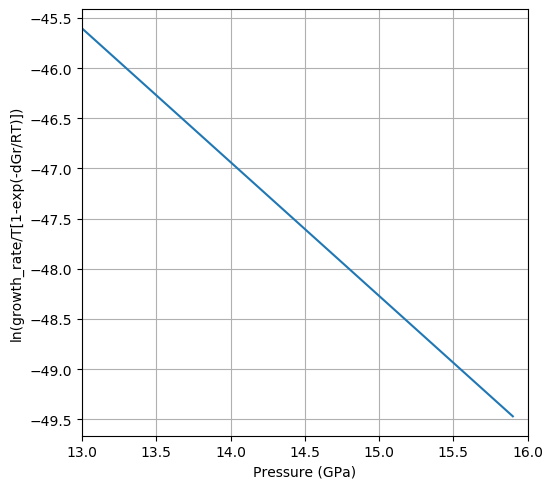

In [10]:
from matplotlib import gridspec

def Tprofile_TS09_fig1_warm(depths):

    depth0 = 370.28496710020283e3; T0 = 684.1150723737485 + 273.15 # m, K
    depth1 = 698.9440717961519e3; T1 = 912.82119751198 + 273.15 # m, K

    Ts = (depths - depth0) / (depth1 - depth0) * T1 + (depths - depth1) / (depth0 - depth1) * T0

    return Ts

def Tprofile_TS09_fig1_cold(depths):

    depth0 = 352.5238657769547e3; T0 = 472.0332858291416 + 273.15 # m, K
    depth1 = 694.6273339699476e3; T1 = 711.0368878272202 + 273.15 # m, K

    Ts = (depths - depth0) / (depth1 - depth0) * T1 + (depths - depth1) / (depth0 - depth1) * T0

    return Ts

def growth_rate_tetzlaff_schmeling_09(Ts, Ps, depths, depth_eq):

    R = 8.31446  # J / mol*K, universal gas constant
    k0 = 2005.0
    # k0 = 20**5.0
    dHa = 350e3 # j / mol
    Va = 1.3e-5 # m^3 / mol
    Lz = 0.5393
    dGr = Lz * (depths - depth_eq) # consistent with their enthalpy calculation
    growth_rate = k0 * Ts * np.exp(-(dHa + Ps * Va) / R / Ts) * (1 - np.exp(-dGr / R / Ts))

    return growth_rate


    
def TS09_check():
    
    R = 8.31446  # J / mol*K, universal gas constant
    dPdh = 30e6/1e3 # Pa/m

    # Visualization of growth rate variations
    fig = plt.figure(tight_layout=True, figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3)

    # Plot growth rate vs Pressure
    ax = fig.add_subplot(gs[0, 0])
    T = 900 + 273.15  # Temperature in Kelvin
    Ps = np.arange(13e9, 16e9, 0.1e9)  # Pressure range in Pascals
    depths = (Ps - PT410["P"]) / dPdh + 410e3
    depths_eq = 410e3 + (T - PT410["T"]) * PT410["cl"] / dPdh
    
    Lz = 0.5393
    dGr = Lz * (depths - depths_eq) # consistent with their enthalpy calculation
    growth_rate = growth_rate_tetzlaff_schmeling_09(T, Ps, depths, depths_eq)
    # Coh = 1000.0  # Concentration of water in wt.ppm H2O
    ax.plot(Ps / 1e9, np.log(growth_rate/(T*(1-np.exp(-dGr/R/T)))))  # Pressure in GPa
    ax.grid()
    ax.set_xlim([13.0, 16.0])
    # ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("Pressure (GPa)")
    ax.set_ylabel("ln(growth_rate/T[1-exp(-dGr/RT)])")

    # # Plot growth rate vs Temperature
    # ax = fig.add_subplot(gs[0, 1])
    # T_invert = np.arange(0.7, 1.1, 0.01)  # 1000/T range
    # Ts = 1000.0 / T_invert  # Temperature in Kelvin
    # P = 15e9  # Pressure in Pascals
    # Coh = 1000.0  # Concentration of water in wt.ppm H2O
    # growth_rate_part = growth_rate_P1(P, Ts, Coh)
    # ax.plot(T_invert, np.log(growth_rate_part))
    # ax.grid()
    # ax.set_xlim([0.7, 1.1])
    # ax.set_ylim([-34.0, -22.0])
    # ax.set_xlabel("1000/T (K)")

    # # Plot growth rate vs OH content
    # ax = fig.add_subplot(gs[0, 2])
    # T = 900 + 273.15  # Temperature in Kelvin
    # P = 15e9  # Pressure in Pascals
    # log10_Cohs = np.arange(2, 4, 0.05)  # Logarithmic OH content range
    # Cohs = 10**log10_Cohs  # OH content in wt.ppm H2O
    # growth_rate_part = growth_rate_P1(P, T, Cohs)
    # ax.semilogx(Cohs, np.log(growth_rate_part))
    # ax.grid()
    # ax.set_xlim([10**2, 10**4])
    # ax.set_ylim([-34.0, -22.0])
    # ax.set_xlabel("OH content (wt. ppm H2O)")


TS09_check()

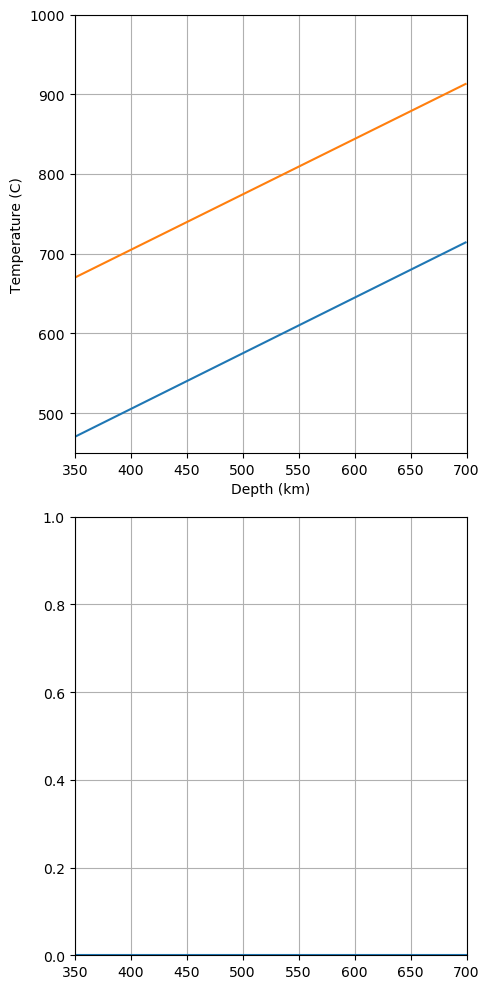

In [11]:
q_depths = np.arange(300e3, 700e3, 1e3)

q_Ts_warm = Tprofile_TS09_fig1_warm(q_depths)
q_Ts_cold = Tprofile_TS09_fig1_cold(q_depths)

fig = plt.figure(tight_layout=True, figsize=(5, 10))
gs = gridspec.GridSpec(2, 1)
ax = fig.add_subplot(gs[0, 0])

ax.plot(q_depths/1e3, q_Ts_cold - 273.15)
ax.plot(q_depths/1e3, q_Ts_warm - 273.15)

ax.set_xlim([350, 700])
ax.set_ylim([450, 1000])

ax.set_xlabel("Depth (km)")
ax.set_ylabel("Temperature (C)")

ax.grid()


# calculate MO kinetics
# Parameters for equilibrium at the 410 km depth phase boundary
dPdh = 30e6/1e3 # Pa/m
d_ol = 5e-3 # m
    
# Equilibrium pressure and corresponding depths
v_h = 0.05/year # m / s

q_ts = q_depths / v_h
q_Ps = (q_depths - 410e3)*dPdh + PT410["P"]
q_depths_eq_cold = 410e3 + (q_Ts_cold - PT410["T"]) * PT410["cl"] / dPdh  # Equilibrium depth (m)

q_growth_rate_cold = growth_rate_tetzlaff_schmeling_09(q_Ts_cold, q_Ps, q_depths, q_depths_eq_cold)
V_cold = MO_Vfraction_classic(q_growth_rate_cold, q_ts, d_ol)

# Plot the wd contents
ax1 = fig.add_subplot(gs[1, 0])

ax1.plot(q_depths/1e3, V_cold)
ax1.set_xlim([350, 700])
ax1.set_ylim([0.0, 1.0])

ax1.grid()


plt.show()

# Kinetics from DaBler etal., 1996 and used in Yoshioka etal., 2015

## Nucleation Theory

(Supplementary Material: Put the final equation and the formula of $\Delta G_{c}$ here)

The nucleation rate is expressed as:

$$
I = K_0 T \exp\left(-\frac{\Delta H_a + P V^*}{RT}\right) \exp\left(-\frac{\Delta G^*}{kT} \right)
$$

$$
K_0 = \frac{N k}{h} = \frac{1.75 \times 10^{28} \times 1.38 \times 10^{-23}}{6.626 \times 10^{-34}} \approx 3.65 \times 10^{38}~\mathrm{K \cdot s^{-1} \cdot m^{-3}}
$$

The critical Gibbs free energy $\Delta G^*$  varied by assumptions of homogenous nucleation and heterogenous nucleation:$\Delta G_{c}$ is the change in total Gibbs free energy for homogeneous nucleation:

$$
\Delta G_{hom}^* = \dfrac{16\pi^2 \gamma^3V_m^2}{3\left(\Delta G_d + \epsilon\right)^2}
$$

$$
\Delta G_{het}^* = f_s \Delta G_{hom}^*
$$

where $\gamma$ is the surface energy from forming the spinel structure from olivine. $V_m$ is the molar volume of spinel, and $f_s$ is a shape factor decreasing the value of the critical free energy change from the homogenous value when heterogenous nucleation effectively wets the grain boundary and lowers the total amount of surface energy 

In [12]:
# In this notebook, we import this function from the metastable.py script
# Add the origina function here

# def nucleation_rate(P, T, P_eq):
#     """
#     Compute the nucleation rate using Equation (10) from Yoshioka et al. (2015).
    
#     Parameters:
#     - T (float): Temperature in Kelvin.
#     - P (float): Pressure in Pa
#     - delta_G_v (float): Free energy change per volume in J/m^3.

#     Constants
#     - gamma (float): Surface energy in J/m^2 (default: 0.0506).
#     - K0 (float): Pre-exponential factor in s^-1 m^-2 K^-1 (default: 3.54e38).
#     - Q_a (float): Activation energy for growth in J/mol (default: 355e3).
#     - k (float): Boltzmann constant in J/K (default: 1.38e-23).
#     - R (float): Universal gas constant in J/(mol*K) (default: 8.314).
#     - dV_ol_wd (float): difference in mole volume between phase.
#     - V_initial (float): for olivine, estimation at 410 km, mole volume
    
#     Returns:
#     - I (float): Nucleation rate in s^-1 m^-2.
#     """
#     gamma=0.0506; K0=3.54e38; dH_a=344e3; V_star=4e-6; k=1.38e-23; R=8.314
#     dV_ol_wd = 2.4e-6; V_initial = 35.17e-6

#     if type(P) in [float, np.float64]:
#         assert(P >= P_eq)
#     elif type(P) == np.ndarray:
#         assert(np.min(P - P_eq) >= 0.0)
#     else:
#         raise TypeError("P must be float or ndarray")

#     delta_G_v = dV_ol_wd / V_initial * (P - P_eq)

#     # print("P_eq = %.2f GPa, dGr_vs = %.4e" % (P_eq/1e9, delta_G_v)) # debug

#     # Compute the homogeneous nucleation activation energy
#     delta_G_hom = (16 * np.pi * gamma**3) / (3 * (delta_G_v)**2)
    
#     # Compute the nucleation rate
#     Q_a = dH_a + P * V_star 
#     I = K0 * T * np.exp(-delta_G_hom / (k * T)) * np.exp(-Q_a / (R * T))
    
#     return I

## Site saturation

(Supplementary Material: Put the equation of site saturation and the nondimensionalize number for time here)

The time of site saturation is defined as:
$$t_s =  \left(I_s(P, T) Y(P, T)^2 \right)^{-1/3} = \left(\frac{I_v(P, T) Y(P, T)^2}{S_0} \right)^{-1/3}$$
Before site saturation ($t < t_s$), both nucleation and grain growth contribute to the transformation kinetics. After site saturation ($t > t_s$), nucleation becomes ineffective.

Additionally, time is nondimensionalized as:
$$t = \frac{L^2}{\kappa} \tau$$
where $L$ is a characteristic length scale (taken as 100~km) and $\kappa$ is the thermal diffusivity.

In [13]:
# def calculate_sigma_s(I_PT, Y_PT, d_0, **kwargs):
#     """
#     Calculate the dimensionless time (sigma_s) for the phase transformation process.

#     Parameters:
#     - I_PT (float): Nucleation rate as a function of pressure and temperature (s^-1 m^-3).
#     - Y_PT (float): Growth rate as a function of pressure and temperature (m/s).
#     - d_0 (float): Grain size of olivine (m).

#     Returns:
#     - sigma_s (float): Dimensionless time for site saturation.
#     """
#     kappa = kwargs.get("kappa", 1e-6) # Thermal diffusivity (m^2/s).
#     D = kwargs.get("D", 100e3) # slab thickness
#     # Compute the dimensionless time
#     sigma_s = (kappa / D**2) * ((I_PT * Y_PT**2 * d_0) / 6.7)**(-1/3)
#     return sigma_s


## Equation (19): Avrami Number Calculation

We follow by defining the Avrami number as

$$
Av = \left(\frac{D^2}{\kappa}\right)^4 \cdot I_{max}(P, T) Y_{max}^3(P, T)
$$

In [14]:
# def calculate_avrami_number(I_max, Y_max, **kwargs):
#     """
#     Calculate the Avrami number (Av) using the corrected Equation (19).
    
#     Parameters:
#     - I_max (float): Maximum nucleation rate in s^-1 m^-2.
#     - Y_max (float): Maximum growth rate in m/s.
    
#     Returns:
#     - Av (float): Avrami number (dimensionless).
#     """
#     kappa = kwargs.get("kappa", 1e-6) # Thermal diffusivity (m^2/s).
#     D = kwargs.get("D", 100e3) # slab thickness
#     # Compute the Avrami number
#     Av = (D**2 / kappa)**4 * I_max * Y_max**3
#     return Av

## Kinetic equations

(Supplementary Material: put the extended volume fraction and the kinetic equations here; screenshot a non-dimensional equation.)

In this system, new grains nucleate at the surface of existing grains and grow kinetically.
This leads to an increase in the so-called extended volume fraction $\tilde{V}$, which assumes no overlap between grains.
The true volume fraction $V$ is related to $\tilde{V}$ through the transformation (Avrami,1941):
$$
V = 1 - \exp\left(-\tilde{V}\right)
$$
$$
\frac{d\tilde{V}}{dt} = 4 S Y(t), \qquad t < t_s
$$
$$
\frac{dS}{dt} = \pi D Y(t)
$$
$$
\frac{dD}{dt} = 2 N Y(t)
$$
$$
\frac{dN}{dt} = I_v
$$

After site saturation ($t > t_s$), nucleation becomes ineffective, and the extended volume fraction evolves according to:
$$
\frac{d\tilde{V}}{dt} = S_0 Y(P, T)
$$

where $S$ is the total grain area per unit volume, $D$ is the total grain size per unit volume, and $N$ is the number of new grains per unit volume.

![](./figure/nondimensional_1.png)

Where:
- \(X_3(s)\), \(X_2(s)\), \(X_1(s)\), \(X_0(s)\): Represent the total grain volume, total grain area, total grain diameter, and number of grains, respectively.
- \(Av\): Avrami number, defined as $Av = \frac{D^2}{j} \cdot I_{max}(P, T) Y_{max}^3(P, T)$.
- \(Y'(s)\): Dimensionless growth rate.
- \(I'(s)\): Dimensionless nucleation rate.

Note
- I use the name "X_array" for the original array of [$\tilde{V}$, S, D, N], and the name "X_array_nd" for the nondimensionalized array ". This usage is consistent managed in all the code blocks.

## Plot the summary of nucleation rate, growth rate and saturation time

In [15]:
plot_analysis = False

if plot_analysis:

    # parameters for kinetics 
    nucleation_type = 1 # 0 - volumetric; 1 - interface
    d0 = 1e-2 # m, grain size

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator

    # initiate the kinetics class 
    _constants, _ = Meta.get_kinetic_constants(nucleation_type)
    pTKinetics = Meta.PTKinetics(_constants)

    # directory to save results
    o_dir = os.path.join(root_path, results_dir, "plot_analysis")

    if not os.path.isdir(o_dir):
        os.mkdir(o_dir)
    
    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 2.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (11.0, 16.0)
    x_lim3 = (0.4, 1.1)
    x_lim5 = (2.0, 4.0)
    x_tick_interval = 1.0   # tick interval along x
    x_tick_interval3 = 0.1   # tick interval along x
    x_tick_interval5 = 0.5
    y_lim = (-20.0, 30.0)
    y_lim2 = (-15.0, -5.0)
    y_lim3 = (-20.0, 30.0)
    y_lim4 = (-15.0, -5.0)
    y_lim5 = (-20.0, 30.0)
    y_lim6 = (-15.0, -5.0)
    y_tick_interval = 5.0  # tick interval along y
    y_tick_interval2 = 1.0  # tick interval along y
    y_tick_interval3 = 5.0
    y_tick_interval4 = 1.0
    y_tick_interval5 = 5.0
    y_tick_interval6 = 1.0
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Constants:
    #   T: constant temperature in rates vs P plot
    #   P: constant pressure in rates vs T plot
    #   Coh: constant Coh
    # T = 9.8426e+02; P = 1.1053e10
    T = 1173.2; P = 14.0e9
    Coh = 150.0  # Concentration of water in wt.ppm H2O

    kappa = 1e-6 # m^2/s
    D = 100e3 # m
    d0 = 0.01 # m, grain size of olivine, assume this to convert to volumetric rate.

    # Visualization of growth rate variations
    fig, axes = plt.subplots(1, 3, tight_layout=True, figsize=(3*8*scaling_factor, 6*scaling_factor))

    # Plot nondimentional time vs Pressure
    ax1 = axes[0]

    Ps = np.arange(10e9, 17e9, 0.1e9)  # Pressure range in Pascals
    Ts = np.full(Ps.shape, T)
    Ps_eq = PT410["P"] + (Ts - PT410["T"])*PT410["cl"]
    Ts_eq = PT410["T"] + (Ps - PT410["P"])/PT410["cl"]
    # Ps_eq = np.full(Ps.shape, PT410["P"])

    nucleation_rate = np.zeros(Ps.shape) # derive nucleation rate
    mask = Ps > Ps_eq

    if pTKinetics.nucleation_type == 0:
        nucleation_rate[mask] = pTKinetics.nucleation_rate(Ps[mask], Ts[mask], Ps_eq[mask], Ts_eq[mask])
    elif pTKinetics.nucleation_type == 1:
        nucleation_rate[mask] = 6.7/d0 * pTKinetics.nucleation_rate(Ps[mask], Ts[mask], Ps_eq[mask], Ts_eq[mask])
    else:
        raise NotImplementedError("Value of nucleation type needs to be 0 or 1.")

    growth_rate = np.zeros(Ps.shape)
    growth_rate[mask] = pTKinetics.growth_rate(Ps[mask], Ts[mask], Ps_eq[mask], Ts_eq[mask], Coh)  # calculate growth rate

    sigma_s = Meta.calculate_sigma_s(nucleation_rate, growth_rate, d0)

    ax1.plot(Ps / 1e9, np.log10(nucleation_rate), label="Nucleation Rate", color=default_colors[0]) # Plot nucleation rate on ax1
    ax1.set_xlabel("Pressure (GPa)")
    ax1.set_ylabel(r"log10($I_v$) ($m^{-3}s^{-1}$)", color=default_colors[0])
    ax1.tick_params(axis='y', labelcolor=default_colors[0])
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)

    P_eq = PT410["P"] + (T - PT410["T"])*PT410["cl"]
    ax1.axvline(x=P_eq / 1e9, color="black", linestyle="--", label=r"$P_{410}$") # Add a vertical line at PT410["P"]

    ax2 = ax1.twinx() # Create a secondary x-axis for growth rate
    ax2.plot(Ps / 1e9, np.log10(growth_rate), label="Growth Rate (log)", color=default_colors[1])
    ax2.set_ylabel("log10(Y) (m/s)", color=default_colors[1])
    ax2.tick_params(axis='y', labelcolor=default_colors[1])
    ax2.set_ylim(y_lim2)

    ax1.set_title("T = %.1f K, Coh = %.1f ppm" % (T, Coh))

    ax1.grid()
    

    # Plot rates vs T
    ax3 = axes[1]
    
    T_invert = np.arange(0.4, 1.1, 0.01)  # 1000/T range
    Ts_1 = 1000.0 / T_invert  # Temperature in Kelvin
    P_array = np.ones(Ts_1.shape) * P # make an array before passing to function
    
    Ps_eq_1 = PT410["P"] + (Ts_1 - PT410["T"])*PT410["cl"]
    Ts_eq_1 = PT410["T"] + (P_array - PT410["P"])/PT410["cl"]

    nucleation_rate_1 = np.zeros(Ts_1.shape)

    mask = (P_array > Ps_eq_1) # compute mask before passing to function

    if pTKinetics.nucleation_type == 0:
        nucleation_rate_1[mask] = pTKinetics.nucleation_rate(P_array[mask], Ts_1[mask], Ps_eq_1[mask], Ts_eq_1[mask])
    elif pTKinetics.nucleation_type == 1:
        nucleation_rate_1[mask] = 6.7/d0 * pTKinetics.nucleation_rate(P_array[mask], Ts_1[mask], Ps_eq_1[mask], Ts_eq_1[mask])
    else:
        raise NotImplementedError("Value of nucleation type needs to be 0 or 1.")
    
    ax3.plot(T_invert, np.log10(nucleation_rate_1), color=default_colors[0])
    ax3.set_xlim(x_lim3)
    ax3.set_ylim(y_lim3)
    ax3.set_xlabel("1000/T (K)")
    ax3.set_ylabel(r"log10($I_v$) ($m^{-3}s^{-1}$)", color=default_colors[0])
    ax3.tick_params(axis='y', labelcolor=default_colors[0])

    # ax3.set_ylim(y_lim3)

    T_eq_1 = PT410["T"] + (P - PT410["P"])/PT410["cl"]
    ax3.axvline(x=1000.0 / T_eq_1, color="black", linestyle="--", label=r"$T_{410}$") # Add a vertical line at PT410["P"]

    ax4 = ax3.twinx() # Plot growth rate vs Temperature
    
    growth_rate_1 = np.zeros(Ts_1.shape)
    growth_rate_1[mask] = pTKinetics.growth_rate(P_array[mask], Ts_1[mask], Ps_eq_1[mask], Ts_eq_1[mask], Coh)
    ax4.plot(T_invert, np.log10(growth_rate_1), color=default_colors[1])
    ax4.set_ylabel("log10(Y) (m/s)", color=default_colors[1])
    ax4.set_ylim(y_lim4)
    ax4.tick_params(axis='y', labelcolor=default_colors[1])
    
    ax3.grid()

    ax3.set_title("P = %.2f GPa, Coh = %.1f ppm" % (P/1e9, Coh))

    # Plot rates vs Coh
    ax5 = axes[2]
    
    log10_Cohs = np.arange(2, 4, 0.05)  # Logarithmic OH content range
    Cohs = 10**log10_Cohs  # OH content in wt.ppm H2O

    Ts_2 = np.full(Cohs.shape, T)
    Ps_2 = np.full(Cohs.shape, P)
    Ps_eq_2 = np.full(Cohs.shape, PT410["P"] + (T - PT410["T"])*PT410["cl"]) 
    Ts_eq_2 = np.full(Cohs.shape, PT410["T"] + (P - PT410["P"])/PT410["cl"])
    
    growth_rate_2 = pTKinetics.growth_rate(Ps_2, Ts_2, Ps_eq_2, Ts_eq_2, Cohs)

    if pTKinetics.nucleation_type == 0:
        nucleation_rate_2 = pTKinetics.nucleation_rate(Ps_2, Ts_2, Ps_eq_2, Ts_eq_2)
    elif pTKinetics.nucleation_type == 1:
        nucleation_rate_2 = 6.7/d0 * pTKinetics.nucleation_rate(Ps_2, Ts_2, Ps_eq_2, Ts_eq_2)
    else:
        raise NotImplementedError("Value of nucleation type needs to be 0 or 1.")

    # print("nucleation_rate_2: ", nucleation_rate_2) # debug
    
    ax5.plot(np.log10(Cohs), np.log10(nucleation_rate_2), color=default_colors[0])
    ax5.set_xlim(x_lim5)
    ax5.set_ylim(y_lim5)
    ax5.set_xlabel(r"log10($C_{OH}$) (ppm H / Si)") 
    ax5.set_ylabel(r"log10($I_v$) ($m^{-3}s^{-1}$)", color=default_colors[0])
    ax5.tick_params(axis='y', labelcolor=default_colors[0])
    
    ax6 = ax5.twinx() # Plot growth rate vs Temperature
    ax6.plot(np.log10(Cohs), np.log10(growth_rate_2), color=default_colors[1])
    ax6.set_ylabel(r"log10(Y) (m/s)", color=default_colors[1])
    ax6.tick_params(axis='y', labelcolor=default_colors[1])
    ax6.set_ylim(y_lim6)

    ax5.set_title("T = %.1f K, P = %.2f GPa" % (T, P/1e9))

    ax1.xaxis.set_major_locator(MultipleLocator(x_tick_interval)) # set ticks
    ax1.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))
    
    ax2.yaxis.set_major_locator(MultipleLocator(y_tick_interval2))
    ax2.yaxis.set_minor_locator(MultipleLocator(y_tick_interval2/(n_minor_ticks+1)))
    
    ax3.xaxis.set_major_locator(MultipleLocator(x_tick_interval3))
    ax3.xaxis.set_minor_locator(MultipleLocator(x_tick_interval3/(n_minor_ticks+1)))
    ax3.yaxis.set_major_locator(MultipleLocator(y_tick_interval3))
    ax3.yaxis.set_minor_locator(MultipleLocator(y_tick_interval3/(n_minor_ticks+1)))
    
    ax4.yaxis.set_major_locator(MultipleLocator(y_tick_interval4))
    ax4.yaxis.set_minor_locator(MultipleLocator(y_tick_interval4/(n_minor_ticks+1)))
    
    ax5.xaxis.set_major_locator(MultipleLocator(x_tick_interval5)) # set ticks
    ax5.xaxis.set_minor_locator(MultipleLocator(x_tick_interval5/(n_minor_ticks+1)))
    ax5.yaxis.set_major_locator(MultipleLocator(y_tick_interval5))
    ax5.yaxis.set_minor_locator(MultipleLocator(y_tick_interval5/(n_minor_ticks+1)))
    
    ax6.yaxis.set_major_locator(MultipleLocator(y_tick_interval6))
    ax6.yaxis.set_minor_locator(MultipleLocator(y_tick_interval6/(n_minor_ticks+1)))

    ax5.grid()

    for spine in ax.spines.values(): 
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    
    # save outputs
    file_out = os.path.join(o_dir, "Yoshioka_2015_rates_P_%.1fGPa_T_%.1fK_Coh_%.1f_nu_%d.pdf" % (P/1e9, T, Coh, pTKinetics.nucleation_type))
    fig.savefig(file_out)
    print("Saved figure: %s" % file_out)

    # Reset rcParams to defaults

    rcdefaults()

In [16]:
if plot_analysis:

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 2.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    
    x_lim = (11.0, 16.0)
    x_lim3 = (0.5, 1.1)
    x_lim5 = (2.0, 4.0)
    y_lim = (-20.0, 20.0)
    y_lim1_1 = (-1.0, 1.0)
    y_lim3 = (-20.0, 20.0)
    y_lim3_1 = (-5.0, 5.0)
    y_lim5 = (-16.0, -11.0)
    y_lim5_1 = (-5.0, 5.0)
    x_tick_interval = 1.0   # tick interval along x
    x_tick_interval3 = 0.1   # tick interval along x
    y_tick_interval = 10.0
    y_tick_interval1_1 = 0.5
    y_tick_interval3 = 10.0
    y_tick_interval3_1 = 2.5
    y_tick_interval5 = 1.0
    y_tick_interval5_1 = 2.5
    
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })


    # initiate figure
    fig, axes = plt.subplots(1, 3, tight_layout=True, figsize=(3*8*scaling_factor, 6*scaling_factor))
    

    # Plot nondimentional time vs Pressure
    ax1 = axes[0] 
    ax1_1 = ax1.twinx()
    sigma_s = Meta.calculate_sigma_s(nucleation_rate, growth_rate, d0, kappa=kappa, D=D)
    t_g = d0 / 6.7 / growth_rate

    ax1.plot(Ps / 1e9, np.log10(sigma_s*D*2.0/kappa/year), color=default_colors[0])
    ax1_1.plot(Ps / 1e9, np.log10(t_g/year), color=default_colors[1])
    
    ax1.axvline(x=P_eq / 1e9, color="black", linestyle="--", label=r"$P_{eq}$") # Add a vertical line at PT410["P"]

    ax1.grid()

    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)
    
    # ax1_1.set_ylim(y_lim1_1)
    
    ax1.set_xlabel("Pressure (GPa)")
    ax1.set_ylabel("log (Saturation Time) (year)", color=default_colors[0])
    ax1_1.set_ylabel("log (Growth Time) (year)", color=default_colors[1])

    ax1.tick_params(axis='y', labelcolor=default_colors[0])
    ax1_1.tick_params(axis='y', labelcolor=default_colors[1])

    ax1.set_title("T = %.1f K, Coh = %.1f ppm" % (T, Coh))
    
    
    # Plot nondimentional time vs Temperature
    
    ax3 = axes[1] 
    ax3_1 = ax3.twinx()

    sigma_s_1 = Meta.calculate_sigma_s(nucleation_rate_1, growth_rate_1, d0, kappa=kappa, D=D)
    t_g_1 = d0 / 6.7 / growth_rate_1
    
    ax3.plot(T_invert, np.log10(sigma_s_1*D*2.0/kappa/year), color=default_colors[0])
    ax3_1.plot(T_invert, np.log10(t_g_1/year), color=default_colors[1])
    ax3.axvline(x=1000.0 / T_eq_1, color="black", linestyle="--", label=r"$T_{eq}$") # Add a vertical line at PT410["P"]
    
    ax3.set_xlim(x_lim3)
    ax3.set_ylim(y_lim3)
    ax3_1.set_ylim(y_lim3_1)

    ax3.grid()
    
    ax3.set_xlabel("1000/T (K)")
    ax3.set_ylabel("log (Saturation Time) (year)", color=default_colors[0])
    ax3_1.set_ylabel("log (Growth Time) (year)", color=default_colors[1])
    
    ax3.tick_params(axis='y', labelcolor=default_colors[0])
    ax3_1.tick_params(axis='y', labelcolor=default_colors[1])
    
    ax3.set_title("P = %.2f GPa, Coh = %.1f ppm" % (P/1e9, Coh))

    # Plot nondimentional time vs Coh
    
    ax5 = axes[2] 
    ax5_1 = ax5.twinx()
    
    sigma_s_2 = Meta.calculate_sigma_s(nucleation_rate_2, growth_rate_2, d0, kappa=kappa, D=D)
    t_g_2 = d0 / 6.7 / growth_rate_2

    ax5.plot(np.log10(Cohs), np.log10(sigma_s_2*D*2.0/kappa/year), color=default_colors[0])
    ax5_1.plot(np.log10(Cohs), np.log10(t_g_2/year), color=default_colors[1])
    
    ax5.set_xlabel("log10(OH content) (wt. ppm H2O)") 
    ax5.set_ylabel("log (Saturation Time) (year)", color=default_colors[0])
    ax5_1.set_ylabel("log (Growth Time) (year)", color=default_colors[1])
    
    ax5.set_title("T = %.1f K, P = %.2f GPa" % (T, P/1e9))
    
    ax5.set_xlim(x_lim5)
    ax5.set_ylim(y_lim5)
    ax5_1.set_ylim(y_lim5_1)
    
    ax5.tick_params(axis='y', labelcolor=default_colors[0])
    ax5_1.tick_params(axis='y', labelcolor=default_colors[1])
    
    ax5.grid()
    
    # ax3.set_title("P = %.1f GPa, T = %.1f K" % (P / 1e9, T))


    # ax3.semilogy(Ps/1e9, sigma_s)
    # ax3.set_xlabel("Pressure (GPa)")
    # ax3.set_ylabel("Nondimentional Saturation Time")
    # ax3.grid()
    # ax3.set_xlim([13.0, 16.0])
    
    # ax3.axvline(x=PT410["P"] / 1e9, color="black", linestyle="--", label=r"$P_{410}$") # Add a vertical line at PT410["P"]

    ax1.xaxis.set_major_locator(MultipleLocator(x_tick_interval)) # set ticks
    ax1.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))
    
    ax1_1.yaxis.set_major_locator(MultipleLocator(y_tick_interval1_1))
    ax1_1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval1_1/(n_minor_ticks+1)))
    
    ax3.xaxis.set_major_locator(MultipleLocator(x_tick_interval3)) # set ticks
    ax3.xaxis.set_minor_locator(MultipleLocator(x_tick_interval3/(n_minor_ticks+1)))
    ax3.yaxis.set_major_locator(MultipleLocator(y_tick_interval3))
    ax3.yaxis.set_minor_locator(MultipleLocator(y_tick_interval3/(n_minor_ticks+1)))
    
    ax3_1.yaxis.set_major_locator(MultipleLocator(y_tick_interval3_1))
    ax3_1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval3_1/(n_minor_ticks+1)))
    
    ax5.xaxis.set_major_locator(MultipleLocator(x_tick_interval5)) # set ticks
    ax5.xaxis.set_minor_locator(MultipleLocator(x_tick_interval5/(n_minor_ticks+1)))
    ax5.yaxis.set_major_locator(MultipleLocator(y_tick_interval5))
    ax5.yaxis.set_minor_locator(MultipleLocator(y_tick_interval5/(n_minor_ticks+1)))
    
    ax5_1.yaxis.set_major_locator(MultipleLocator(y_tick_interval5_1))
    ax5_1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval5_1/(n_minor_ticks+1)))


    for spine in ax.spines.values(): 
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    
    # save outputs
    file_out = os.path.join(o_dir, "Yoshioka_2015_summary_P_%.1fGPa_T_%.1fK.pdf" % (P/1e9, T))
    fig.savefig(file_out)
    print("Saved figure: %s" % file_out)

    # Reset rcParams to defaults

    rcdefaults()

## Solve the kinetics at specific P, T conditions

All variables $X_0$, $X_1$, $X_2$, $X_3$ are advected with particles in our numerical simulation using ASPECT. The differential equations are solved with 4-th order Runge-Kutta method at every timestep to update the metastable kinetics.

Here we test the solution with prescribed P, T conditions.

### Solve the kinetics for a (P, T) condition

In [17]:
# Tips: look at the class definiition in file hamageolib/research/haoyuan_2d_subduction/metastable.py
is_solving_point = False

if is_solving_point:
    
    Ps = [14.0e9, 14.0e9, 14.0e9]
    Ts = [773.15, 873.15, 1173.15]
    Coh = 150.0 # ppm H2O
    d0 = 1e-2 # m, initial grain size

    nucleation_type = 1 # 0 - volumetric; 1 - surface

    # initiate the kinetics class 
    _, _constants1 = Meta.get_kinetic_constants(nucleation_type)
    Mo_Kinetics = Meta.MO_KINETICS(_constants1, post_process=["ts", "tg"])
    Mo_Kinetics.set_initial_grain_size(d0)

    # set P T condition for solution
    Mo_Kinetics.set_PT_eq(PT410['P'], PT410['T'], PT410['cl'])
    Mo_Kinetics.link_and_set_kinetics_model(Meta.PTKinetics)
    
    # Parameters for solver
    t_max = 10e6 * year # s
    n_t = 100
    n_span = 10

    result_array = []
    for i in range(len(Ps)):
        P = Ps[i]
        T = Ts[i]

        Mo_Kinetics.set_kinetics_fixed(P, T, Coh)

        # solve the kinetics
        with Mute():
            results = Mo_Kinetics.solve(P, T, t_max, n_t, n_span, debug=True)        

        # export result
        txt_file_path = os.path.join(results_dir, "solution_P%.2fGPa_T%.2fK.txt" % (P/1e9, T))
        with open(txt_file_path, 'w') as fout:
            np.savetxt(txt_file_path, results)
        print("Solution saved to %s" % txt_file_path)

        result_array.append(results)

Plot the results

In [18]:
if is_solving_point:

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 1e4)
    y_lim1 = (0.0, 1.0)
    y_lim2 = (-10.0, 10.0)
    x_tick_interval = 2e3   # tick interval along x
    y_tick_interval1 = 0.25  # tick interval along y
    y_tick_interval2 = 5.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    }) 
        
    fig, ax1 = plt.subplots(figsize=(8*scaling_factor, 5*scaling_factor), tight_layout=True)
    ax2 = ax1.twinx()
    
    for i in range(len(Ps)):

        P = Ps[i]
        T = Ts[i]

        # parse result for one P, T condition
        results = result_array[i]
        time = results[:, 0]
        total_grain_number = results[:, 1]
        total_grain_diameter = results[:, 2]
        volume = results[:, 5]
        extended_volume = results[:, 4]
        is_saturated_a = results[:, 6]
        time_saturated_a = results[:, 7]
        
        # find_average_grain_diameter
        total_grain_number_saturated_value = Mo_Kinetics.X_saturated[0]
        total_grain_diameter_saturated_value = Mo_Kinetics.X_saturated[1]
        extended_volume_saturated_value = Mo_Kinetics.X_saturated[3]

        # find_average_grain_diameter
        average_grain_diameter_saturated_value = total_grain_diameter_saturated_value / total_grain_number_saturated_value

        # find the critical radius
        critical_radius_value = Mo_Kinetics.compute_rc(P, T)

        # find where cite situation 
        indices = np.where(is_saturated_a == 1.0)[0]
        time_saturated_value = time_saturated_a[indices[0]]
        extended_volume_critial_saturated_value = 4 * np.pi / 3 * critical_radius_value**3.0 * total_grain_number_saturated_value
        
        print("P = %.4e GPa, T = %.4e K, ts: %.4e year, d: %.4e m, rc: %.4e m, extended volume: %.4e, extended volume by critical radius: %.4e"\
               % (P/1e9, T, time_saturated_value/year, average_grain_diameter_saturated_value, critical_radius_value, extended_volume_saturated_value, extended_volume_critial_saturated_value)) # debug
        # print(average_grain_diameter_saturated_value[-1], critical_radius_value)


        # Plot on the left y-axis
        ax1.plot(time/year/1e3, volume, color=default_colors[i], linewidth=4, label='Volume, P=%.2f Gpa, T=%.2f K' %(P/1e9, T))
        ax1.set_xlabel('Time (kyr)')
        ax1.set_ylabel('Volume', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        # Create twin axis for right y-axis
        if i == 0:
            _label = 'Extended Volume'
        else:
            _label = None

        ax2.plot(time/year/1e3, np.log10(extended_volume), color=default_colors[i], label=_label)
        ax2.set_ylabel('log(Extended Volume)', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # Optional: Add grid and title
        fig.suptitle('Volume and Extended Volume vs Time')
        ax1.grid(True)

        # Optional: Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')


        # Adjust spine thickness for this plot
        for spine in ax1.spines.values():
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # axis configuration
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim1)
    ax2.set_ylim(y_lim2)

    ax1.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax1.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval1))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval1/(n_minor_ticks+1)))
    
    ax2.yaxis.set_major_locator(MultipleLocator(y_tick_interval2))
    ax2.yaxis.set_minor_locator(MultipleLocator(y_tick_interval2/(n_minor_ticks+1)))

    # maintain a tight layout     
    plt.tight_layout()

    # show figure 
    plt.show()

    # save figure
    fig_path = os.path.join(results_dir, "metastable_illustration_nu_%d_d0_%2e_Coh_%.2e.pdf" % (nucleation_type, d0, Coh))
    fig.savefig(fig_path)
    print("Save figure %s" % fig_path)

    # Reset rcParams to defaults
    rcdefaults()


### Solve the kinetics for a grid

(Supplementary Material: description related to the diagram)

We calculate synthetic diagrams of kinetic conditions under the simplifying assumption that latent heat effects are neglected.
The volumetric nucleation rate and the grain growth rate are investigated within their respective ranges of dynamic significance.

We then plot contours of the site saturation timescale $t_s$ and the growth timescale $t_g$ (i.e $t_{0.5}$ assuming early site saturation). The diagram is divided into four categories based on kinetic regimes: M — metastable, G — growth-controlled kinetics, N — nucleation-controlled kinetics, and E — equilibrium transition, using the following criteria:

$$ M: \quad t_s > 100~\mathrm{Ma},\ t_g > 100~\mathrm{Ma} $$
$$ G: \quad t_s \leq t_g,\ \min\left(t_s, t_g\right) < 100~\mathrm{Ma} $$
$$ N: \quad t_s > t_g,\ \min\left(t_s, t_g\right) < 100~\mathrm{Ma} $$
$$ E: \quad t_s < 10~\mathrm{kyr},\ t_g < 10~\mathrm{kyr} $$

Contours of the Avrami number equal to 1 are also plotted.
These contours illustrate the balance between the diffusion timescale and the kinetic transition timescale.
The two different boundary thicknesses represent the characteristic thermal diffusion length scales: 100~km for the entire lithospheric plate (black dashed line) and 5~km for the effective boundary of the metastable olivine wedge (grey dashed line).

There are two types of process:
* serial: this runs with just one process. It has the advantage of reporting the progress. It could be used to estimate the running speed.
* parallel: this runs in parallel to save time.

In [19]:
import multiprocessing
from joblib import Parallel, delayed
import time

# Free parameters
t_max = 2e3 * year
# t_max = 10 * 1e6 * year # for plotting figure in the supplementary material
N_P = 201; N_T = 101 # resolution of P, T
n_t = 10; n_span = 20  # resolution of time

is_solving = False  # if we solve new dataset and merge to old ones

if is_solving:
    # Coh in ppm H2O
    # todo_para
    Coh = 150.0 # ppm H2O
    d0 = 1e-2 # m, grain size
    nucleation_type = 1

    ## set resolution of the grid
    N_t = n_t * n_span + 1 # total number in t dimension

    # Pressure in Pascals, Temperature in Kelvin, Time in seconds
    P_values = np.linspace(0.0, 30e9, N_P)  # global mesh
    T_values = np.linspace(273.15, 1873.15, N_T)
    
    # P_values = np.linspace(10e9, 15e9, 51)  # equilibrium bd
    # T_values = np.linspace(773.15, 1873.15, 56)
    
    # P_values = np.linspace(10e9, 30e9, 41)  # metastable bd
    # T_values = np.linspace(750, 1000.0, 51)

    t_values = np.linspace(0, t_max, n_t*n_span+1)     

    # Create a meshgrid
    T_grid, P_grid, t_grid = np.meshgrid(T_values, P_values, t_values, indexing="ij")
    V_grid = np.zeros(P_grid.shape)

    # initiate the class
    _, _constants1 = Meta.get_kinetic_constants(nucleation_type)
    Mo_Kinetics = Meta.MO_KINETICS(_constants1, post_process=["ts", "tg"])
    Mo_Kinetics.set_initial_grain_size(d0)

    Mo_Kinetics.set_PT_eq(PT410['P'], PT410['T'], PT410['cl'])
    Mo_Kinetics.link_and_set_kinetics_model(Meta.PTKinetics)

    # Function to solve for a given T, P
    def solve_metastable_kinetics(P, T, Coh, t_max, n_t, n_span, Mo_Kinetics):
        # if P < P_eq:
        #     return np.zeros(n_t * n_span, 7)
        Mo_Kinetics.set_kinetics_fixed(P, T, Coh)

        t_values = np.linspace(0, t_max, n_t*n_span+1)
        # compute the nucleation and growth rates
        Iv_values = np.zeros(n_t*n_span+1)
        Y_values = np.zeros(n_t*n_span+1)
        ts_values = np.zeros(n_t*n_span+1)
        tg_values = np.zeros(n_t*n_span+1)
        for i, t in enumerate(t_values): 
            Iv_values[i] = Mo_Kinetics.compute_Iv(t)
            Y_values[i] = Mo_Kinetics.compute_Y(t)
            ts_values[i] = Mo_Kinetics.compute_ts(t)
            tg_values[i] = Mo_Kinetics.compute_tg(t)


        # compute the Avrami number
        Av_values = np.zeros(n_t*n_span+1)
        Av_c_values = np.zeros(n_t*n_span+1)
        for i, t in enumerate(t_values): 
            Av_values[i] = Mo_Kinetics.compute_Av(t)
            Av_c_values[i] = Mo_Kinetics.compute_Av(t, D=5e3)

        # solve the ODEs
        results = Mo_Kinetics.solve(P, T, 0.0, t_max, n_t, n_span)

        # stack all results 
        results = np.hstack((results, Av_values[:, np.newaxis], Av_c_values[:, np.newaxis], Iv_values[:, np.newaxis],\
                             Y_values[:, np.newaxis], ts_values[:, np.newaxis], tg_values[:, np.newaxis]))
        return results

    # Parallelize computation
    start = time.time()

    # Precompute equilibrium pressures
    # P_eq_values = [Meta.compute_eq_P(Mo_Kinetics.PT_eq, T) for T in T_values]

    # Solve
    # V_grid = np.zeros(P_grid.shape)
    # for i in range(T_grid.shape[0]):
    #     for j in range(T_grid.shape[1]):
    #         V_array = solve_metastable_kinetics(P_grid[i, j, 0], T_grid[i, j, 0], Coh,t_max, n_t, n_span, Mo_Kinetics, P_eq_values[i])
    #         V_grid[i, j, :] = V_array
    #         sys.stdout.write("\rsolved %d / %d" % (i*T_grid.shape[1]+j, T_grid.shape[0]*T_grid.shape[1]-1)) # debug
    #         sys.stdout.flush()
    # sys.stdout.write("\nSolve Metastable Kinetics take %.2f s" % (end-start))
    # sys.stdout.flush()

    # Solve in parallel
    num_processes = multiprocessing.cpu_count()  # Print the number of available processes
    print(f"Number of available processes: {num_processes}")

    results_raw = Parallel(n_jobs=-1)(
        delayed(solve_metastable_kinetics)(
            P_grid[i, j, 0], T_grid[i, j, 0], Coh,t_max, n_t, n_span, Mo_Kinetics
        )
        for i in range(T_grid.shape[0]) for j in range(T_grid.shape[1])
    )

    # Convert results_raw to a structured grid
    grid_shape = (T_grid.shape[0], T_grid.shape[1])  # Grid size
    time_steps = results_raw[0].shape[0]  # Number of time steps
    num_columns = results_raw[0].shape[1]  # Number of variables

    results_array = np.array(results_raw)  # Convert list to NumPy array
    results_grid = results_array.reshape(*grid_shape, time_steps, num_columns)  # Reshape to grid

    # Access specific data
    V_grid = results_grid[:, :, :, 5]  # Extract column 0 across all grid points

    end = time.time()
    print("\nSolve Metastable Kinetics took %.2f s" % (end - start))

Next, P and T in the grid are flatten to a vector along with the result on volume, then these are parsed to a numpy 2-d array of "result".

In [20]:
if is_solving:
    # Convert to numpy object
    data_raw = []

    for i in range(T_grid.shape[0]):
        for j in range(T_grid.shape[1]):
            # Extract the pressure and temperature for this grid point
            P_value = P_grid[i, j, 0]
            T_value = T_grid[i, j, 0]
            
            # Extract the corresponding results
            result = results_raw[i * T_grid.shape[1] + j]  # Flattened indexing
            
            # Combine P, T with each row of the results
            for k in range(result.shape[0]):  # Iterate over time steps
                row = [P_value, T_value] + result[k].tolist()  # Combine P, T, and the result row
                data_raw.append(row)

    data_array = np.array(data_raw) # Convert the list of rows into a 2D NumPy array

    # Convert to pandas object
    columns = ["P", "T"] + Mo_Kinetics.result_columns + ["Av", "Av_c", "Iv", "Y", "ts", "tg"]

    new_data = pd.DataFrame(data_array, columns=columns)

Next, results are saved to a grid data. Here we first see if there is a previous file. If so, the data in the file is updated with new data points computed.

In [21]:
is_plot_solving_results = False
is_read_and_update = False

if is_solving and is_plot_solving_results:

    from datetime import datetime
    from shutil import copy

    # working directory and file
    current_results_dir = os.path.join(results_dir, "grid_data_05022025")
    if not os.path.isdir(current_results_dir):
        os.mkdir(current_results_dir)

    data_file = os.path.join(current_results_dir, "metastable_grid_data.parquet")
    data_file_csv = os.path.join(current_results_dir, "metastable_grid_data.csv")

    if is_read_and_update and os.path.isfile(data_file):
        # generate a backup
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        data_file_backup = os.path.join(current_results_dir, f"metastable_grid_data_{timestamp}.parquet")

        copy(data_file, data_file_backup)

        print("created backup file %s" % data_file_backup)

        data = pd.read_parquet(data_file)

        if is_solving:

            # Identify existing combinations of P and T in data
            existing_combinations = set(zip(data["P"], data["T"]))

            # Filter new_data to exclude rows with existing P and T combinations
            filtered_new_data = new_data[~new_data.apply(lambda row: (row["P"], row["T"]) in existing_combinations, axis=1)]

            # Merge the filtered new_data into data
            data = pd.concat([data, filtered_new_data], ignore_index=True)

    else:
        data = new_data
            
    # Save data
    data.to_parquet(data_file, index=False)
    data.to_csv(data_file_csv, index=False)

    print("saved parquet file %s" % data_file)
    print("saved csv file %s" % data_file_csv)

#### Plot the diagram

With the interpolation scheme, we define both a near-neighbor interpolation and a inverse distance weighting (IDW) interpolation.

In [22]:
def categorize_the_diagram(ts, tg):
    '''
    categorize the diagram from known time
    Inputs:
        ts - time for site situation
        tg - time for grain growth
    '''
    # assign a limit for metastability in geodynamic timescale 
    t_eq = 1e4* year
    t_meta = 1e8* year

    # switch between float and numpy objects
    if type(ts) in [float, np.float64]:
      if ts > t_meta and tg > t_meta:
          value = 0
      elif ts <= tg:
          value = 1
      else:
          value = 2 
    elif type(ts) == np.ndarray:
        # in case of a numpy array, first assign a mask
        value = np.full(ts.shape, 0, dtype=int)
        mask0 = (ts > t_meta) & (tg > t_meta)
        mask1 = ((ts < t_meta) | (tg < t_meta)) & (ts <= tg)
        mask2 = ((ts < t_meta) | (tg < t_meta)) & (ts > tg)
        mask3 = (ts < t_eq) & (tg < t_eq)
        value[mask1] = 1
        value[mask2] = 2
        value[mask3] = 3
    else:
        return NotImplementedError()

    return value

In [23]:
if is_plot_solving_results:

    from scipy.interpolate import NearestNDInterpolator

    ## for a global mesh
    N_P_1 = N_P
    N_T_1 = N_T
    P_values_1 = np.linspace(0.0, 30e9, N_P_1)  # Pressure in Pascals
    T_values_1 = np.linspace(273.15, 1873.15, N_T_1)  # Temperature in Kelvin

    # scaling factors
    P0 = 1e9 # Pa
    T0 = 100.0 # K
    t0 = 1000 * year # s

    # make a new grid
    T_grid_1, P_grid_1 = np.meshgrid(T_values_1, P_values_1)

    T_flat_1 = T_grid_1.flatten()
    P_flat_1 = P_grid_1.flatten()

    # compute equilibrium values
    P_eq_values_1 = Meta.compute_eq_P(Mo_Kinetics.PT_eq, T_values_1)

    # perform interpolation
    # V
    interpolator = NearestNDInterpolator(
        np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)),
        data["V"]
    )
    # Av
    interpolator_Av = NearestNDInterpolator(
        np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)),
        data["Av"]
    )
    # Av_c
    interpolator_Av_c = NearestNDInterpolator(
        np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)),
        data["Av_c"]
    )
    # Iv
    interpolator_Iv = NearestNDInterpolator(
        np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)),
        data["Iv"]
    )
    # Y
    interpolator_Y = NearestNDInterpolator(
        np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)),
        data["Y"]
    )
    # ts
    interpolator_ts = NearestNDInterpolator(
        np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)),
        data["ts"]
    )
    # tg
    interpolator_tg = NearestNDInterpolator(
        np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)),
        data["tg"]
    )


1. Plot the volumetric nucleation rate, grain growth rate and the Av number

In [24]:
if is_plot_solving_results:

    import matplotlib.colors as mcolors

    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 2.0 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (400.0, 1800.0)
    x_tick_interval = 200.0   # tick interval along x
    y_lim = (10.0, 30.0)
    y_tick_interval = 5.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    idx = np.arange(0, N_P * N_T * N_t, N_t)

    # Iv_grid = data["Iv"].to_numpy()[np.ix_(idx)].reshape(T_grid_1.shape)
    # Y_grid = data["Y"].to_numpy()[np.ix_(idx)].reshape(T_grid_1.shape)
    # Av_grid = data["Av"].to_numpy()[np.ix_(idx)].reshape(T_grid_1.shape)

    # perform interpolation
    Iv_flat_1 = interpolator_Iv(T_flat_1/T0, P_flat_1/P0, np.full(T_flat_1.shape, 0.0))
    Iv_grid = Iv_flat_1.reshape(T_grid_1.shape)
    Y_flat_1 = interpolator_Y(T_flat_1/T0, P_flat_1/P0, np.full(T_flat_1.shape, 0.0))
    Y_grid = Y_flat_1.reshape(T_grid_1.shape)
    Av_flat_1 = interpolator_Av(T_flat_1/T0, P_flat_1/P0, np.full(T_flat_1.shape, 0.0))
    Av_grid = Av_flat_1.reshape(T_grid_1.shape)
    Av_c_flat_1 = interpolator_Av_c(T_flat_1/T0, P_flat_1/P0, np.full(T_flat_1.shape, 0.0))
    Av_c_grid = Av_c_flat_1.reshape(T_grid_1.shape)
    ts_flat_1 = interpolator_ts(T_flat_1/T0, P_flat_1/P0, np.full(T_flat_1.shape, 0.0))
    ts_grid = ts_flat_1.reshape(T_grid_1.shape)
    tg_flat_1 = interpolator_tg(T_flat_1/T0, P_flat_1/P0, np.full(T_flat_1.shape, 0.0))
    tg_grid = tg_flat_1.reshape(T_grid_1.shape)

    # Create subplots
    fig = plt.figure(figsize=(14*scaling_factor, 14*scaling_factor), tight_layout=True)
    gs = gridspec.GridSpec(2, 2)

    # Plot Iv
    ax = fig.add_subplot(gs[0, 0])
    contours = ax.contour(T_grid_1, P_grid_1 / 1e9, np.log10(Iv_grid), (-10, 0, 10, 20), vmin=-20, vmax=30, colors='k', linestyles="-")
    ax.clabel(contours, fmt='%d', colors='k')
    contours_1 = ax.contour(T_grid_1, P_grid_1 / 1e9, np.log10(Y_grid), (-14, -12, -10, -8, -6, -4), colors='c', linestyles="-")
    ax.clabel(contours_1, fmt='%d', colors='c')
    ax.plot(T_values_1, P_eq_values_1/1e9, "-.")  # plot the equilibrium phase boundary

    ax.grid()

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.invert_yaxis()

    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Pressure (GPa)")
    ax.set_title(r"$I_v$ and $Y$")

    # Plot ts, tg.
    # Then categorize the diagrame based on these values
    # Also append the controus of Av
    ax = fig.add_subplot(gs[0, 1])
    contours = ax.contour(T_grid_1, P_grid_1 / 1e9, np.log10(ts_grid/year), (2, 4, 6, 8), colors='k', linestyles="-")
    ax.clabel(contours, fmt='%d', colors='k')
    contours = ax.contour(T_grid_1, P_grid_1 / 1e9, np.log10(tg_grid/year), (2, 4, 6, 8), colors='c', linestyles="-")
    ax.clabel(contours, fmt='%d', colors='c')
    ax.plot(T_values_1, P_eq_values_1/1e9, "-.")  # plot the equilibrium phase boundary

    category_grid = categorize_the_diagram(ts_grid, tg_grid)
    norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)
    cmap = plt.get_cmap('Pastel1', 4)
    cmesh = ax.pcolormesh(T_grid_1, P_grid_1 / 1e9, category_grid, cmap=cmap, norm=norm, shading='auto')
    # cbar = plt.colorbar(cmesh, ax=ax, ticks=[0, 1, 2, 3])

    contours = ax.contour(T_grid_1, P_grid_1 / 1e9, np.log10(Av_grid), (0), colors='k', linestyles="--")
    # ax.clabel(contours, fmt='%d', colors='k')
    contours = ax.contour(T_grid_1, P_grid_1 / 1e9, np.log10(Av_c_grid), (0), colors='tab:gray', linestyles="--")
    # ax.clabel(contours, fmt='%d', colors='c')

    ax.grid()

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.invert_yaxis()

    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Pressure (GPa)")
    ax.set_title(r"$t_s$ and $t_g$")

    # fig.colorbar(h4, ax=ax, label="ts")

    # Plot Av
    ax = fig.add_subplot(gs[1, 0])
    contours = ax.contour(T_grid_1, P_grid_1 / 1e9, np.log10(Av_grid), (-4, 0, 4), colors='k', linestyles="-")
    ax.clabel(contours, fmt='%d', colors='k')
    contours = ax.contour(T_grid_1, P_grid_1 / 1e9, np.log10(Av_c_grid), (-4, 0, 4), colors='c', linestyles="-")
    ax.clabel(contours, fmt='%d', colors='c')
    ax.plot(T_values_1, P_eq_values_1/1e9, "-.")  # plot the equilibrium phase boundary

    ax.grid()

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.invert_yaxis()

    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Pressure (GPa)")
    ax.set_title("Av")
    # fig.colorbar(h3, ax=ax, label="Av")

    fig_path = os.path.join(results_dir, "Mo_kinetics_diagram_nu_%d_Coh_%.2f_d_%.2f.pdf" % (Mo_Kinetics.Kinetics.nucleation_type, Coh, d0))
    fig.savefig(fig_path)

    print("Save figure: %s" % fig_path)

    # Reset rcParams to defaults
    rcdefaults()

2. Inspect a given time

Then, we plot at a given time

In [25]:
if is_plot_solving_results:

    from scipy.ndimage import zoom

    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (400.0, 1800.0)
    x_tick_interval = 200.0   # tick interval along x
    y_lim = (10.0, 30.0)
    y_tick_interval = 5.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # constant time
    t_constant = 1e3*year
    # t_constant = 5e4*year     # Time in seconds, for plotting figure in supplementary material

    # perform interpolation 1: near neighber
    V_flat_1 = interpolator(T_flat_1/T0, P_flat_1/P0, np.full(T_flat_1.shape, t_constant/t0))

    # # perform interpolation 2: IDW
    # V_flat = idw_interpolation(np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)), data["V"],\
    #                             np.column_stack((T_flat / T0, P_flat / P0, np.full(T_flat.shape, t_constant / t0))), k=5, power=2)

    # reshape to V_grid
    V_grid = V_flat_1.reshape(T_grid_1.shape)

    # Upsample the V_grid for smoothing
    # Define finer grid based on zoom factor
    zoom_factor = 2  # Upscaling factor
    V_smooth_grid = zoom(V_grid, zoom_factor, order=3)  # Cubic spline interpolation

    T_fine = np.linspace(np.min(T_values_1), np.max(T_values_1), V_smooth_grid.shape[1])
    P_fine = np.linspace(np.min(P_values_1), np.max(P_values_1), V_smooth_grid.shape[0])
    T_fine_grid, P_fine_grid = np.meshgrid(T_fine, P_fine)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14*scaling_factor, 6*scaling_factor), constrained_layout=True)

    # Plot original coarse grid
    h1 = axes[0].pcolormesh(T_grid_1, P_grid_1 / 1e9, V_grid, cmap="viridis", shading="auto")
    axes[0].contour(T_grid_1, P_grid_1 / 1e9, V_grid, (0.5, 0.99), colors=['tab:gray', 'k'], linestyles="-")
    axes[0].plot(T_values_1, P_eq_values_1/1e9, "-.")  # plot the equilibrium phase boundary

    axes[0].grid()

    axes[0].set_xlim(x_lim)
    axes[0].set_ylim(y_lim)

    axes[0].xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    axes[0].xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    axes[0].yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    axes[0].yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    axes[0].invert_yaxis()

    axes[0].set_xlabel("Temperature (K)")
    axes[0].set_ylabel("Pressure (GPa)")
    axes[0].set_title("Original Coarse Grid")
    fig.colorbar(h1, ax=axes[0], label="V")

    # Plot smoothed grid
    h2 = axes[1].pcolormesh(T_fine_grid, P_fine_grid / 1e9, V_smooth_grid, cmap="viridis", shading="auto", vmin=0.0, vmax=1.0)
    axes[1].contour(T_fine_grid, P_fine_grid / 1e9, V_smooth_grid,\
                    (0.5, 0.99), # 1 - exp(-1), 1 - exp(-2)
                    colors=['tab:gray', 'k'], linestyles="-")
    axes[1].plot(T_values_1, P_eq_values_1/1e9, "-.")  # plot the equilibrium phase boundary

    axes[1].grid()

    axes[1].set_xlim(x_lim)
    axes[1].set_ylim(y_lim)

    axes[1].xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    axes[1].xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    axes[1].yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    axes[1].yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    axes[1].invert_yaxis()

    axes[1].set_xlabel("Temperature (K)")
    axes[1].set_ylabel("Pressure (GPa)")
    axes[1].set_title("Smoothed Grid (Upsampled)")
    fig.colorbar(h2, ax=axes[1], label="V")

    # Adjust spine thickness for this plot
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    plt.show()

    # save figure
    fig_path = os.path.join(results_dir, "PTV_nu_%d_Coh_%.2e_d_%.2e_t%.2f.pdf" % (Mo_Kinetics.Kinetics.nucleation_type, Coh, d0, t_constant/1e6/year))
    fig.savefig(fig_path)

    print("Saved figure %s" % fig_path)

    # fig_path_pdf = os.path.join(results_dir, "PTV_t%.2f.pdf" % (t_constant/1e6/year))
    # fig.savefig(fig_path_pdf)

    # print("Saved figure %s" % fig_path_pdf)


    # Reset rcParams to defaults

    rcdefaults()

3. Then we handle plots of contours at different time step

In [26]:
if is_plot_solving_results:

    from scipy.ndimage import zoom
    from matplotlib.lines import Line2D

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (400.0, 1800.0)
    x_tick_interval = 200.0   # tick interval along x
    y_lim = (10.0, 30.0)
    y_tick_interval = 5.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })


    # constant time
    ts = np.array([5e4, 1e5, 1e6]) * year

    # Create subplots
    fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

    ax.plot(T_values_1, P_eq_values_1/1e9, "-.")  # plot the equilibrium phase boundary

    # Initialize a list for legend entries
    legend_lines = []
    legend_labels = []

    for i, t_constant in enumerate(ts):

        # perform interpolation 1: near neighber
        V_flat_1 = interpolator(T_flat_1/T0, P_flat_1/P0, np.full(T_flat_1.shape, t_constant/t0))

        # # perform interpolation 2: IDW
        # V_flat = idw_interpolation(np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)), data["V"],\
        #                             np.column_stack((T_flat / T0, P_flat / P0, np.full(T_flat.shape, t_constant / t0))), k=5, power=2)

        # reshape to V_grid
        V_grid = V_flat_1.reshape(T_grid_1.shape)

        # Upsample the V_grid for smoothing
        # Define finer grid based on zoom factor
        V_smooth_grid = zoom(V_grid, zoom_factor, order=3)  # Cubic spline interpolation

        T_fine = np.linspace(np.min(T_values_1), np.max(T_values_1), V_smooth_grid.shape[1])
        P_fine = np.linspace(np.min(P_values_1), np.max(P_values_1), V_smooth_grid.shape[0])
        T_fine_grid, P_fine_grid = np.meshgrid(T_fine, P_fine)

        # Plot smoothed grid
        contour = ax.contour(T_fine_grid, P_fine_grid / 1e9, V_smooth_grid, [0.5], colors=[default_colors[i+1]], linestyles="-")

        # Add entry to legend list
        legend_lines.append(Line2D([0], [0], color=default_colors[i+1], linestyle="--"))
        legend_labels.append("%.1e year" % (t_constant/year))

    ax.legend(legend_lines, legend_labels)

    ax.grid()

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.invert_yaxis()

    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Pressure (GPa)")
    ax.set_title("Smoothed Grid (Upsampled)")


    # Adjust spine thickness for this plot
    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    plt.show()

    # save figure
    fig_path = os.path.join(results_dir, "PTV_contours.png")
    fig.savefig(fig_path)

    print("Saved figure %s" % fig_path)

    fig_path_pdf = os.path.join(results_dir, "PTV_contours_nu_%d_Coh_%.2e_d_%.2e.pdf" % (Mo_Kinetics.Kinetics.nucleation_type, Coh, d0))
    fig.savefig(fig_path_pdf)

    print("Saved figure %s" % fig_path_pdf)

    # Reset rcParams to defaults

    rcdefaults()

# Inspect the results from cpp code

(OneNote "My cpp script". Append the technical requirments)

To run the cpp code

Navigate to HaMaGeoLib/cpp

Create a build directory and "cd build"

    cmake ..

Run and test

Run and create a diagram

	  make metastable_diagram

    ./metastable_diagram

### Plot the diagram

In [27]:
plot_cpp_diagram_results = False

if plot_cpp_diagram_results:

    import os
    import sys
    from pathlib import Path
    import pandas as pd
    import numpy as np
    from scipy.interpolate import UnivariateSpline
    from matplotlib import pyplot as plt

    root_path = os.path.join(Path().resolve().parent.parent)
    package_path = os.path.join(root_path, "hamageolib")

    if str(package_path) not in sys.path:
        sys.path.insert(0, str(package_path))


    from utils.exception_handler import my_assert
    import utils.plot_helper as plot_helper

    base_dir = Path().resolve()

    results_dir = os.path.join(root_path, "dtemp")
    if not os.path.isdir(results_dir):
        os.mkdir(results_dir)

First we load the data file generated by the cpp script

In [28]:
if plot_cpp_diagram_results:

    file_path = "/home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/metastable_diagram_cpp.txt"

    assert(os.path.isfile(file_path))

    data_in = np.loadtxt(file_path, delimiter=',', dtype=float, skiprows=1)

Then, remake the plot for transition volume

In [29]:
if plot_cpp_diagram_results:

    from scipy.interpolate import NearestNDInterpolator

    ## for a global mesh
    P_values_1 = np.linspace(0.0, 30e9, 200)  # Pressure in Pascals
    T_values_1 = np.linspace(273.15, 1873.15, 100)  # Temperature in Kelvin

    # scaling factors
    P0 = 1e9 # Pa
    T0 = 100.0 # K
    t0 = 10000 * year # s

    # make a new grid
    T_grid_1, P_grid_1 = np.meshgrid(T_values_1, P_values_1)

    T_flat_1 = T_grid_1.flatten()
    P_flat_1 = P_grid_1.flatten()

    # compute equilibrium values
    P_eq_values_1 = Meta.compute_eq_P(PT410, T_values_1)

    # perform interpolation
    interpolator = NearestNDInterpolator(
        np.column_stack((data_in[:, 1]/T0, data_in[:, 0]/P0, data_in[:, 2]/t0)),
        data_in[:, 7]
    )

Plot at a given time

In [30]:
if plot_cpp_diagram_results:

    from scipy.ndimage import zoom
    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator

    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (273.15, 1773.15)
    x_tick_interval = 200.0   # tick interval along x
    y_lim = (0.0, 30.0)
    y_tick_interval = 5.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # constant time
    t_constant = 5e4*year     # Time in seconds

    # perform interpolation 1: near neighber
    V_flat_1 = interpolator(T_flat_1/T0, P_flat_1/P0, np.full(T_flat_1.shape, t_constant/t0))

    # # perform interpolation 2: IDW
    # V_flat = idw_interpolation(np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)), data["V"],\
    #                             np.column_stack((T_flat / T0, P_flat / P0, np.full(T_flat.shape, t_constant / t0))), k=5, power=2)

    # reshape to V_grid
    V_grid = V_flat_1.reshape(T_grid_1.shape)

    # Upsample the V_grid for smoothing
    # Define finer grid based on zoom factor
    zoom_factor = 2  # Upscaling factor
    V_smooth_grid = zoom(V_grid, zoom_factor, order=3)  # Cubic spline interpolation

    T_fine = np.linspace(np.min(T_values_1), np.max(T_values_1), V_smooth_grid.shape[1])
    P_fine = np.linspace(np.min(P_values_1), np.max(P_values_1), V_smooth_grid.shape[0])
    T_fine_grid, P_fine_grid = np.meshgrid(T_fine, P_fine)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    # Plot original coarse grid
    h1 = axes[0].pcolormesh(T_grid_1, P_grid_1 / 1e9, V_grid, cmap="viridis", shading="auto")
    axes[0].contour(T_grid_1, P_grid_1 / 1e9, V_grid, (0.4, 0.8), colors=['tab:gray', 'k'], linestyles="--")
    axes[0].plot(T_values_1, P_eq_values_1/1e9, "-.")  # plot the equilibrium phase boundary

    axes[0].grid()

    axes[0].set_xlim(x_lim)
    axes[0].set_ylim(y_lim)

    axes[0].xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    axes[0].xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    axes[0].yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    axes[0].yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    axes[0].set_xlabel("Temperature (K)")
    axes[0].set_ylabel("Pressure (GPa)")
    axes[0].set_title("Original Coarse Grid")
    fig.colorbar(h1, ax=axes[0], label="V")

    # Plot smoothed grid
    h2 = axes[1].pcolormesh(T_fine_grid, P_fine_grid / 1e9, V_smooth_grid, cmap="viridis", shading="auto", vmin=0.0, vmax=1.0)
    axes[1].contour(T_fine_grid, P_fine_grid / 1e9, V_smooth_grid,\
                    (0.6321, 0.864), # 1 - exp(-1), 1 - exp(-2)
                    colors=['tab:gray', 'k'], linestyles="--")
    axes[1].plot(T_values_1, P_eq_values_1/1e9, "-.")  # plot the equilibrium phase boundary

    axes[1].grid()

    axes[1].set_xlim(x_lim)
    axes[1].set_ylim(y_lim)

    axes[1].xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    axes[1].xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    axes[1].yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    axes[1].yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    axes[1].set_xlabel("Temperature (K)")
    axes[1].set_ylabel("Pressure (GPa)")
    axes[1].set_title("Smoothed Grid (Upsampled)")
    fig.colorbar(h2, ax=axes[1], label="V")

    # Adjust spine thickness for this plot
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    plt.show()

    # save figure
    fig_path = os.path.join(results_dir, "PTV_cpp_t%.2f.png" % (t_constant/1e6/year))
    fig.savefig(fig_path)

    print("Saved figure %s" % fig_path)

    # fig_path_pdf = os.path.join(results_dir, "PTV_cpp_t%.2f.pdf" % (t_constant/1e6/year))
    # fig.savefig(fig_path_pdf)

    # print("Saved figure %s" % fig_path_pdf)


    # Reset rcParams to defaults

    rcdefaults()

# Run analytic MOW contents from aspect P, T conditions

These blocks follow these steps:
* Run a test case
* Export the dataset from the pvtu files
* Apply a nearneighbor interpolation
* Plot the colormap and the contours

## Run aspect

Key Steps

- **Input Verification**:
  - Ensures the provided `case_dir` directory exists.
  - Validates the presence of the parameter file (`case.prm`) required for the ASPECT run.

- **Execution**:
  - Runs the ASPECT executable using `subprocess.run`.
  - Captures both `stdout` (standard output) and `stderr` (standard error) for validation.

- **Output Validation**:
  - Verifies that the expected wallclock time summary appears in the output log.
  - Ensures that the error stream (`stderr`) is empty, confirming a successful execution.

In [31]:
is_run_aspect = False

if is_run_aspect:
    import subprocess
    import re
    import os
    import json
    from shutil import copy
    from utils.dealii_param_parser import parse_parameters_to_dict, save_parameters_from_dict
    from utils.world_builder_file_parser import find_feature_by_name, update_or_add_feature

    # Define paths to the ASPECT executable and the case directory
    aspect_executable = "/home/lochy/Softwares/aspect/build_master_TwoD/aspect"
    group_dir = "/mnt/lochz/ASPECT_DATA/TwoDSubduction/MO_kinetics_test"
    template_dir = os.path.join(group_dir, "test_case_template")  # Directory containing templates
    # case_dir = "/mnt/lochz/ASPECT_DATA/TwoDSubduction/MO_kinetics_test/test_case_ini"  # Initial case, larger geometry

    # Ensure the case directory exists
    assert(os.path.isdir(template_dir))

    prm_template_path = os.path.join(template_dir, "case.prm")
    assert(os.path.isfile(prm_template_path))

    wb_template_path = os.path.join(template_dir, "case.wb")
    assert(os.path.isfile(wb_template_path))

    # Case setups
    wb_sp_velocity = 0.08 # m/yr
    wb_sp_age = 140e6 # yr
    wb_trench_x = 200e3 # m
    wb_ridge_x = wb_trench_x - wb_sp_age * wb_sp_velocity

    case_dir = os.path.join(group_dir, "test_case_sp%.1f_v%.1e" % (wb_sp_age/1e6, wb_sp_velocity*100))  # Directory containing templates
    if not os.path.isdir(case_dir):
        os.mkdir(case_dir)

    # Modify the template
    # Also read important parameters like the size of the model

    with open(prm_template_path, 'r') as file:
        params_dict = parse_parameters_to_dict(file)

    params_dict["Output directory"] = os.path.join(case_dir, "output")
    params_dict["World builder file"] = os.path.join(case_dir, "case.wb")

    x_extent = float(params_dict["Geometry model"]["Box"]["X extent"])
    y_extent = float(params_dict["Geometry model"]["Box"]["Y extent"])

    with open(wb_template_path, 'r') as fin:
        wb_dict = json.load(fin)
        
    slab_dict = find_feature_by_name(wb_dict, "Slab") # Extract the "Slab" feature from the World Builder data
    sp_dict = find_feature_by_name(wb_dict, "Subducting plate")

    slab_dict["coordinates"] = [[wb_trench_x, -1000.0], [wb_trench_x, 1000.0]]
    slab_dict["temperature models"][0]["plate velocity"] = wb_sp_velocity
    slab_dict["temperature models"][0]["ridge coordinates"][0] = [[wb_ridge_x , 1000.0], [wb_ridge_x , 1000.0]]

    sp_dict["temperature models"][0]["plate age"] = wb_sp_age 

    wb_dict = update_or_add_feature(wb_dict, "Slab", slab_dict)
    wb_dict = update_or_add_feature(wb_dict, "Subducting plate", sp_dict)

    # Define paths to the parameter file and world builder file within the case directory

    prm_path = os.path.join(case_dir, "case.prm")
    wb_path = os.path.join(case_dir, "case.wb")

    with open(prm_path, 'w') as output_file:
        save_parameters_from_dict(output_file, params_dict)

    with open(wb_path, 'w') as fout:
        json.dump(wb_dict, fout)

    # Ensure the parameter file exists
    assert(os.path.isfile(prm_path))
    assert(os.path.isfile(wb_path))

    # Run the ASPECT executable with the parameter file
    # The function ensures that both the expected outputs are generated and no errors are produced
    # 'capture_output=True' collects both stdout and stderr for further checks
    completed_process = subprocess.run([aspect_executable, prm_path], capture_output=True, text=True)

    # Capture the standard output and error streams
    stdout = completed_process.stdout
    stderr = completed_process.stderr

    # Uncomment the following lines for debugging purposes to inspect the output
    # print(stdout)  # Debugging: Prints the standard output
    # print(stderr)  # Debugging: Prints the standard error

    # Check if the expected line indicating wallclock time appears in the output
    # The expected line format is something like:
    # -- Total wallclock time elapsed including restarts: 1s
    assert(re.match(".*Total wallclock", stdout.split('\n')[-6]))

    # Ensure that the error stream is empty, indicating no issues during the run
    assert(stderr == "")

## Export data and plot

This script reads simulation data from a `.pvtu` file, processes it using VTK and NumPy, and sets up interpolators for various physical fields such as temperature, pressure, and resolution.

In [32]:
if is_run_aspect:

    import vtk
    from vtk.util.numpy_support import vtk_to_numpy
    from utils.vtk_utilities import calculate_resolution
    import time
    import numpy as np
    from scipy.interpolate import NearestNDInterpolator

    # Define the input file path and field names to extract
    pvtu_file = os.path.join(case_dir, "output", "solution", "solution-00005.pvtu")
    field_names = ["T", "p"]  # Field names to extract: temperature (T) and pressure (p)

    # Read the pvtu file
    reader = vtk.vtkXMLPUnstructuredGridReader()
    reader.SetFileName(pvtu_file)
    reader.Update()

    start = time.time()

    # Get the output data from the reader
    grid = reader.GetOutput()  # Access the unstructured grid
    data_set = reader.GetOutputAsDataSet()  # Access the dataset representation
    points = grid.GetPoints()  # Extract the points (coordinates)
    cells = grid.GetCells()  # Extract the cell connectivity information
    point_data = data_set.GetPointData()  # Access point-wise data

    end = time.time()
    print("Reading files takes %.2f s" % (end - start))
    start = end

    # Calculate resolution for each cell or point in the grid
    resolutions = calculate_resolution(grid)  # Custom function (not defined here)

    end = time.time()
    print("Calculating resolution takes %.2f s" % (end - start))
    start = end

    # Construct a vtkPolyData object to hold points and cell information
    i_poly_data = vtk.vtkPolyData()
    i_poly_data.SetPoints(points)  # Add points to the PolyData object
    i_poly_data.SetPolys(cells)  # Add cell connectivity to the PolyData object

    # Add point data fields to the vtkPolyData
    for idx, field_name in enumerate(field_names):
        array = point_data.GetArray(field_name)  # Retrieve the field array
        if array:
            if idx == 0:  # The first field becomes Scalars
                i_poly_data.GetPointData().SetScalars(array)
            else:  # Additional fields are added as arrays
                i_poly_data.GetPointData().AddArray(array)
        else:
            print(f"Warning: Field {field_name} not found.")  # Warn if field is missing

    # Validate that points were successfully added to the vtkPolyData object
    noP = i_poly_data.GetNumberOfPoints()
    if noP == 0:
        raise ValueError("No points were added to i_poly_data!")

    end = time.time()
    print("Constructing polydata takes %.2f s" % (end - start))
    start = end

    # Export data to NumPy arrays for easier processing
    points_np = vtk_to_numpy(i_poly_data.GetPoints().GetData())  # Convert points to NumPy
    Ts = vtk_to_numpy(i_poly_data.GetPointData().GetArray("T"))  # Temperature array
    Ps = vtk_to_numpy(i_poly_data.GetPointData().GetArray("p"))  # Pressure array

    end = time.time()
    print("Exporting data to NumPy arrays takes %.2f s" % (end - start))

    # Extract 2D coordinates (x, y) from the points
    points_2d = points_np[:, :2]  # Use only the first two columns for 2D coordinates

    # Create interpolators for temperature, pressure, and resolution
    interpolator = NearestNDInterpolator(points_2d, Ts)  # Interpolator for temperature
    interpolator_P = NearestNDInterpolator(points_2d, Ps)  # Interpolator for pressure
    interpolator_r = NearestNDInterpolator(points_2d, resolutions)  # Interpolator for resolution

Interpolate to a regular grid

This block interpolates simulation data (e.g., temperature, resolution) onto a regular 2D grid and visualizes it using various plots, including colormaps and contour plots.

In [33]:
if is_run_aspect:

    # Interpolate to regular grid
    # Assuming `points` is an (n, 3) array of (x, y, z) coordinates
    # and `Ts` is a (n,) array with corresponding T values

    import numpy as np
    from scipy.interpolate import NearestNDInterpolator

    # Define the interval for the grid (in meters)
    interval = 5e3  # 10 km grid interval

    # Determine the bounding box of the 2D points
    x_min, y_min = np.min(points_2d, axis=0)
    x_max, y_max = np.max(points_2d, axis=0)

    # Define a regular grid within the bounding box
    x_grid = np.arange(x_min, x_max, interval)
    y_grid = np.arange(y_min, y_max, interval)
    xv, yv = np.meshgrid(x_grid, y_grid, indexing="ij")  # Create a grid of (x, y) points

    # Flatten the grid for interpolation
    grid_points_2d = np.vstack([xv.ravel(), yv.ravel()]).T

    # Interpolate temperature (T) values onto the regular grid
    T_grid = interpolator(grid_points_2d)  # Use the NearestNDInterpolator
    T_grid = T_grid.reshape(xv.shape)  # Reshape back to the grid

    # Interpolate temperature (P) values onto the regular grid
    P_grid = interpolator_P(grid_points_2d)  # Use the NearestNDInterpolator
    P_grid = P_grid.reshape(xv.shape)  # Reshape back to the grid

    # Interpolate resolutions onto the regular grid
    resolutions_grid = interpolator_r(grid_points_2d)
    resolutions_grid = resolutions_grid.reshape(xv.shape)

    end = time.time()
    print("Interpolating to regular grid takes %.2f s" % (end - start))
    start = end

## Read WorldBuilder information

- Load World Builder Data:
Reads the slab definition from a JSON file.
Extracts slab segments, trench location, and subduction velocity.
Segment Analysis:

- Computes segment lengths, depths, and dip angles.
Determines distances to the slab curve for visualization purposes.
Visualization:

In [34]:
if is_run_aspect:

    import json

    # Load the World Builder (wb) configurations
    # Extract the "Slab" feature from the World Builder data
    # Process the slab segments to compute relevant properties
    # Calculate subduction times
    slab_dict = find_feature_by_name(wb_dict, "Slab")

    slab_segments = slab_dict["segments"]  # Retrieve slab segment definitions
    trench_x = slab_dict["coordinates"][0][0]  # Extract trench x-coordinate
    subduct_velocity_cm_yr = slab_dict["temperature models"][0]["plate velocity"] * 100.0 # Convert velocity to cm/yr
    subduct_velocity = slab_dict["temperature models"][0]["plate velocity"] / year  # Convert velocity to m/s

    lengths, depths, dip_angles, Xs = process_segments(slab_segments, n_spacing=200)  # Segment analysis

    sub_ts = lengths / subduct_velocity

## Processing the data grid

Key Steps

1. **Depth Grid Calculation**:
   - Converts $y$-coordinates to depths ($\text{depth}_{\text{grid}} = y_{\text{max}} - y_v$).
   - Interpolates segment lengths along the depth grid.

2. **Slab Internal Masking**:
   - Defines the slab's internal region based on distances from the slab surface (-5 km to 100 km).

3. **Subduction Time Calculation**:
   - Computes subduction time ($t_{\text{sub}}$) for points inside the slab using:
     $$ t_{\text{sub}} = \frac{\text{length}}{\text{subduction velocity}} $$

4. **Contour Generation**:
   - Generates contours at specified distances (e.g., 5 km) from the slab surface.

Constants and Assumptions

- **Slab Internal Mask**:
  - Distance range for slab internals: $-5 \, \text{km} \leq \text{distance} \leq 100 \, \text{km}$.
- **Contour Distance**:
  - A single contour at $5 \, \text{km}$ from the slab surface.

In [35]:
if is_run_aspect:

    # Derive the slab internal points, create contours on distance to the slab surface
    # and plot subduction time (`t_sub`) along profiles
    # 1. Compute distances to the slab curve
    # 2. Compute the depth grid
    # 3. Interpolate length values along the depth grid
    # 4. Create a mask for slab internals based on distance to the slab surface
    # 5. Compute subduction time (`t_sub`) for points inside the slab
    distance_v = distances_to_curve(Xs + trench_x, y_max - depths, xv.ravel(), yv.ravel())
    distance_grid = distance_v.reshape(xv.shape)  # Reshape distances to grid shape

    depth_grid = y_max - yv  # Convert y-coordinates to depths
    depth_grid_flat = depth_grid.ravel()  # Flatten depth grid for interpolation

    length_grid_flat = np.interp(depth_grid_flat, depths, lengths)  # Interpolate lengths at depth values
    length_grid = length_grid_flat.reshape(depth_grid.shape)  # Reshape back to grid format

    mask_slab1 = (distance_grid >= -5e3) & (distance_grid <= 100e3)  # Slab internal region: -5 km to 100 km
    xv_slab = xv[mask_slab1]
    yv_slab = yv[mask_slab1]

    t_sub_grid = np.full(xv.shape, float("inf"))  # Initialize with infinity for points outside the slab
    t_sub_grid[mask_slab1] = length_grid[mask_slab1] / subduct_velocity  # Compute `t_sub` where the mask applies

Diagnose a profile with a distance to the slab surface

In [36]:
if is_run_aspect:

    # Parameters for contouring
    contour_distance = [40e3]  # Contour distance of 5 km

    # Generate contours at specified distances from the slab surface
    foo_contour_Xs, foo_contour_Ys = offset_curve(Xs + trench_x, y_max - depths, contour_distance)

    foo_contour_depths = y_extent - foo_contour_Ys

    foo_grid_points_2d = np.vstack([foo_contour_Xs.ravel(), foo_contour_Ys.ravel()]).T

    foo_contour_Ts = interpolator(foo_grid_points_2d)
    foo_contour_Ps = interpolator_P(foo_grid_points_2d)

    foo_contour_Ps_eq = (foo_contour_Ts - PT410["T"]) * PT410["cl"] + PT410["P"]
    foo_contour_Ts_eq = (foo_contour_Ps - PT410["P"]) / PT410["cl"] + PT410["T"]
    foo_mask_eq = (foo_contour_Ps > foo_contour_Ps_eq)
        
    foo_contour_lengths = np.interp(foo_contour_depths, depths, lengths)  # Interpolate lengths at depth values
    foo_contour_ts = foo_contour_lengths / subduct_velocity

    o_file = os.path.join(results_dir, "foo_contour_data.txt")

    # Make sure all arrays are 1D and of the same length
    odata = np.column_stack((foo_contour_Ps, foo_contour_Ts, foo_contour_ts))

    # Save to text file with headers
    np.savetxt(o_file, odata, header="Ps Ts ts", fmt="%.6e")

    print("Saved file %s" % o_file)


1. Plot the initial conditions

A. temperature, subduction time, mesh resolution

(Editing in AI)
append the color bar of subduction time from the plot at gs([1, 0]);

add vectors of velocity in the slab internal

B. profile properties

(Editing in AI)
combine the results on Mo extent in the following block
append the annotation of subduction time to Y axis from printed outputs

In [37]:
if is_run_aspect:

    # Initialize plots

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator
    from matplotlib import gridspec

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 1000.0)
    x_tick_interval = 250   # tick interval along x
    y_lim = (0.0, 1000.0)
    y_tick_interval = 250  # tick interval along y
    v_lim = (0.0, 20000)
    v_lim3 = (0.0, 20.0)
    v_level = 50  # number of levels in contourf plot
    v_tick_interval = 5000.0  # tick interval along v
    v_tick_interval3 = 5.0  # tick interval along v
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Create a figure with a 2x2 grid layout
    fig = plt.figure(figsize=(12, 10), tight_layout=True)
    gs = gridspec.GridSpec(2, 2)

    # First plot Plot a colormap of T with contour
    # Then a plot of sub_t inside the slab
    # Add contour lines of T to the colormap
    # Add quiver plot of assumed subducting velocity
    levels = np.linspace(v_lim[0], v_lim[1], v_level)
    ticks=np.arange(v_lim[0], v_lim[1], v_tick_interval)
    ax = fig.add_subplot(gs[0, 0])
    color_map = ax.contourf(xv/1e3, yv/1e3, resolutions_grid,  vmin=v_lim[0], vmax=v_lim[1], levels=levels, cmap="plasma_r")  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="Resolution")  # Add colorbar
    cbar.set_ticks(ticks)

    levels3 = np.linspace(v_lim3[0], v_lim3[1], v_level)
    ticks3=np.arange(v_lim3[0], v_lim3[1], v_tick_interval3)
    color_map3 = ax.contourf(xv/1e3, yv/1e3, t_sub_grid/year/1e6, vmin=v_lim3[0], vmax=v_lim3[1], levels=levels3, cmap="viridis") # sub_t
    # cbar3 = fig.colorbar(color_map3, ax=ax, label="time from trench (Ma)")
    # cbar3.set_ticks(ticks3)

    contours = ax.contour(
        xv/1e3, yv/1e3, T_grid-273.15, levels=np.arange(100.0, 1473.15 + 100.0, 200.0), colors="black", linewidths=0.5
    )
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f")  # Add labels to the contours

    # Quiver plot: maybe append at a last step of editing
    # dip_angle_in_slab = np.interp(y_extent-yv_slab, depths, dip_angles)
    # vx = subduct_velocity_cm_yr * np.cos(dip_angle_in_slab)
    # vy = -subduct_velocity_cm_yr * np.sin(dip_angle_in_slab)
    # skip = (slice(None, None, 40)) # plot with interval by skipping
    # Q_map = ax.quiver(xv_slab[skip]/1e3, yv_slab[skip]/1e3, vx[skip], vy[skip], angles='xy', color="black", scale=400.0*scaling_factor)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.plot((Xs + trench_x)/1e3, (y_max - depths)/1e3, ".", markersize=2*scaling_factor, color=default_colors[0]) # slab surface
    mask_l = np.abs((distance_grid - 100e3)) < 2e3
    ax.plot(xv[mask_l]/1e3, yv[mask_l]/1e3, ".", markersize=2*scaling_factor, color=default_colors[2]) # slab surface
    ax.plot(foo_contour_Xs/1e3, foo_contour_Ys/1e3, '.',  markersize=2*scaling_factor, color=default_colors[3]) # internal profile

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")

    # Second plot: properties along the profile, P, T
    T_lim = (400.0, 1200.0)
    P_lim = (5.0, 25.0)
    T_tick_interval = 100.0
    P_tick_interval = 5.0
    depth_lim = (300.0, 700)
    depth_tick_inverval = 100.0

    ax4 = fig.add_subplot(gs[0, 1])
    ax4.plot(foo_contour_Ts-273.15, foo_contour_depths/1e3, linewidth=4*scaling_factor, color=default_colors[1], label="T")


    ax4.set_xlim(T_lim)
    ax4.set_ylim(depth_lim)

    ax4.xaxis.set_major_locator(MultipleLocator(T_tick_interval))
    ax4.xaxis.set_minor_locator(MultipleLocator(T_tick_interval/(n_minor_ticks+1)))
    ax4.yaxis.set_major_locator(MultipleLocator(depth_tick_inverval))
    ax4.yaxis.set_minor_locator(MultipleLocator(depth_tick_inverval/(n_minor_ticks+1)))

    ax5 = ax4.twiny()
    ax5.plot(foo_contour_Ps/1e9, foo_contour_depths/1e3, color=default_colors[1], label="P")

    ax5.set_xlim(P_lim)
    ax5.set_ylim(depth_lim)

    ax5.xaxis.set_major_locator(MultipleLocator(P_tick_interval))
    ax5.xaxis.set_minor_locator(MultipleLocator(P_tick_interval/(n_minor_ticks+1)))

    ax4.invert_yaxis()
    ax4.grid()

    ax5.legend()

    ax4.set_xlabel(r"Temperature ($^{\circ}C$)")
    ax5.set_xlabel("Pressure (GPa)")
    ax4.set_ylabel("Depth (km)")

    q_depths = [400e3, 500e3, 600e3, 700e3] # print the time from subduction 
    for i, q_depth in enumerate(q_depths):
        q_t_sub = np.interp(q_depth, depths, lengths) / subduct_velocity
        print("Depth = %.1f km, t_sub = %.4e Ma" % (q_depth/1e3, q_t_sub/year/1e6))

    # Additional plot: slab morphology
    # Create the first subplot for lengths
    # Create a twin y-axis for dip angles
    # Add legends and customize the plot
    ax1 = fig.add_subplot(gs[1, 1])
    color1 = 'tab:blue'
    ax1.plot(depths/1e3, lengths/1e3, label="Lengths", color=color1, linewidth=2)  # Plot lengths

    ax1.set_xlim([0.0, 1000.0])
    ax1.set_ylim([0.0, 1400.0])

    x_tick_interval1 = 200.0; y_tick_interval1 = 200.0
    ax1.xaxis.set_major_locator(MultipleLocator(x_tick_interval1))
    ax1.xaxis.set_minor_locator(MultipleLocator(x_tick_interval1/(n_minor_ticks+1)))
    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval1))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval1/(n_minor_ticks+1)))

    ax1.set_xlabel("Depth (m)")
    ax1.set_ylabel("Lengths (m)", color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.plot(depths/1e3, np.degrees(dip_angles), label="Dip Angles", color=color2, linewidth=2.0*scaling_factor, linestyle="--")  # Plot dip angles

    ax2.set_ylim([0.0, 90.0])

    y_tick_interval2 = 10.0
    ax2.yaxis.set_major_locator(MultipleLocator(y_tick_interval2))
    ax2.yaxis.set_minor_locator(MultipleLocator(y_tick_interval2/(n_minor_ticks+1)))

    ax2.set_ylabel("Dip Angles (°)", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax1.set_title("Lengths and Dip Angles vs Depths")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # plot the subduction time

    ax3 = fig.add_subplot(gs[1, 0])

    ax3.plot((Xs + trench_x)/1e3, (y_max - depths)/1e3, ".", markersize=2*scaling_factor, color=default_colors[0]) # slab surface
    ax3.plot(xv[mask_l]/1e3, yv[mask_l]/1e3, ".", markersize=2*scaling_factor, color=default_colors[2]) # slab surface

    levels3 = np.linspace(v_lim3[0], v_lim3[1], v_level)
    ticks3=np.arange(v_lim3[0], v_lim3[1], v_tick_interval3)
    color_map3 = ax3.contourf(xv/1e3, yv/1e3, t_sub_grid/year/1e6, vmin=v_lim3[0], vmax=v_lim3[1], levels=levels3, cmap="viridis") # sub_t
    cbar3 = fig.colorbar(color_map3, ax=ax3, label="time from trench (Ma)")
    cbar3.set_ticks(ticks3)

    ax3.set_xlim(x_lim)
    ax3.set_ylim(y_lim)

    ax3.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax3.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax3.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax3.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax3.set_xlabel("X (km)")
    ax3.set_ylabel("Y (km)")

    # Show figure
    plt.show()

    # Save figure to a PDF file
    pdf_path = os.path.join(case_dir, "T.pdf")
    fig.savefig(pdf_path)
    print("Saved figure %s" % pdf_path)

    end = time.time()
    print("Plotting color map takes %.2f s" % (end - start))
    start = end

    # Adjust spine thickness for this plot
    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    for spine in ax2.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    for spine in ax3.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    for spine in ax4.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    for spine in ax5.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Reset rcParams to defaults

    rcdefaults()

## Derive MO contents for the profile defined previously

This script first queries into the position of the extracted profile with a distance to the surface. Then compute both the equilibrium phases and metastable phases

Different methods

1. Hosoya_2005, following the analytical method in Hosoya_2005
2. Blocking temperature of 725 C, from Quiteros_Sobolev_2012
3. Kinetics defined by metastable.py

In [38]:
if is_run_aspect:
    ## Method 1: MO kinetics with a model
    # MO_method = "hosoya_2005"; blocking_T = None; nucleation_type=1
    # n_t = None; n_span = None
    
    ## Method 2: blocking temperature
    # MO_method = "blockT";
    # blocking_T = 725.0 + 273.15; nucleation_type=1;
    # n_t=None; n_span = None

    ## Method 3: Using the kinetic relations
    MO_method = "kinetics"; blocking_T = None; nucleation_type=1; 
    n_t = 1; n_span = 10

    Coh = 150.0 # wt% for methods with mo kinetics
    d_ol = 10e-3 # m background grain size for methods with mo kinetics


    output_dir = os.path.join(case_dir, MO_method)
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    output_dir = os.path.join(output_dir, "dol_%.2e_coh_%.1f" % (d_ol, Coh))
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    # equilibrium contents
    foo_contents_wl_eq = np.zeros(foo_contour_Ts.shape)
    foo_contents_wl_eq[foo_mask_eq] = 1.0

    # metastable contents
    foo_contents_wl_mo = None
    if MO_method == "blockT":
        foo_contents_wl_mo = foo_contents_wl_eq.copy()
        foo_mask_mo = (foo_contour_Ts < blocking_T)
        foo_contents_wl_mo[foo_mask_mo] = 0.0
    elif MO_method == "hosoya_2005":
        # initiate the kinetics class 
        _constants, _ = Meta.get_kinetic_constants(nucleation_type)
        pTKinetics = Meta.PTKinetics(_constants)

        growth_rates = np.zeros(foo_contour_Ps.shape)
        mask = (foo_contour_Ps > foo_contour_Ps_eq)
        growth_rates[mask] = pTKinetics.growth_rate_interface_P2(foo_contour_Ps[mask], foo_contour_Ts[mask],\
                                                                foo_contour_Ps_eq[mask], foo_contour_Ts_eq[mask], Coh)
        foo_contents_wl_mo = MO_Vfraction_classic(growth_rates, foo_contour_ts, d_ol)
    elif MO_method == "kinetics":
        # initiate the kinetics class 
        _, _constants1 = Meta.get_kinetic_constants(nucleation_type)
        Mo_Kinetics = Meta.MO_KINETICS(_constants1)
        Mo_Kinetics.set_initial_grain_size(d_ol)

        Mo_Kinetics.set_PT_eq(PT410['P'], PT410['T'], PT410['cl'])
        Mo_Kinetics.link_and_set_kinetics_model(Meta.PTKinetics)

        # set metastable contents along the profile
        foo_contents_wl_mo = np.zeros(foo_contour_Ps.size)
        for i in range(foo_contour_Ps.size-1):
            # parse variables:
            # P, T
            # t0, t1 - start and end of the time step
            P = foo_contour_Ps[i]
            T = foo_contour_Ts[i]
            t0 = foo_contour_ts[i]
            t1 = foo_contour_ts[i+1]
            Mo_Kinetics.set_kinetics_fixed(P, T, Coh)

            # solve the ODEs
            if i == 0:
                _initial = None
            else:
                _initial = results[-1, :]
            results = Mo_Kinetics.solve(P, T, t0, t1, n_t, n_span, initial=_initial)
            # results = Mo_Kinetics.solve(P, T, 0, t1, n_t, n_span)
            foo_contents_wl_mo[i+1] = results[-1, 5]
            
    else:
        raise NotImplementedError

In [39]:
if is_run_aspect:

    # Initialize plots

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator
    from matplotlib import gridspec

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 1.0) # volume fraction
    x_tick_interval = 0.25   # tick interval along x
    # x_lim1 = (0.0, 1.0) # time in Ma
    # x_tick_interval1 = 0.25  
    y_lim = (300.0, 700.0)
    y_tick_interval = 100  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Create a new figure and axis
    fig = plt.figure(figsize=(16, 5))
    gs = gridspec.GridSpec(1, 2)

    ax = fig.add_subplot(gs[0, 0])

    # Plot contents of wl on the primary y-axis
    ax.plot(foo_contents_wl_eq, foo_contour_depths/1e3, linestyle="--", color=default_colors[1], label="Contents Wd EQ")
    ax.plot(foo_contents_wl_mo, foo_contour_depths/1e3, linestyle="-", color=default_colors[1], label="Contents Wd MO (%s)" % MO_method)

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("Transformed Volume")
    ax.set_ylabel("Depth (km)")

    ax.invert_yaxis()

    ax.legend()

    ax.grid()
    
    # Adjust spine thickness for this plot
    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Plot subduction time
    ax1 = fig.add_subplot(gs[0, 1])
    
    ax1.plot(foo_contour_ts/year/1e6, foo_contour_depths/1e3, linestyle="-", color=default_colors[2], label="Subducting Time (%s)" % MO_method)

    # ax1.set_xlim(x_lim1)
    ax1.set_ylim(y_lim)

    # ax1.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    # ax1.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax1.set_xlabel("Time (Ma)")
    ax1.set_ylabel("Depth (km)")

    ax1.invert_yaxis()

    ax1.legend()

    ax1.grid()
    
    # Adjust spine thickness for this plot
    for spine in ax1.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Save figure
    pdf_path = os.path.join(output_dir, "profile_Wd_contents_%s_%.1fkm.pdf" % (MO_method, contour_distance[0]/1e3))
    fig.savefig(pdf_path)
    print("Saved figure %s" % pdf_path)

    # Reset rcParams to defaults
    rcdefaults()

## Next we conduct a numerical test on the kinetic variables

In [40]:
if is_run_aspect:

    # test parameters 
    n_t = 1
    n_span_array = [2, 3, 5, 10, 20]

    # array to save test results
    foo_contents_wl_mo_array = []    

    # run profile analysis on different parameters 
    for i, n_span in enumerate(n_span_array):
        # initiate the kinetics class 
        _, _constants1 = Meta.get_kinetic_constants(nucleation_type)
        Mo_Kinetics = Meta.MO_KINETICS(_constants1)
        Mo_Kinetics.set_initial_grain_size(d_ol)

        Mo_Kinetics.set_PT_eq(PT410['P'], PT410['T'], PT410['cl'])
        Mo_Kinetics.link_and_set_kinetics_model(Meta.PTKinetics)

        # set metastable contents along the profile
        foo_contents_wl_mo = np.zeros(foo_contour_Ps.size)
        for i in range(foo_contour_Ps.size-1):
            # parse variables:
            # P, T
            # t0, t1 - start and end of the time step
            P = foo_contour_Ps[i]
            T = foo_contour_Ts[i]
            t0 = foo_contour_ts[i]
            t1 = foo_contour_ts[i+1]
            Mo_Kinetics.set_kinetics_fixed(P, T, Coh)

            # solve the ODEs
            if i == 0:
                _initial = None
            else:
                _initial = results[-1, :]
            results = Mo_Kinetics.solve(P, T, t0, t1, n_t, n_span, initial=_initial)
            # results = Mo_Kinetics.solve(P, T, 0, t1, n_t, n_span)
            foo_contents_wl_mo[i+1] = results[-1, 5]
        
        foo_contents_wl_mo_array.append(foo_contents_wl_mo)

    # assess the differences
    # use the last result as standard
    i_query = 238
    print("Depth = ", foo_contour_depths[i_query])  # output
    print("ts = %.4e Ma" % (foo_contour_ts[i_query]/year/1e6))
    
    foo_contents_wl_mo_std = foo_contents_wl_mo_array[-1] 
    std_result = foo_contents_wl_mo_std[i_query]

    foo_contents_wl_mo_q_array = [] # array to solve the query results
    foo_relative_error_q_array = []
    for i, foo_contents_wl_mo in enumerate(foo_contents_wl_mo_array):

        query_result = foo_contents_wl_mo[i_query]
        relative_error = np.abs((query_result - std_result)/std_result)

        foo_contents_wl_mo_q_array.append(query_result)
        foo_relative_error_q_array.append(relative_error)
        
        print("    i = ", i) # output
        print("    foo_contents_wl_mo[%d] = " % i_query)
        print(foo_contents_wl_mo[i_query])

In [41]:
if is_run_aspect:

    # Initialize plots

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator
    from matplotlib import gridspec

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 20) # volume fraction
    x_tick_interval = 5   # tick interval along x
    y_lim1 = (0.0, 0.2) # Relative error
    y_tick_interval1 = 0.05
    y_lim = (0.4, 0.5)
    y_tick_interval = 0.025  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Plot the solution and relative error in twin axis
    fig, ax = plt.subplots(figsize = (8*scaling_factor, 5*scaling_factor))

    ax.plot(n_span_array, foo_contents_wl_mo_q_array, color=default_colors[0])

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))
    
    ax.set_xlabel("stepping")
    ax.set_ylabel("Transformed Volume")

    # Adjust spine thickness for this plot
    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    ax1 = ax.twinx()
    
    ax1.plot(n_span_array, foo_relative_error_q_array, color=default_colors[1])
    
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim1)

    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval1))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval1/(n_minor_ticks+1)))
    
    ax1.set_ylabel("Relative Error")

    ax.grid() # turn on grid

    # Save figure
    pdf_path = os.path.join(output_dir, "Wd_contants_convergence_%.1fkm.pdf" % (contour_distance[0]/1e3))
    fig.savefig(pdf_path)
    print("Saved figure %s" % pdf_path)

    # Reset rcParams to defaults
    rcdefaults()

## Derive contents with multiple curvatures and interpolate back to a 2d grid

Plot the results in a 2-d mesh

In [42]:
if is_run_aspect:

    from scipy.spatial import cKDTree
    from scipy.interpolate import griddata

    def interpolate_grid_from_points(solution_Xs, solution_Ys, solution_Zs, spacing, distance_threshold):
        # Create a 2D regular grid
        x_min, x_max = solution_Xs.min(), solution_Xs.max()
        y_min, y_max = solution_Ys.min(), solution_Ys.max()

        # Define grid resolution
        grid_x, grid_y = np.meshgrid(
            np.arange(x_min, x_max, spacing),
            np.arange(y_min, y_max, spacing)
        )

        # Flatten the grid points for easier querying
        grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

        # Build a KDTree with the original data points
        tree = cKDTree(np.column_stack((solution_Xs, solution_Ys)))

        # Query nearest neighbors for each grid point
        distances, indices = tree.query(grid_points, distance_upper_bound=distance_threshold)

        # Initialize grid values with NaN
        grid_z = np.full(grid_points.shape[0], np.nan)

        # Assign values only for points within the threshold
        valid_mask = distances <= distance_threshold
        grid_z[valid_mask] = solution_Zs[indices[valid_mask]]

        # Reshape the result to match the grid
        grid_z = grid_z.reshape(grid_x.shape)

        return grid_x, grid_y, grid_z


    # Generate contours at specified distances from the slab surface
    # Specify a distance in between
    contour_distance_array = np.arange(0, 100e3, 1e3)

    solution_Xs = np.array([])
    solution_Ys = np.array([])
    solution_wl_eq = np.array([])
    solution_wl_mo = np.array([])
    contour_traces = [[] for i in range(contour_distance_array.size)]

    # Generate Grid results for equilibrium phase transitions
    contents_wl_eq_grid = np.zeros(xv.shape)
    P_eq_grid = (T_grid - PT410["T"]) * PT410["cl"] + PT410["P"]
    mask_eq_grid = ( P_grid > P_eq_grid)
    contents_wl_eq_grid[mask_eq_grid] = 1.0

    # Compute profile-wise results for metastable phase transitions
    # First, initiate classes
    pTKinetics = None; Mo_Kinetics = None
    if MO_method == "blockT":
        pass
    elif MO_method == "hosoya_2005":
        _constants, _ = Meta.get_kinetic_constants(nucleation_type)
        pTKinetics = Meta.PTKinetics(_constants)
    elif MO_method == "kinetics":
        _, _constants1 = Meta.get_kinetic_constants(nucleation_type)
        Mo_Kinetics = Meta.MO_KINETICS(_constants1)
        Mo_Kinetics.set_initial_grain_size(d_ol)

        Mo_Kinetics.set_PT_eq(PT410['P'], PT410['T'], PT410['cl'])
        Mo_Kinetics.link_and_set_kinetics_model(Meta.PTKinetics)
    else:
        raise NotImplementedError()

    for i_prof in range(contour_distance_array.size):
        contour_distance_1 = contour_distance_array[i_prof]
        contour_Xs, contour_Ys = offset_curve(Xs + trench_x, y_max - depths, contour_distance_1)

        grid_points_2d = np.vstack([contour_Xs.ravel(), contour_Ys.ravel()]).T

        contour_Ts = interpolator(grid_points_2d)
        contour_Ps = interpolator_P(grid_points_2d)

        contour_Ps_eq = (contour_Ts - PT410["T"]) * PT410["cl"] + PT410["P"]
        contour_Ts_eq = (contour_Ps - PT410["P"]) / PT410["cl"] + PT410["T"]

        mask_eq = (contour_Ps > contour_Ps_eq)

        contour_ts = lengths / subduct_velocity

        # equilibrium contents
        contents_wl_eq = np.zeros(contour_Ts.shape)
        contents_wl_eq[mask_eq] = 1.0

        # metastable contents
        contents_wl_mo = None
        if MO_method == "blockT":
            contents_wl_mo = contents_wl_eq.copy()
            mask_mo = (contour_Ts < blocking_T)
            contents_wl_mo[mask_mo] = 0.0
        elif MO_method == "hosoya_2005":
            # compute growth rate and then solve for metastable contents
            growth_rates = np.zeros(contour_Ps.shape)
            mask = (contour_Ps > contour_Ps_eq)
        
            growth_rates[mask] = pTKinetics.growth_rate_interface_P2(contour_Ps[mask], contour_Ts[mask],\
                                                                contour_Ps_eq[mask], contour_Ts_eq[mask], Coh)
            contents_wl_mo = MO_Vfraction_classic(growth_rates, contour_ts, d_ol)
        elif MO_method == "kinetics":
            # compute metastable contents along the profile
            contents_wl_mo = np.zeros(contour_Ps.size)
            for i_p in range(contour_Ps.size-1):
                # parse variables:
                # P, T
                # t0, t1 - start and end of the time step
                P = contour_Ps[i_p]
                T = contour_Ts[i_p]
                t0 = contour_ts[i_p]
                t1 = contour_ts[i_p+1]
                Mo_Kinetics.set_kinetics_fixed(P, T, Coh)

                # solve the ODEs
                if i_p == 0:
                    _initial = None
                else:
                    _initial = results[-1, :]
                results = Mo_Kinetics.solve(P, T, t0, t1, n_t, n_span, initial=_initial)
                # results = Mo_Kinetics.solve(P, T, 0, t1, n_t, n_span)
                contents_wl_mo[i_p+1] = results[-1, 5]
        else:
            raise NotImplementedError
            
        # append to a solution
        solution_Xs = np.concatenate([solution_Xs, contour_Xs])
        solution_Ys = np.concatenate([solution_Ys, contour_Ys])
        solution_wl_eq = np.concatenate([solution_wl_eq, contents_wl_eq])
        solution_wl_mo = np.concatenate([solution_wl_mo, contents_wl_mo])
        contour_traces[i_prof] += [contour_Xs, contour_Ys, contents_wl_eq, contents_wl_mo]

    # interpolate solution to a grid
    xi = np.linspace(solution_Xs.min(), solution_Xs.max(), 200)
    yi = np.linspace(solution_Ys.min(), solution_Ys.max(), 200)


    solution_X_grid, solution_Y_grid = np.meshgrid(xi, yi)

    solution_distance_grid = distances_to_curve(Xs + trench_x, y_max - depths, solution_X_grid.ravel(), solution_Y_grid.ravel())
    solution_distance_grid = solution_distance_grid.reshape(solution_X_grid.shape)
    mask_slab_grid = (solution_distance_grid >= -5e3) & (solution_distance_grid <= 100e3)  # Slab internal region: -5 km to 100 km

    # Interpolate the scattered data
    solution_wl_mo_grid = griddata(
        (solution_Xs, solution_Ys),
        solution_wl_mo,
        (solution_X_grid, solution_Y_grid),
        method='linear'   # or 'cubic' for even smoother
    )

    solution_wl_mo_grid[~mask_slab_grid] = np.nan # set nan value for value out of the slab

In [43]:
if is_run_aspect:

    # Initialize plots

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator
    import matplotlib.ticker as ticker
    from matplotlib import gridspec

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 1000.0)
    x_tick_interval = 250   # tick interval along x
    y_lim = (0.0, 1000.0)
    y_tick_interval = 250  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })



    # Plot equilibrium & metastable phase transition
    fig = plt.figure(figsize=(8, 12), tight_layout=True)
    gs = gridspec.GridSpec(2, 1)

    # Equilibrium phases outside of the slab
    # Metastable phases inside the slab
    #   1. use the scatter plot from calculated points
    #   2. use the contourf plot from the grid data
    ax = fig.add_subplot(gs[0, 0])

    color_map3 = ax.contourf(xv/1e3, (y_extent - yv)/1e3, contents_wl_eq_grid, levels=100, cmap="viridis", vmin=0.0, vmax=1.0)
    cbar3 = fig.colorbar(color_map3, ax=ax, label="Wd contents")
    cbar3.set_ticks([0.0, 0.5, 1.0]) # colorbar ticks options
    minor_locator = ticker.MultipleLocator(0.1)  # This gives 4 minor ticks between major ticks spaced by 0.5
    cbar3.ax.yaxis.set_minor_locator(minor_locator)

    ax.plot((Xs + trench_x)/1e3, depths/1e3, "--k") # slab surface
    ax.plot(contour_traces[-1][0]/1e3, (y_extent - contour_traces[-1][1])/1e3, "--k") # slab surface
    # contours = ax.contour(xv, yv, distance_grid, levels=[0, 100e3], colors=['black', 'black'], linewidths=2) # curve of the slab

    contours = ax.contour(
        xv/1e3, (y_extent - yv)/1e3, T_grid-273.15, levels=np.arange(100.0, 1473.15 + 100.0, 200.0), colors="black", linewidths=0.5
    ) # temperature contours
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f")  # Add labels to the contours

    # ax.scatter(solution_Xs/1e3, (y_extent - solution_Ys)/1e3, c=solution_wl_mo, cmap='viridis', s=20, vmin=0.0, vmax=1.0) # slab surface
    cset = ax.contourf(solution_X_grid/1e3, (y_extent - solution_Y_grid)/1e3, solution_wl_mo_grid, levels=50, cmap='viridis', vmin=0.0, vmax=1.0)

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.invert_yaxis()

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Depth (km)")

    ax.set_aspect("equal", adjustable="box")

    # Equilibrium & metastable phases, zoom in
    ax1 = fig.add_subplot(gs[1, 0])

    color_map1 = ax1.contourf(xv/1e3, (y_extent - yv)/1e3, contents_wl_eq_grid, levels=200, cmap="viridis", vmin=0.0, vmax=1.0)
    cbar1 = fig.colorbar(color_map1, ax=ax1, label="Wd contents")
    cbar1.set_ticks([0.0, 0.5, 1.0]) # colorbar ticks options
    minor_locator = ticker.MultipleLocator(0.1)  # This gives 4 minor ticks between major ticks spaced by 0.5
    cbar1.ax.yaxis.set_minor_locator(minor_locator)

    ax1.plot((Xs + trench_x)/1e3, depths/1e3, "--k") # slab surface
    ax1.plot(contour_traces[-1][0]/1e3, (y_extent - contour_traces[-1][1])/1e3, "--k") # slab surface

    # ax1.scatter(solution_Xs/1e3, (y_extent - solution_Ys)/1e3, c=solution_wl_mo, cmap='viridis', s=20, vmin=0.0, vmax=1.0) # slab surface
    ax1.contourf(solution_X_grid/1e3, (y_extent - solution_Y_grid)/1e3, solution_wl_mo_grid, levels=50, cmap='viridis', vmin=0.0, vmax=1.0)
    cset1 = ax1.contour(solution_X_grid/1e3, (y_extent - solution_Y_grid)/1e3, solution_wl_mo_grid, levels=(0.5,))

    # x_center = np.interp(500e3, y_max - depths, Xs + trench_x) # find the pin point center, issue: interpolation doesn't work
    x_center = 700

    ax1.set_xlim([x_center-200, x_center+200])
    ax1.set_ylim([300, 700])

    contours = ax1.contour(
        xv/1e3, (y_extent - yv)/1e3, T_grid-273.15, levels=np.arange(100.0, 1473.15 + 100.0, 200.0), colors="black", linewidths=0.5
    ) # temperature contours
    ax1.clabel(contours, inline=True, fontsize=8, fmt="%.1f")  # Add labels to the contours

    x_tick_interval1 = 100.0
    y_tick_interval1 = 100.0
    ax1.xaxis.set_major_locator(MultipleLocator(x_tick_interval1))
    ax1.xaxis.set_minor_locator(MultipleLocator(x_tick_interval1/(n_minor_ticks+1)))
    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval1))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval1/(n_minor_ticks+1)))

    ax1.invert_yaxis()

    ax1.set_xlabel("X (km)")
    ax1.set_ylabel("Depth (km)")

    ax1.set_aspect("equal", adjustable="box")



    # save figure
    pdf_path = os.path.join(output_dir, "wd_contents_%s.pdf" % MO_method)
    fig.savefig(pdf_path)
    print("Saved figure %s" % pdf_path)

    plt.show()

    # Adjust spine thickness for this plot
    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Reset rcParams to defaults
    rcdefaults()

In [44]:
# interpolate to regular grid
# Issue: have to adjust spacing and distance_threshold, otherwise has nan values

# spacing = 5e3
# distance_threshold = 5e3
# grid_x, grid_y, grid_wl_mo = interpolate_grid_from_points(solution_Xs, solution_Ys, solution_wl_mo, spacing, distance_threshold)


# # Plot distance to slab surface
# fig = plt.figure(figsize=(8, 12), tight_layout=True)
# gs = gridspec.GridSpec(2, 1)

# # Equilibrium phases
# ax = fig.add_subplot(gs[0, 0])

# # color_map3 = ax.contourf(xv, yv, distance_grid/1e3, levels=100, cmap="cividis")
# # cbar3 = fig.colorbar(color_map3, ax=ax, label="Distance to surface (km)")

# color_map_is_nan = ax.scatter(grid_x, grid_y, c=np.isnan(grid_wl_mo), cmap='viridis', s=20) # slab surface
# cbar_is_nan = fig.colorbar(color_map_is_nan, ax=ax, label="nan values")

# ax.set_xlim([0.0, x_max])
# ax.set_ylim([0.0, y_max])

# ax.set_xlabel("X")
# ax.set_ylabel("Y")

# ax.set_aspect("equal", adjustable="box")

In [45]:
if is_run_aspect:

    wd_n_profile = np.zeros([depths.size, len(contour_traces)])

    for i, depth in enumerate(depths):
        for j, contour_trace in enumerate(contour_traces):
            wd_n_profile[i, j] = contour_trace[3][i]

    # show cross-section at a query depth
    query_depth_array = [400e3, 450e3, 500e3]

    fig, ax = plt.subplots(figsize=(5, 5))

    for i_q, query_depth in enumerate(query_depth_array):
        i = np.argmin(np.abs(depths - query_depth))
        depth_q = depths[i]
        ax.plot(contour_distance_array/1e3, wd_n_profile[i, :], label="depth %.1f km" % (query_depth/1e3))

    ax.set_xlabel("Distance to Slab Surface (km)")
    ax.set_ylabel("Wd Contnents")

    ax.legend()

    ax.grid()

    # save figure
    pdf_path = os.path.join(output_dir, "MO_wedge_profile1.pdf")
    fig.savefig(pdf_path)
    print("Saved figure %s" % pdf_path)

In [46]:
if is_run_aspect:
    # show cross-section at a query depth
    wd_threshold = 0.5
    query_depth_array = np.arange(300e3, 700e3, 10e3)

    get_depth_array = np.zeros(query_depth_array.shape)
    get_distance_array = np.full([query_depth_array.size , 2], np.nan)
    for i_q, query_depth in enumerate(query_depth_array):
        i = np.argmin(np.abs(depths - query_depth))
        get_depth_array[i_q] = depths[i]
        indices_less = np.where(wd_n_profile[i, :] < wd_threshold)[0]
        if indices_less.size > 0:
            get_distance_array[i_q, 0], get_distance_array[i_q, 1] = \
                contour_distance_array[indices_less[0]], contour_distance_array[indices_less[-1]]

    fig = plt.figure(figsize=(10, 10), tight_layout=True)
    gs = gridspec.GridSpec(1, 2)

    # wedge shape
    ax = fig.add_subplot(gs[0, 0])

    ax.plot(get_distance_array[:, 0]/1e3, get_depth_array/1e3, color="b", label="Olivine Wedge")     
    ax.plot(get_distance_array[:, 1]/1e3, get_depth_array/1e3, color="b")

    ax.set_xlim([0, contour_distance_array[-1]/1e3])
    ax.set_ylim([300.0, 600.0])

    ax.set_xlabel("Distance to Slab Surface (km)")
    ax.set_ylabel("Depth (km)")

    ax.grid()

    ax.invert_yaxis()

    ax.legend()

    ax.set_aspect('equal')

    # wedge widge
    ax1 = fig.add_subplot(gs[0, 1])

    ax1.plot((get_distance_array[:, 1] - get_distance_array[:, 0])/1e3, get_depth_array/1e3, color="c", label="Wedge Width")     

    ax1.set_xlim([0, contour_distance_array[-1]/1e3])
    ax1.set_ylim([300.0, 600.0])

    ax1.set_xlabel("Wd Width (km)")
    ax1.set_ylabel("Depth (km)")

    ax1.grid()

    ax1.invert_yaxis()

    ax1.legend()

    ax1.set_aspect('equal')

    # save figure
    pdf_path = os.path.join(output_dir, "MO_wedge_profile_wd%.2f.pdf" % (wd_threshold))
    fig.savefig(pdf_path)
    print("Saved figure %s" % pdf_path)

# ASPECT implementation

## Derive the reference pressure profile

# Run ASPECT tests

(Keep updated to the "ASPECT Implementation" section in supplementary material)

## Diagram test

This tests make use of

    TwoDSubduction_metastable_reaction_1ky.prm

### Set up

Options

* Change the resolution. The test is compiled with low resolution, while here a high resolution result is needed to generate results comparable to the python code results.

* Here the set up allows running and plotting the results. Option for plotting only is:

    is_run_aspect_tests_1ky_solving = False

* For testing run time of the metastbale part, turn this option on and off and look at the run time

    with_metastable = True

* For testing the code of the metastable function, turn this option on and off to skip the computation

    reaction_metastable_trivial = False

In [47]:
is_run_aspect_tests_1ky = False
is_run_aspect_tests_1ky_solving = False

if is_run_aspect_tests_1ky:
    
    with_metastable = True
    reaction_metastable_trivial = False
    n_repetition = 200

    aspect_dir = "/home/lochy/Softwares/aspect"
    aspect_executable = os.path.join(aspect_dir, "build_master_TwoD_rebase/aspect")
    prm_template_path = os.path.join(aspect_dir, "tests", "TwoDSubduction_metastable_reaction_1ky.prm")

    assert(os.path.isfile(aspect_executable))
    assert(os.path.isfile(prm_template_path))

    # assign another directory to run the case
    case_root_dir = os.path.join(root_path, "dtemp") 

In [48]:
if is_run_aspect_tests_1ky:

    from hamageolib.utils.dealii_param_parser import parse_parameters_to_dict, save_parameters_from_dict
    from hamageolib.utils.world_builder_file_parser import find_feature_by_name, update_or_add_feature
    import re


    case_dir = os.path.join("/mnt/lochz/ASPECT_DATA/TwoDSubduction/test_cases", "TwoDSubduction_metastable_reaction_1ky")  # New directory to run the case
    if not os.path.isdir(case_dir):
        os.mkdir(case_dir)

    # Modify the template
    # Also read important parameters like the size of the model

    with open(prm_template_path, 'r') as file:
        params_dict = parse_parameters_to_dict(file)

    if with_metastable:
        if reaction_metastable_trivial:
            output_dirname = "output_reaction_trivial_nrep_%d" % n_repetition  # output directory
        else:
            output_dirname = "output_nrep_%d" % n_repetition  # output directory
    else:
        output_dirname = "output_trivial_nrep_%d" % n_repetition  # output directory

    params_dict["Output directory"] = os.path.join(case_dir, output_dirname)

    params_dict["Additional shared libraries"] = "$ASPECT_SOURCE_DIR/build_master_TwoD_rebase/subduction_temperature2d/libsubduction_temperature2d.so, $ASPECT_SOURCE_DIR/build_master_TwoD_rebase/prescribe_field/libprescribed_temperature.so, $ASPECT_SOURCE_DIR/build_master_TwoD_rebase/visco_plastic_TwoD/libvisco_plastic_TwoD.so"

    params_dict["Geometry model"]["Box"]["X repetitions"] = str(n_repetition)
    params_dict["Geometry model"]["Box"]["Y repetitions"] = str(n_repetition)

    if not with_metastable:
        params_dict["Compositional fields"] =  \
        {
            "Number of fields": "4", "Names of fields": "spcrust, spharz, opcrust, opharz",\
                "Compositional field methods" : "particles, particles, particles, particles",\
                    "Mapped particle properties": "spcrust: initial spcrust, spharz:initial spharz, opharz:initial opharz, opcrust: initial opcrust"
        }

        params_dict["Initial composition model"]["Function"]["Function expression"] = "0.0 ; 0.0; 0.0 ; 0.0"
        
        params_dict["Material model"]["Visco Plastic TwoD"]["Reaction metastable"] = "false"
        params_dict["Material model"]["Visco Plastic TwoD"]["Densities"] = "background: 3300.0|3394.4|3442.1|3453.2|3617.6|3691.5|3774.7|3929.1,\
                        spharz: 3235.0|3372.3|3441.7|3441.7|3680.8|3717.8|3759.4|3836.6,\
                        spcrust: 3000.0|3540.0|3613.0|3871.7,\
                        opcrust: 3000.0, opharz: 3235.0"

        params_dict["Material model"]["Visco Plastic TwoD"].pop("Metastable transition")
        params_dict["Material model"]["Visco Plastic TwoD"].pop("Metastable transition comp")

        params_dict["Particles"]["List of particle properties"] = "initial composition"

    if reaction_metastable_trivial:
        params_dict["Material model"]["Visco Plastic TwoD"]["Reaction metastable trivial"] = "true"

    params_dict["Postprocess"]["Visualization"]["Output format"] = "vtu"


    # todo_para

    # Write to a prm file in the new case directory
    prm_path = os.path.join(case_dir, "case.prm")

    with open(prm_path, 'w') as output_file:
        save_parameters_from_dict(output_file, params_dict)

    assert(os.path.isfile(prm_path))

    print("Created case in %s" % (case_dir))

### Run

Use "subprocess.run" to run the case.

Capture the standard output and error streams

Check
  * if the expected line indicating wallclock time appears in the output.
  * There is no stderr output.

In [49]:
if is_run_aspect_tests_1ky and is_run_aspect_tests_1ky_solving:

    import subprocess

    # Run theb ASPECT executable with the parameter file
    # The function ensures that both the expected outputs are generated and no errors are produced
    # 'capture_output=True' collects both stdout and stderr for further checks
    completed_process = subprocess.run([aspect_executable, prm_path], capture_output=True, text=True)

    # Capture the standard output and error streams
    stdout = completed_process.stdout
    stderr = completed_process.stderr

    # Uncomment the following lines for debugging purposes to inspect the output
    # print(stdout)  # Debugging: Prints the standard output
    # print(stderr)  # Debugging: Prints the standard error

    # Check if the expected line indicating wallclock time appears in the output
    # The expected line format is something like:
    # -- Total wallclock time elapsed including restarts: 1s
    assert(re.match(".*Total wallclock", stdout.split('\n')[-6]))

    # Ensure that the error stream is empty, indicating no issues during the run
    assert(stderr == "")

Save the stdout output to a separate file

In [50]:

if is_run_aspect_tests_1ky and is_run_aspect_tests_1ky_solving:

    std_file = os.path.join(case_dir, "stdout.txt")

    with open(std_file, "w") as fout:
        fout.write(stdout)

    print("Saved stdout outputs: %s" % std_file)

### Post-process

In [51]:
if is_run_aspect_tests_1ky:

    vtu_step = 1  # * 1ky

    import vtk
    from vtk.util.numpy_support import vtk_to_numpy
    from hamageolib.utils.vtk_utilities import calculate_resolution
    import time
    from scipy.interpolate import LinearNDInterpolator

    pvtu_file = os.path.join(case_dir, output_dirname, "solution", "solution-%05d.pvtu" % vtu_step)
    assert(os.path.isfile(pvtu_file))

    # Read the pvtu file
    start = time.time()

    reader = vtk.vtkXMLPUnstructuredGridReader()
    reader.SetFileName(pvtu_file)
    reader.Update()

    end = time.time()
    print("Initiating reader takes %.2e s" % (end - start))
    start = end

    # Get the output data from the reader
    grid = reader.GetOutput()  # Access the unstructured grid
    data_set = reader.GetOutputAsDataSet()  # Access the dataset representation
    points = grid.GetPoints()  # Extract the points (coordinates)
    cells = grid.GetCells()  # Extract the cell connectivity information
    point_data = data_set.GetPointData()  # Access point-wise data

    n_points = grid.GetNumberOfPoints() # Number of points and cells
    n_cells = grid.GetNumberOfCells()

    end = time.time()
    print("Reading files takes %.2e s" % (end - start))
    print(f"\tNumber of points: {n_points}")
    print(f"\tNumber of cells: {n_cells}")
    print("\tAvailable point data fields:")
    for i in range(point_data.GetNumberOfArrays()):
        # Field names in point data
        name = point_data.GetArrayName(i)
        print(f"\t  - {name}")
    start = end

    # Convert data to numpy array
    # Get coordinates (points)
    # Get field "T"
    vtk_points = grid.GetPoints().GetData()
    points_np = vtk_to_numpy(vtk_points)  # Shape: (n_points, 3)
    points_2d = points_np[:, :2]  # Use only the first two columns for 2D coordinates

    vtk_T = point_data.GetArray("T")
    vtk_p = point_data.GetArray("p")
    metastable = point_data.GetArray("metastable")
    density = point_data.GetArray("density")
    assert(vtk_T is not None)
    T_np = vtk_to_numpy(vtk_T)  # Shape: (n_points,)
    assert(vtk_p is not None)
    p_np = vtk_to_numpy(vtk_p)  # Shape: (n_points,)
    density_np = vtk_to_numpy(density)

    if with_metastable:
        assert(metastable is not None)
        metastable_np = vtk_to_numpy(metastable)

    end = time.time()
    print("Converting data takes %.2e s" % (end - start))
    start = end

    # Calculate resolution for each cell or point in the grid
    resolution_np = calculate_resolution(grid)  # Custom function (not defined here)

    end = time.time()
    print("Calculating resolution takes %.2e s" % (end - start))
    start = end


    # Create interpolators for temperature, pressure, and resolution
    interpolator = LinearNDInterpolator(points_2d, T_np)  # Interpolator for temperature
    interpolator_P = LinearNDInterpolator(points_2d, p_np)  # Interpolator for pressure
    interpolator_r = LinearNDInterpolator(points_2d, resolution_np)  # Interpolator for resolution
    interpolator_density = LinearNDInterpolator(points_2d, density_np)  # Interpolator for resolution
    if with_metastable:
        interpolator_meta = LinearNDInterpolator(points_2d, metastable_np)  # Interpolator for metastable

    end = time.time()
    print("Construct linear ND interpolator takes %.2e s" % (end - start))
    start = end

In [52]:
if is_run_aspect_tests_1ky:
    
    start = time.time()

    # Define the interval for the grid (in meters)
    interval = 1000.0

    # Determine the bounding box of the 2D points
    x_min, y_min = np.min(points_2d, axis=0)
    x_max, y_max = np.max(points_2d, axis=0)

    # Define a regular grid within the bounding box
    # allow a little different in interval in x
    # and y axis, thereform making the two dimensions
    # unequal to make fewer mistakes ...
    xs = np.arange(x_min, x_max, interval*0.99)
    ys = np.arange(y_min, y_max, interval*1.01)
    x_grid, y_grid = np.meshgrid(xs, ys, indexing="ij")  # Create a grid of (x, y) points

    # Flatten the grid for interpolation
    grid_points_2d = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Interpolate temperature (T) values onto the regular grid
    T_grid = interpolator(grid_points_2d)  # Use the NearestNDInterpolator
    T_grid = T_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate temperature (P) values onto the regular grid
    P_grid = interpolator_P(grid_points_2d)  # Use the NearestNDInterpolator
    P_grid = P_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate resolutions onto the regular grid
    resolutions_grid = interpolator_r(grid_points_2d)
    resolutions_grid = resolutions_grid.reshape(x_grid.shape)

    # Interpolate density onto the regular grid
    density_grid = interpolator_density(grid_points_2d)
    density_grid = density_grid.reshape(x_grid.shape)

    # Interpolate metastable compositions onto the regular grid
    if with_metastable:
        metastable_grid = interpolator_meta(grid_points_2d)
        metastable_grid = metastable_grid.reshape(x_grid.shape)

    end = time.time()
    print("Interpolating to regular grid takes %.2e s" % (end - start))
    print("\tgrid shape: (x axis, y axis): ", x_grid.shape)
    start = end

In [53]:
if is_run_aspect_tests_1ky:

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator
    from matplotlib import gridspec
    from cmcrameri import cm as ccm

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 800) # km
    x_tick_interval = 100   # tick interval along x
    y_lim = (0.0, 800) # km
    y_tick_interval = 100  # tick interval along y

    resolution_lim = (0.0, 100e3) # resolution
    resolution_level = 50  # number of levels in contourf plot
    resolution_tick_interval = 25e3  # tick interval along v

    T_lim = (0.0, 2000.0) # T
    T_level = 50  # number of levels in contourf plot
    T_tick_interval = 250.0  # tick interval along v

    P_lim = (np.min(P_grid), np.max(P_grid)) # P
    P_level = 50  # number of levels in contourf plot
    P_tick_interval = 1e9  # tick interval along P
    
    density_lim = (3000.0, 4000.0)
    density_level = 50  # number of levels in contourf plot
    density_tick_interval = 100.0  # tick interval along P

    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Create a figure with a 2x2 grid layout
    fig = plt.figure(figsize=(12, 10), tight_layout=True)
    gs = gridspec.GridSpec(2, 2)

    # Plot the mesh resolution
    ax = fig.add_subplot(gs[0, 0])

    levels = np.linspace(resolution_lim[0], resolution_lim[1], resolution_level)
    ticks=np.arange(resolution_lim[0], resolution_lim[1], resolution_tick_interval)

    color_map = ax.contourf(x_grid/1e3, y_grid/1e3, resolutions_grid,  vmin=resolution_lim[0], vmax=resolution_lim[1], levels=levels, cmap="plasma_r")  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="Resolution")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot T
    ax = fig.add_subplot(gs[0, 1])

    levels = np.linspace(T_lim[0], T_lim[1], T_level)
    ticks=np.arange(T_lim[0], T_lim[1], T_tick_interval)

    color_map = ax.contourf(x_grid/1e3, y_grid/1e3, T_grid,  vmin=T_lim[0], vmax=T_lim[1], levels=levels, cmap=ccm.lapaz)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="T")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot P
    ax = fig.add_subplot(gs[1, 0])

    levels = np.linspace(P_lim[0], P_lim[1], P_level)
    ticks=np.arange(P_lim[0], P_lim[1], P_tick_interval)

    color_map = ax.contourf(x_grid/1e3, y_grid/1e3, P_grid,  vmin=P_lim[0], vmax=P_lim[1], levels=levels, cmap=ccm.tokyo_r)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="P")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Plot density
    ax = fig.add_subplot(gs[1, 1])

    levels = np.linspace(density_lim[0], density_lim[1], density_level)
    ticks=np.arange(density_lim[0], density_lim[1], density_tick_interval)

    color_map = ax.contourf(x_grid/1e3, y_grid/1e3, density_grid,  vmin=density_lim[0], vmax=density_lim[1], levels=levels, cmap=ccm.batlow)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="density")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Reset rcParams to defaults
    rcdefaults()

Plot the diagram at give step

In [54]:
if is_run_aspect_tests_1ky:

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator
    from matplotlib import gridspec
    from cmcrameri import cm as ccm

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines

    T_lim = (400.0, 1800.0) # T (K)
    T_level = 50  # number of levels in contourf plot
    T_tick_interval = 200.0  # tick interval along v

    T_lim1 = (0.0, 800.0) # T (C), smaller scale
    T_tick_interval1 = 200.0  # tick interval along x

    P_lim = (10.0, 30.0) # P (Gpa)
    P_level = 50  # number of levels in contourf plot
    P_tick_interval = 5.0  # tick interval along v

    density_lim = (3000.0, 4000.0)
    density_level = 50  # number of levels in contourf plot
    density_tick_interval = 100.0  # tick interval along P

    metastable_lim = (0.0, 1.0) # metastable contents
    metastable_level = 100
    metastable_interval = 0.2

    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Create a figure
    fig = plt.figure(figsize=(10, 4.25), tight_layout=True)
    gs = gridspec.GridSpec(1, 2)

    # Plot the diagram of metastable composition
    if with_metastable:
        ax = fig.add_subplot(gs[0, 0])

        levels = np.linspace(metastable_lim[0], metastable_lim[1], metastable_level)
        ticks=np.arange(metastable_lim[0], metastable_lim[1], metastable_interval)

        color_map = ax.contourf(T_grid, P_grid/1e9, metastable_grid, levels=levels,\
                                vmin=metastable_lim[0], vmax=metastable_lim[1], cmap="viridis")

        contour_099 = ax.contour(
            T_grid, P_grid / 1e9, metastable_grid,
            levels=[0.5, 0.99],
            colors=["tab:gray", 'k'],  # or any other color you prefer
            linewidths=1.5,
            linestyles='-'
        )

        cbar = fig.colorbar(color_map, ax=ax, label="Metastable")  # Add colorbar
        cbar.set_ticks(ticks)

        ax.set_xlim(T_lim)
        ax.set_ylim(P_lim)

        ax.xaxis.set_major_locator(MultipleLocator(T_tick_interval))
        ax.xaxis.set_minor_locator(MultipleLocator(T_tick_interval/(n_minor_ticks+1)))
        ax.yaxis.set_major_locator(MultipleLocator(P_tick_interval))
        ax.yaxis.set_minor_locator(MultipleLocator(P_tick_interval/(n_minor_ticks+1)))

        ax.grid()

        ax.invert_yaxis()

        ax.set_xlabel("T (K)")
        ax.set_ylabel("P (GPa)")

        for spine in ax.spines.values():
            # Adjust spine thickness for this plot
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Plot the diagram of density
    ax = fig.add_subplot(gs[0, 1])

    levels = np.linspace(density_lim[0], density_lim[1], density_level)
    ticks=np.arange(density_lim[0], density_lim[1], density_tick_interval)

    color_map = ax.contourf(T_grid, P_grid/1e9, density_grid, levels=levels,\
                            vmin=density_lim[0], vmax=density_lim[1], cmap=ccm.batlow)

    cbar = fig.colorbar(color_map, ax=ax, label="Density")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_xlim(T_lim)
    ax.set_ylim(P_lim)

    ax.xaxis.set_major_locator(MultipleLocator(T_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(T_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(P_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(P_tick_interval/(n_minor_ticks+1)))

    ax.grid()

    ax.invert_yaxis()

    ax.set_xlabel("T (K)")
    ax.set_ylabel("P (GPa)")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    if reaction_metastable_trivial:
        ofile = os.path.join(case_dir, "metastable_diagram_trivial_nrep_%d_vstep_%05d.pdf" % (n_repetition, vtu_step))
    else:
        ofile = os.path.join(case_dir, "metastable_diagram_nrep_%d_vstep_%05d.pdf" % (n_repetition, vtu_step))

    fig.savefig(ofile)
    print("saved figure %s" % ofile)
    
    # Reset rcParams to defaults
    rcdefaults()

### Plot summary of run time

In [55]:
if is_run_aspect_tests_1ky:
    
    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 3.0 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 250.0)
    x_tick_interval = 50.0   # tick interval along x
    y_lim = (0.0, 300.0)
    y_tick_interval = 50.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })


    import pandas as pd

    summary_file = os.path.join(case_dir, "summary.csv")

    assert(os.path.join(summary_file))

    df = pd.read_csv(summary_file)

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each group by 'description'
    i = 0
    for key, group in df.groupby('description'):
        ax.plot(group['repitition'], group['runtime'], marker='o', linestyle="-", label=key, color=default_colors[i])
        ax.plot(group['repitition'], group['particle_update_properties_time'], marker='o', linestyle="--", label=key, color=default_colors[i])
        i += 1

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    # Axis labels and formatting
    ax.set_xlabel("Repetition")
    ax.set_ylabel("Runtime (s)")
    ax.legend()
    ax.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


    # Adjust spine thickness for this plot
    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    ofile = os.path.join(case_dir, "runtime_summary.pdf")
    fig.savefig(ofile)

    print("Saved figure: %s" % ofile)

    # Reset rcParams to defaults

    rcdefaults()

## Advection test

### Set up

In [56]:
is_run_aspect_tests_advection = True
is_run_aspect_tests_advection_solving = True

if is_run_aspect_tests_advection:

    with_metastable = True
    reaction_metastable_trivial = False
    with_latent_heat = True

    adiabatic_surface_temperature = 1073.15 # K
    advection_rate = 0.10 # m/yr

    end_time = 1e4  # yr
    maximum_time_step = 1e3 # yr

    x_extent = 2e3
    y_extent = 1000e3
    n_repetition = 4

    aspect_dir = "/home/lochy/Softwares/aspect"
    aspect_executable = os.path.join(aspect_dir, "build_master_TwoD_rebase/aspect")
    prm_template_path = os.path.join(aspect_dir, "tests", "TwoDSubduction_metastable_advection.prm")

    assert(os.path.isfile(aspect_executable))
    assert(os.path.isfile(prm_template_path))

    # assign another directory to run the case
    case_root_dir = os.path.join("/mnt/lochz/ASPECT_DATA/TwoDSubduction/test_cases") 

In [57]:
if is_run_aspect_tests_advection:

    from hamageolib.utils.dealii_param_parser import parse_parameters_to_dict, save_parameters_from_dict
    from hamageolib.utils.world_builder_file_parser import find_feature_by_name, update_or_add_feature
    import re


    case_dir = os.path.join("/mnt/lochz/ASPECT_DATA/TwoDSubduction/test_cases", "TwoDSubduction_metastable_advection")  # New directory to run the case
    if not os.path.isdir(case_dir):
        os.mkdir(case_dir)

    # Modify the template
    # Also read important parameters like the size of the model

    with open(prm_template_path, 'r') as file:
        params_dict = parse_parameters_to_dict(file)

    if with_metastable:
        if reaction_metastable_trivial:
            output_dirname = "output_reaction_trivial_nrep_%d" % n_repetition  # output directory
        else:
            output_dirname = "output_nrep_%d" % n_repetition  # output directory
    else:
        output_dirname = "output_trivial_nrep_%d" % n_repetition  # output directory

    output_dirname += "_end_%.2e_maxstep_%.2e_lt_%d" % (end_time, maximum_time_step, with_latent_heat)

    params_dict["Output directory"] = os.path.join(case_dir, output_dirname)
    params_dict["End time"] = "%.2e" % end_time
    params_dict["Maximum time step"] = "%.2e" % maximum_time_step

    params_dict["Additional shared libraries"] = "$ASPECT_SOURCE_DIR/build_master_TwoD_rebase/subduction_temperature2d/libsubduction_temperature2d.so, $ASPECT_SOURCE_DIR/build_master_TwoD_rebase/prescribe_field/libprescribed_temperature.so, $ASPECT_SOURCE_DIR/build_master_TwoD_rebase/visco_plastic_TwoD/libvisco_plastic_TwoD.so"

    params_dict["Adiabatic surface temperature"] = str(adiabatic_surface_temperature)

    params_dict["Geometry model"]["Box"]["X extent"] = str(x_extent)
    params_dict["Geometry model"]["Box"]["Y extent"] = str(y_extent)
    params_dict["Geometry model"]["Box"]["X repetitions"] = str(n_repetition)
    params_dict["Geometry model"]["Box"]["Y repetitions"] = str(int(np.ceil(n_repetition*y_extent/x_extent)))

    params_dict["Prescribed Stokes solution"]["Velocity function"]["Function expression"] = "0; %.2e" % (-advection_rate)

    if not with_metastable:
        params_dict.pop("Compositional fields")

        params_dict["Initial temperature model"].pop("Adiabatic")

        params_dict.pop("Initial composition model")
        
        params_dict["Material model"]["Visco Plastic TwoD"]["Reaction metastable"] = "false"
        params_dict["Material model"]["Visco Plastic TwoD"]["Densities"] = "background: 3300.0|3394.4|3442.1|3453.2|3617.6|3691.5|3774.7|3929.1"

        params_dict["Material model"]["Visco Plastic TwoD"].pop("Metastable transition")

        params_dict.pop("Particles")

        params_dict["Postprocess"].pop("Particles")
        
    if reaction_metastable_trivial:
        params_dict["Material model"]["Visco Plastic TwoD"]["Reaction metastable trivial"] = "true"

    if with_latent_heat:
        params_dict["Heating model"]["List of model names"] = "adiabatic heating, latent heat"
    else:
        params_dict["Heating model"]["List of model names"] = "adiabatic heating"

    params_dict["Postprocess"]["Visualization"]["Output format"] = "vtu"
    params_dict["Postprocess"]["Visualization"]["Time between graphical output"] = "%.1e" % maximum_time_step
    if with_metastable:
        params_dict["Postprocess"]["Particles"]["Data output format"] = "vtu"
        params_dict["Postprocess"]["Particles"]["Time between data output"] = "%.1e" % maximum_time_step

    # Write to a prm file in the new case directory
    prm_path = os.path.join(case_dir, "case.prm")

    with open(prm_path, 'w') as output_file:
        save_parameters_from_dict(output_file, params_dict)

    assert(os.path.isfile(prm_path))

    print("Created case in %s" % (case_dir))

Created case in /mnt/lochz/ASPECT_DATA/TwoDSubduction/test_cases/TwoDSubduction_metastable_advection


### Run

Use "subprocess.run" to run the case.

Capture the standard output and error streams

Check
  * if the expected line indicating wallclock time appears in the output.
  * There is no stderr output.

In [58]:
if is_run_aspect_tests_advection and is_run_aspect_tests_advection_solving:

    import subprocess

    # Run theb ASPECT executable with the parameter file
    # The function ensures that both the expected outputs are generated and no errors are produced
    # 'capture_output=True' collects both stdout and stderr for further checks
    completed_process = subprocess.run([aspect_executable, prm_path], capture_output=True, text=True)

    # Capture the standard output and error streams
    stdout = completed_process.stdout
    stderr = completed_process.stderr

    # Uncomment the following lines for debugging purposes to inspect the output
    # print(stdout)  # Debugging: Prints the standard output
    # print(stderr)  # Debugging: Prints the standard error

    # Check if the expected line indicating wallclock time appears in the output
    # The expected line format is something like:
    # -- Total wallclock time elapsed including restarts: 1s
    assert(re.match(".*Total wallclock", stdout.split('\n')[-6]))

    # Ensure that the error stream is empty, indicating no issues during the run
    assert(stderr == "")

Save the stdout to separate file

In [59]:
if is_run_aspect_tests_advection and is_run_aspect_tests_advection_solving:

    std_file = os.path.join(case_dir, "stdout.txt")

    with open(std_file, "w") as fout:
        fout.write(stdout)

    print("Saved stdout outputs: %s" % std_file)

Saved stdout outputs: /mnt/lochz/ASPECT_DATA/TwoDSubduction/test_cases/TwoDSubduction_metastable_advection/stdout.txt


### Post-process

In [60]:
if is_run_aspect_tests_advection:

    vtu_step = 5

    import vtk
    from vtk.util.numpy_support import vtk_to_numpy
    from hamageolib.utils.vtk_utilities import calculate_resolution
    import time
    from scipy.interpolate import LinearNDInterpolator

    pvtu_file = os.path.join(case_dir, output_dirname, "solution", "solution-%05d.pvtu" % vtu_step)
    assert(os.path.isfile(pvtu_file))

    # Read the pvtu file
    start = time.time()

    reader = vtk.vtkXMLPUnstructuredGridReader()
    reader.SetFileName(pvtu_file)
    reader.Update()

    end = time.time()
    print("Initiating reader takes %.2e s" % (end - start))
    start = end

    # Get the output data from the reader
    grid = reader.GetOutput()  # Access the unstructured grid
    data_set = reader.GetOutputAsDataSet()  # Access the dataset representation
    points = grid.GetPoints()  # Extract the points (coordinates)
    cells = grid.GetCells()  # Extract the cell connectivity information
    point_data = data_set.GetPointData()  # Access point-wise data

    n_points = grid.GetNumberOfPoints() # Number of points and cells
    n_cells = grid.GetNumberOfCells()

    end = time.time()
    print("Reading files takes %.2e s" % (end - start))
    print(f"\tNumber of points: {n_points}")
    print(f"\tNumber of cells: {n_cells}")
    print("\tAvailable point data fields:")
    for i in range(point_data.GetNumberOfArrays()):
        # Field names in point data
        name = point_data.GetArrayName(i)
        print(f"\t  - {name}")
    start = end

    # Convert data to numpy array
    # Get coordinates (points)
    # Get field "T"
    vtk_points = grid.GetPoints().GetData()
    points_np = vtk_to_numpy(vtk_points)  # Shape: (n_points, 3)
    points_2d = points_np[:, :2]  # Use only the first two columns for 2D coordinates

    vtk_T = point_data.GetArray("T")
    vtk_p = point_data.GetArray("p")
    metastable = point_data.GetArray("metastable")
    metarate = point_data.GetArray("meta_rate")
    vtk_velocity = point_data.GetArray("velocity")
    vtk_density = point_data.GetArray("density")
    vtk_aheat = point_data.GetArray("adiabatic_heating")
    vtk_lheat = point_data.GetArray("latent_heat")
    assert(vtk_T is not None and vtk_p is not None)
    T_np = vtk_to_numpy(vtk_T)  # Shape: (n_points,)
    p_np = vtk_to_numpy(vtk_p)  # Shape: (n_points,)
    v_np = vtk_to_numpy(vtk_velocity)
    aheat_np = vtk_to_numpy(vtk_aheat)
    if with_latent_heat:
        lheat_np = vtk_to_numpy(vtk_lheat)
    density_np = vtk_to_numpy(vtk_density)

    if with_metastable:
        assert(metastable is not None)
        metastable_np = vtk_to_numpy(metastable)
        metarate_np = vtk_to_numpy(metarate)

    end = time.time()
    print("Converting data takes %.2e s" % (end - start))
    start = end

    # Calculate resolution for each cell or point in the grid
    resolution_np = calculate_resolution(grid)  # Custom function (not defined here)

    end = time.time()
    print("Calculating resolution takes %.2e s" % (end - start))
    start = end


    # Create interpolators for temperature, pressure, and resolution
    interpolator = LinearNDInterpolator(points_2d, T_np)  # Interpolator for temperature
    interpolator_P = LinearNDInterpolator(points_2d, p_np)  # Interpolator for pressure
    interpolator_r = LinearNDInterpolator(points_2d, resolution_np)  # Interpolator for resolution
    interpolator_v = LinearNDInterpolator(points_2d, v_np)  # Interpolator for velocity
    interpolator_density = LinearNDInterpolator(points_2d, density_np)  # Interpolator for density
    interpolator_aheat = LinearNDInterpolator(points_2d, aheat_np)
    if with_latent_heat:
        interpolator_lheat = LinearNDInterpolator(points_2d, lheat_np)
    if with_metastable:
        interpolator_meta = LinearNDInterpolator(points_2d, metastable_np)  # Interpolator for metastable
        interpolator_metarate = LinearNDInterpolator(points_2d, metarate_np)  # Interpolator for metastable

    end = time.time()
    print("Construct linear ND interpolator takes %.2e s" % (end - start))
    start = end

Initiating reader takes 1.91e-02 s
Reading files takes 2.60e-04 s
	Number of points: 72000
	Number of cells: 32000
	Available point data fields:
	  - velocity
	  - p
	  - T
	  - metastable
	  - meta_x0
	  - meta_x1
	  - meta_x2
	  - meta_x3
	  - meta_is
	  - meta_rate
	  - density
	  - thermal_expansivity
	  - specific_heat
	  - viscosity
	  - adiabatic_heating
	  - latent_heat
Converting data takes 2.53e-03 s
Calculating resolution takes 1.61e+00 s
Construct linear ND interpolator takes 3.63e+01 s


In [61]:
if is_run_aspect_tests_advection:
    
    start = time.time()

    # Define the interval for the grid (in meters)
    n_x = 5
    n_y = int(np.ceil(n_x*y_extent/x_extent))

    # Determine the bounding box of the 2D points
    x_min, y_min = 0.0, 0.0
    x_max, y_max = x_extent, y_extent

    # Define a regular grid within the bounding box
    # allow a little different in interval in x
    # and y axis, thereform making the two dimensions
    # unequal to make fewer mistakes ...
    xs = np.linspace(x_min, x_max, n_x)
    ys = np.linspace(y_min, y_max, n_y)
    x_grid, y_grid = np.meshgrid(xs, ys, indexing="ij")  # Create a grid of (x, y) points

    # Flatten the grid for interpolation
    grid_points_2d = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Interpolate temperature (T) values onto the regular grid
    T_grid = interpolator(grid_points_2d)  # Use the NearestNDInterpolator
    T_grid = T_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate temperature (P) values onto the regular grid
    P_grid = interpolator_P(grid_points_2d)  # Use the NearestNDInterpolator
    P_grid = P_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate resolutions onto the regular grid
    resolutions_grid = interpolator_r(grid_points_2d)
    resolutions_grid = resolutions_grid.reshape(x_grid.shape)

    # Interpolate velocity (v) values onto the regular grid
    v_interp_flat = interpolator_v(grid_points_2d)
    vx_grid = v_interp_flat[:, 0].reshape(x_grid.shape)
    vy_grid = v_interp_flat[:, 1].reshape(x_grid.shape)
    # v_grid = interpolator_v((x_grid.shape[0], x_grid.shape[1], 3))
    
    # Interpolate density values onto the regular grid
    density_grid = interpolator_density(grid_points_2d)  # Use the NearestNDInterpolator
    density_grid = density_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate adiabatic heating values onto the regular grid
    aheat_grid = interpolator_aheat(grid_points_2d)
    aheat_grid = aheat_grid.reshape(x_grid.shape)  # Reshape back to the grid
    
    # Interpolate adiabatic heating values onto the regular grid
    if with_latent_heat:
        lheat_grid = interpolator_lheat(grid_points_2d)
        lheat_grid = lheat_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate metastable compositions onto the regular grid
    if with_metastable:
        metastable_grid = interpolator_meta(grid_points_2d)
        metastable_grid = metastable_grid.reshape(x_grid.shape)
        metarate_grid = interpolator_metarate(grid_points_2d)
        metarate_grid = metarate_grid.reshape(x_grid.shape)

    end = time.time()
    print("Interpolating to regular grid takes %.2e s" % (end - start))
    print("\tgrid shape: (x axis, y axis): ", x_grid.shape)
    start = end

Interpolating to regular grid takes 6.42e-01 s
	grid shape: (x axis, y axis):  (5, 2500)


/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:340: UserWarning: The following kwargs were not used by contour: 'level'


Saved figure /mnt/lochz/ASPECT_DATA/TwoDSubduction/test_cases/TwoDSubduction_metastable_advection/metastable_advection_adT_1073.2_adv_0.100_end_1.00e+04_maxstep_1.00e+03_vstep_5_lt_1.png
Saved figure /mnt/lochz/ASPECT_DATA/TwoDSubduction/test_cases/TwoDSubduction_metastable_advection/metastable_advection_adT_1073.2_adv_0.100_end_1.00e+04_maxstep_1.00e+03_vstep_5_lt_1.pdf


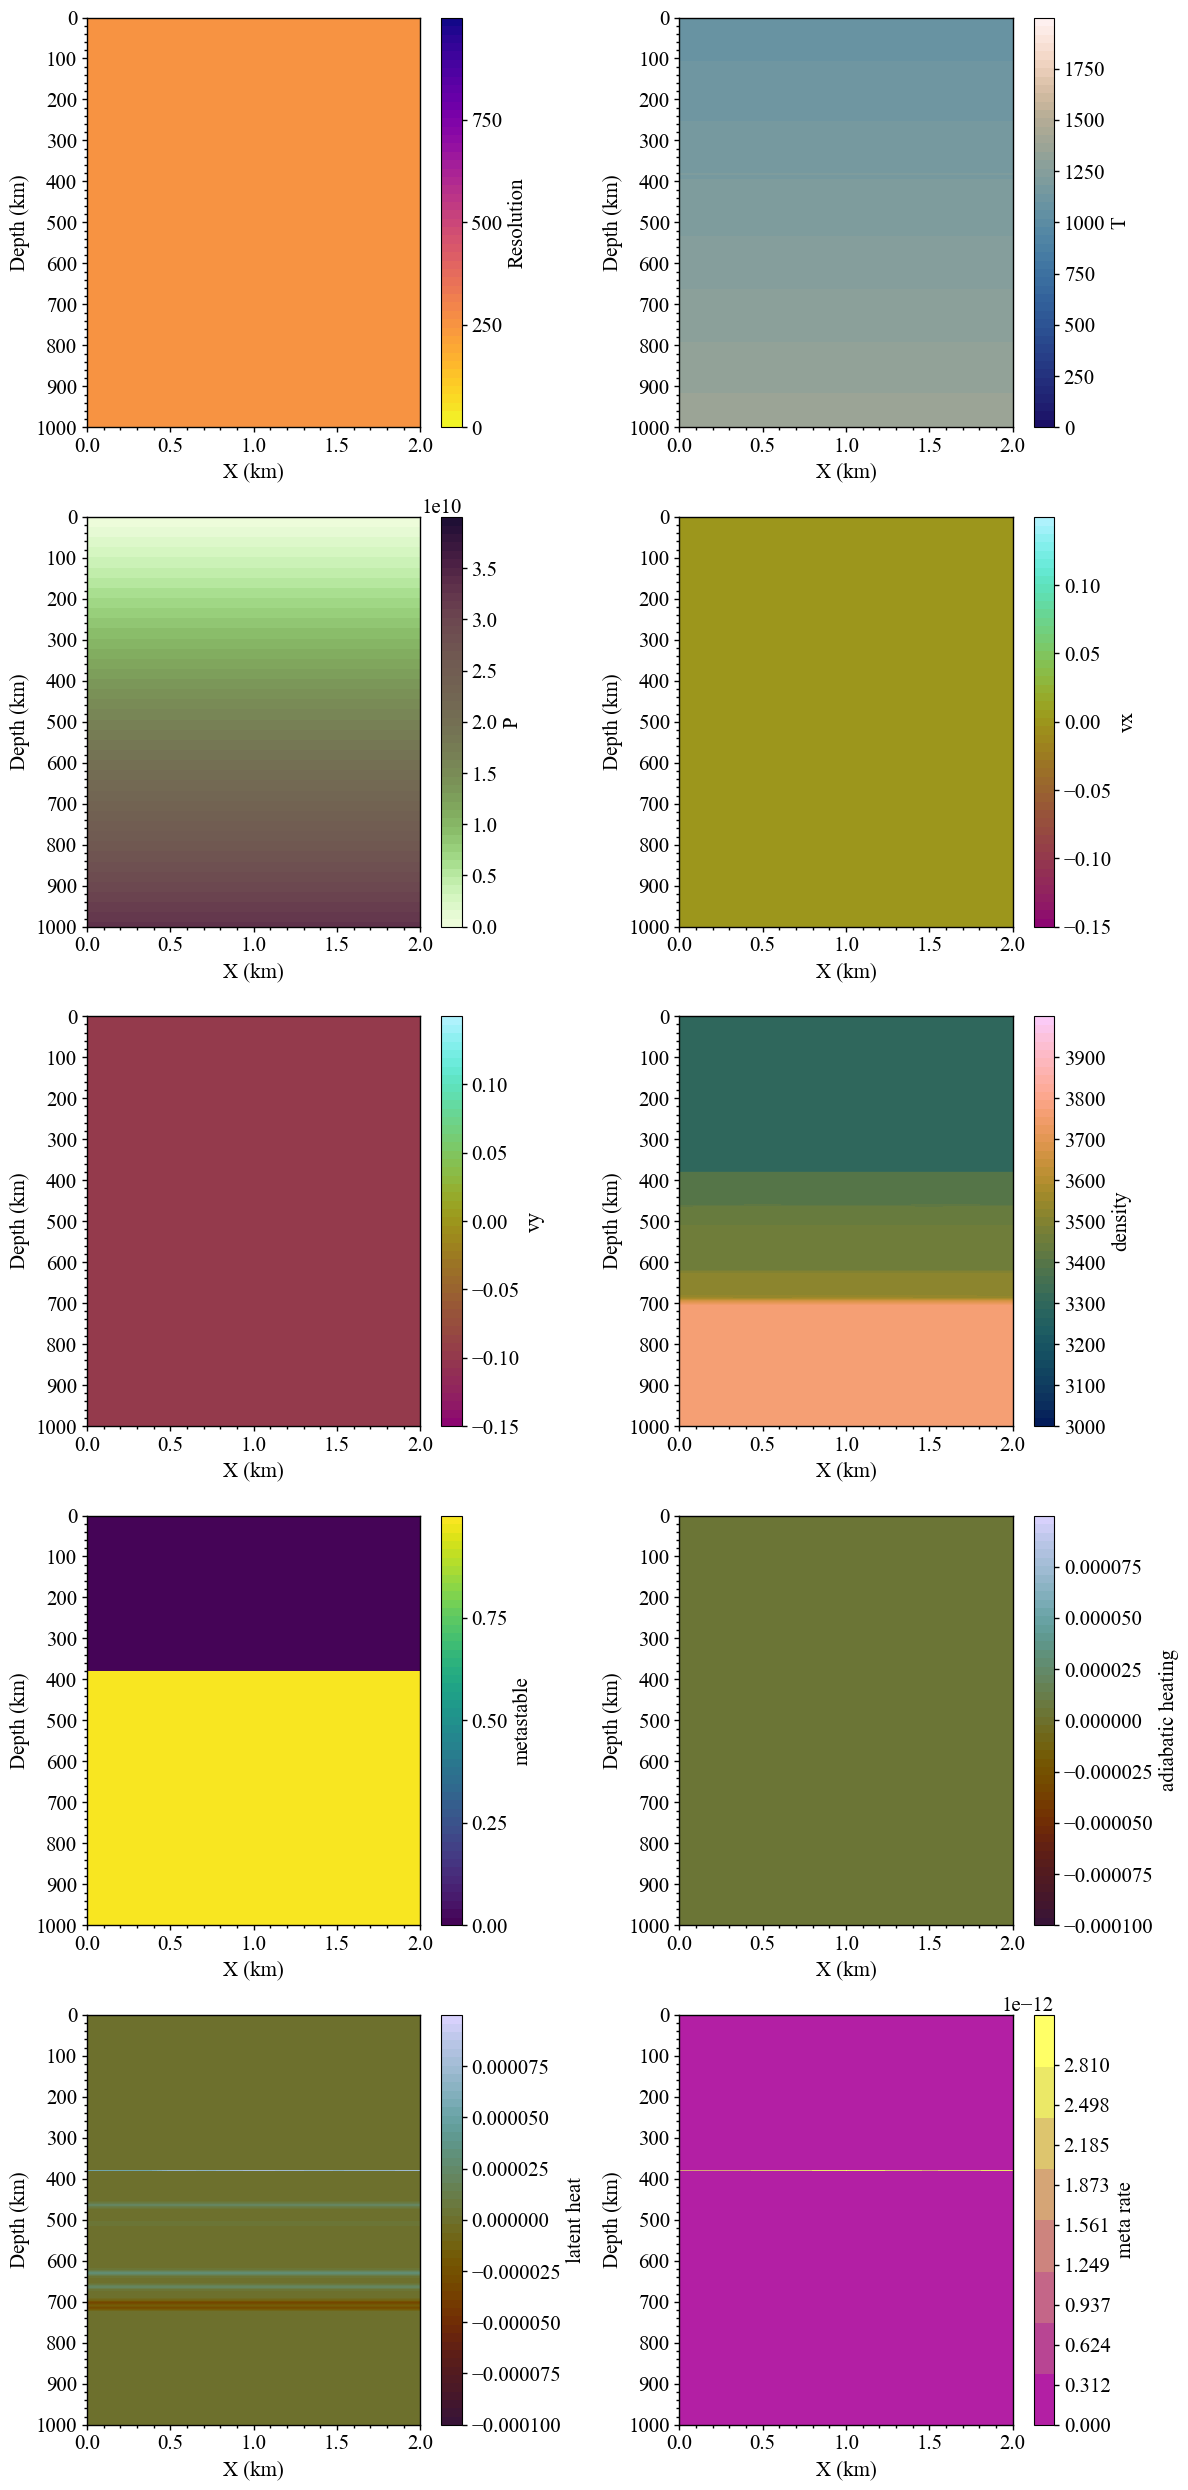

In [62]:
if is_run_aspect_tests_advection:

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator
    from matplotlib import gridspec
    from cmcrameri import cm as ccm

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (x_min/1e3, x_max/1e3) # km
    x_tick_interval = 0.5   # tick interval along x
    y_lim = (y_min/1e3, y_max/1e3) # km
    y_tick_interval = 100.0  # tick interval along y

    resolution_lim = (0.0, 1e3) # resolution
    resolution_level = 50  # number of levels in contourf plot
    resolution_tick_interval = 0.25e3  # tick interval along v

    T_lim = (0.0, 2000.0) # T
    T_level = 50  # number of levels in contourf plot
    T_tick_interval = 250.0  # tick interval along v

    P_lim = (0.0, 40e9) # P
    P_level = 50  # number of levels in contourf plot
    P_tick_interval = 5e9  # tick interval along P

    v_lim = (-0.15, 0.15)
    v_level = 50
    v_tick_interval = 0.05

    density_lim = (3000.0, 4000.0)
    density_level = 50
    density_tick_interval = 100.0
    
    metastable_lim = (0.0, 1.0)
    metastable_level = 50
    metastable_tick_interval = 0.25
    
    metarate_lim = (0.0, 1.0)
    metarate_level = 50
    metarate_tick_interval = 0.25
    
    heating_lim = (-1e-4, 1e-4)
    heating_level = 50
    heating_tick_interval = 2.5e-5

    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Create a figure with a 2x2 grid layout
    fig = plt.figure(figsize=(12, 25), tight_layout=True)
    gs = gridspec.GridSpec(5, 2)

    # Plot the mesh resolution
    ax = fig.add_subplot(gs[0, 0])

    levels = np.linspace(resolution_lim[0], resolution_lim[1], resolution_level)
    ticks=np.arange(resolution_lim[0], resolution_lim[1], resolution_tick_interval)

    color_map = ax.contourf(x_grid/1e3, (y_extent-y_grid)/1e3, resolutions_grid,  vmin=resolution_lim[0], vmax=resolution_lim[1], levels=levels, cmap="plasma_r")  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="Resolution")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Depth (km)")

    ax.invert_yaxis()

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot T
    ax = fig.add_subplot(gs[0, 1])

    levels = np.linspace(T_lim[0], T_lim[1], T_level)
    ticks=np.arange(T_lim[0], T_lim[1], T_tick_interval)

    color_map = ax.contourf(x_grid/1e3, (y_extent-y_grid)/1e3, T_grid,  vmin=T_lim[0], vmax=T_lim[1], levels=levels, cmap=ccm.lapaz)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="T")  # Add colorbar
    cbar.set_ticks(ticks)

    # ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Depth (km)")

    ax.invert_yaxis()

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot P
    ax = fig.add_subplot(gs[1, 0])

    levels = np.linspace(P_lim[0], P_lim[1], P_level)
    ticks=np.arange(P_lim[0], P_lim[1], P_tick_interval)

    color_map = ax.contourf(x_grid/1e3, (y_extent-y_grid)/1e3, P_grid,  vmin=P_lim[0], vmax=P_lim[1], levels=levels, cmap=ccm.tokyo_r)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="P")  # Add colorbar
    cbar.set_ticks(ticks)

    # ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Depth (km)")

    ax.invert_yaxis()

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Plot vx
    ax = fig.add_subplot(gs[1, 1])

    levels = np.linspace(v_lim[0], v_lim[1], v_level)
    ticks=np.arange(v_lim[0], v_lim[1], v_tick_interval)

    color_map = ax.contourf(x_grid/1e3, (y_extent-y_grid)/1e3, vx_grid,  vmin=v_lim[0], vmax=v_lim[1], levels=levels, cmap=ccm.hawaii)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="vx")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Depth (km)")

    ax.invert_yaxis()

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Plot vy
    ax = fig.add_subplot(gs[2, 0])

    levels = np.linspace(v_lim[0], v_lim[1], v_level)
    ticks=np.arange(v_lim[0], v_lim[1], v_tick_interval)

    color_map = ax.contourf(x_grid/1e3, (y_extent-y_grid)/1e3, vy_grid,  vmin=v_lim[0], vmax=v_lim[1], levels=levels, cmap=ccm.hawaii)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="vy")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Depth (km)")

    ax.invert_yaxis()

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # plot density
    ax = fig.add_subplot(gs[2, 1])

    levels = np.linspace(density_lim[0], density_lim[1], density_level)
    ticks=np.arange(density_lim[0], density_lim[1], density_tick_interval)

    color_map = ax.contourf(x_grid/1e3, (y_extent-y_grid)/1e3, density_grid,  vmin=density_lim[0], vmax=density_lim[1], levels=levels, cmap=ccm.batlow)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="density")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Depth (km)")

    ax.invert_yaxis()

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # plot metastable
    if with_metastable:
        ax = fig.add_subplot(gs[3, 0])

        levels = np.linspace(metastable_lim[0], metastable_lim[1], metastable_level)
        ticks=np.arange(metastable_lim[0], metastable_lim[1], metastable_tick_interval)

        color_map = ax.contourf(x_grid/1e3, (y_extent-y_grid)/1e3, metastable_grid,  vmin=metastable_lim[0], vmax=metastable_lim[1], levels=levels, cmap="viridis")  # Metastable color map
        cbar = fig.colorbar(color_map, ax=ax, label="metastable")  # Add colorbar
        cbar.set_ticks(ticks)

        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)

        ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
        ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
        ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

        ax.set_xlabel("X (km)")
        ax.set_ylabel("Depth (km)")

        ax.invert_yaxis()

        for spine in ax.spines.values():
            # Adjust spine thickness for this plot
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    
    # plot adiabatic heating
    ax = fig.add_subplot(gs[3, 1])

    levels = np.linspace(heating_lim[0], heating_lim[1], heating_level)
    ticks=np.arange(heating_lim[0], heating_lim[1], heating_tick_interval)

    color_map = ax.contourf(x_grid/1e3, (y_extent-y_grid)/1e3, aheat_grid, cmap=ccm.glasgow, vmin=heating_lim[0], vmax=heating_lim[1], levels=levels)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="adiabatic heating")  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (km)")
    ax.set_ylabel("Depth (km)")

    ax.invert_yaxis()

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # plot letent heating
    if with_latent_heat:
        ax = fig.add_subplot(gs[4, 0])

        levels = np.linspace(heating_lim[0], heating_lim[1], heating_level)
        ticks=np.arange(heating_lim[0], heating_lim[1], heating_tick_interval)
        color_map = ax.contourf(x_grid/1e3, (y_extent-y_grid)/1e3, lheat_grid,\
                                cmap=ccm.glasgow, vmin=heating_lim[0], vmax=heating_lim[1], levels=levels)
        
        # levels = np.linspace(np.min(lheat_grid), np.max(lheat_grid), heating_level)
        # ticks = np.linspace(np.min(lheat_grid), np.max(lheat_grid), 10)
        # color_map = ax.contourf(x_grid/1e3, (y_extent-y_grid)/1e3, lheat_grid,\
        #                         cmap=ccm.glasgow, vmin=np.min(lheat_grid), vmax=np.max(lheat_grid), levels=levels,\
        #                             extend="both")

        cbar = fig.colorbar(color_map, ax=ax, label="latent heat")  # Add colorbar
        cbar.set_ticks(ticks)

        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)

        ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
        ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
        ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

        ax.set_xlabel("X (km)")
        ax.set_ylabel("Depth (km)")

        ax.invert_yaxis()

        for spine in ax.spines.values():
            # Adjust spine thickness for this plot
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

        # plot metastable
    if with_metastable:
        ax = fig.add_subplot(gs[4, 1])

        # levels = np.linspace(metarate_lim[0], metarate_lim[1], metarate_level)
        # ticks=np.arange(metarate_lim[0], metarate_lim[1], metarate_tick_interval)
        levels = np.linspace(0.0, np.max(metarate_grid), 50)
        ticks = np.linspace(0.0, np.max(metarate_grid), 10)
        color_map = ax.contourf(x_grid/1e3, (y_extent-y_grid)/1e3, metarate_grid, cmap=ccm.buda, vmin=0.0, vmax=np.max(metarate_grid), level=levels) 
        cbar = fig.colorbar(color_map, ax=ax, label="meta rate")  # Add colorbar
        cbar.set_ticks(ticks)

        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)

        ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
        ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
        ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

        ax.set_xlabel("X (km)")
        ax.set_ylabel("Depth (km)")

        ax.invert_yaxis()

        for spine in ax.spines.values():
            # Adjust spine thickness for this plot
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    if with_metastable:
        if reaction_metastable_trivial:
            ofile_name = os.path.join(case_dir, "metastable_advection_trivial_adT_%.1f_adv_%.3f_end_%.2e_maxstep_%.2e_vstep_%d_lt_%d" % (adiabatic_surface_temperature, advection_rate, end_time, maximum_time_step, vtu_step, with_latent_heat))
        else:
            ofile_name = os.path.join(case_dir, "metastable_advection_adT_%.1f_adv_%.3f_end_%.2e_maxstep_%.2e_vstep_%d_lt_%d" % (adiabatic_surface_temperature, advection_rate, end_time, maximum_time_step, vtu_step, with_latent_heat))
    else:
        ofile_name = os.path.join(case_dir, "trivial_advection_adT_%.1f_adv_%.3f_end_%.2e_maxstep_%.2e_vstep_%d_lt_%d" % (adiabatic_surface_temperature, advection_rate, end_time, maximum_time_step, vtu_step, with_latent_heat))

    fig.savefig(ofile_name + ".png")
    print("Saved figure %s" % (ofile_name + ".png"))
    fig.savefig(ofile_name + ".pdf")
    print("Saved figure %s" % (ofile_name + ".pdf"))

    # Reset rcParams to defaults
    rcdefaults()

# ASPECT Cases

## 2D test

### Case Options

In [63]:
run_aspect_2d_test = False
run_aspect_2d_test_first_step = False

if run_aspect_2d_test:

    aspect_dir = "/home/lochy/Softwares/aspect"
    aspect_executable = os.path.join(aspect_dir, "build_master_TwoD_rebase/aspect")

    case_root_dir = "/mnt/lochy/ASPECT_DATA/MOW/mow_tests"

    # todo_Meta
    case_options = {
      "base directory": os.path.join(root_path, "hamageolib/research/haoyuan_2d_subduction/legacy_files/reference_TwoD/240106"), 
      "branch": "master_TwoD_rebase",
      "output directory": case_root_dir,
      "name": "test_foo2",
      "depth average file": os.path.join(root_path, "hamageolib/research/haoyuan_2d_subduction/legacy_files/reference_TwoD/depth_average.txt"),
      "include fast first step": 1,
      "version": 3.0,
      "test initial steps": {
        "number of outputs": 3,
        "interval of outputs": 10000.0
      },
      "geometry": "chunk",
      "potential temperature": 1573.0,
      "boundary condition": {
        "model": "all free slip"
      },
      "use world builder": 1,
      "world builder": {
        "use new ridge implementation": 1,
        "plate age method": "adjust box width",
        "box width before adjusting": 15570000.0,
        "adjust mesh with box width": 1,
        "subducting plate": {
          "age trench": 80000000.0,
          "sp rate": 0.05
        },
        "overiding plate": {
          "age": 40000000.0,
          "transit": {
            "age": 20000000.0,
            "length": 700000.0
          }
        }
      },
      "use new rheology module": 1,
      "coupling the eclogite phase to shear zone viscosity": 0,
      "slurm": [
        {
          "slurm file": os.path.join(root_path, "tests/fixtures/research/haoyuan_2d_subduction/slurm_files/230924/job_p-billen.sh"),
          "build directory": "master_TwoD",
          "tasks per node": 8,
          "cpus": 8
        }
      ],
      "mantle rheology": {
        "scheme": "HK03_WarrenHansen23",
        "Coh": 500.0,
        "delta Edisl": 0.0
      },
      "include peierls creep": 1,
      "peierls creep": {
        "scheme": "MK10",
        "maximum peierls iterations": 100,
        "fix peierls V as": "dislocation"
      },
      "refinement level": 9,
      "shear zone": {
        "constant viscosity": 1e+20,
        "cutoff depth": 100000.0,
        "thickness": 7500.0
      },
      "phase transition model CDPT type": "HeFESTo_consistent",
      "prescribe temperature method": "plate model 1",
      "prescribe temperature width": 400000.0,
      "outputs": {
        "heat flux": 1
      },
      "refinement": {
        "refine wedge": 1
      },
      "composition method": {
        "scheme": "particle"
      },
      'metastable': {
        "include metastable": 1
      }
    }

### Create the Case

In [64]:
# todo_case
if run_aspect_2d_test:
    from hamageolib.research.haoyuan_2d_subduction.legacy_tools import create_case_with_json, CASE_TWOD, CASE_OPT_TWOD
    create_case_with_json(case_options, CASE_TWOD, CASE_OPT_TWOD)

### Run the First step

In [65]:
if run_aspect_2d_test and run_aspect_2d_test_first_step:
    import subprocess, re

    case_dir = os.path.join(case_root_dir, "test_foo1")
    prm_path = os.path.join(case_dir, "case_ini.prm")

    # Run the ASPECT executable with the parameter file
    # The function ensures that both the expected outputs are generated and no errors are produced
    # 'capture_output=True' collects both stdout and stderr for further checks
    # 'cwd' set the run from case_dir
    completed_process = subprocess.run([aspect_executable, prm_path], capture_output=True, text=True, cwd=case_dir)

    # Capture the standard output and error streams
    stdout = completed_process.stdout
    stderr = completed_process.stderr

    # Uncomment the following lines for debugging purposes to inspect the output
    # print(stdout)  # Debugging: Prints the standard output
    # print(stderr)  # Debugging: Prints the standard error

    # Check if the expected line indicating wallclock time appears in the output
    # The expected line format is something like:
    # -- Total wallclock time elapsed including restarts: 1s
    assert(re.match(".*Total wallclock", stdout.split('\n')[-6]))

    # Ensure that the error stream is empty, indicating no issues during the run
    assert(stderr == "")

## Visualize the results

make use of the jupyter_notebooks/TwoDSubduction/PlotCase.ipynb notebook